### Import

In [20]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pylab import rcParams
import datetime as dt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from scipy.interpolate import interp1d
import matplotlib.patches as mpatches

plt.rcParams['figure.figsize'] =7.8 ,3.9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams["figure.dpi"] = 300
font = {'family' : 'Times New Roman','weight' : "light", 'size'   : 11}
plt.rc('font', **font)

In [2]:
# constants  #
#------------#
HDF5_dir = "E:\\MessdatenStoeckach\\"
resampled_dir = r'E:\resampled'
dates = os.listdir(HDF5_dir)
phases = ["1","2","3"]

In [3]:
def generateXAxisData():
    return np.linspace(2000, 149950, 2960)

In [4]:
def levels_dbmyA(Aout):
    """ calcs the voltage levels
    / replaces 0 with 1e-3
    / dBμV = 20log₁₀(VOUT/1μV) where VOUT in μV
    / 1V = 120dbmyV
    /dBμV or dBuV (decibel microvolt, amplitude ratio) — absolute voltage in decibels relative to one microvolt, 
    used to measure the signal strength in RF and audio cables. That is dBμV = 20log₁₀(VOUT/1μV) where VOUT in μV. This shows that dBμV is independent of impedance. Since it is the ratio of two voltages, they can be measured as peak-to-peak or RMS and with the same units. Reference voltage 1 μV.
    """
    Aout[Aout<1e-6] = 1e-6
    Aout = Aout/1e-6
    Aout = np.log10(Aout)
    Aout = Aout*20
    return Aout

In [5]:
def levels_dbmyV(Vout):
    """ calcs the voltage levels
    / replaces 0 with 1e-3
    / dBμV = 20log₁₀(VOUT/1μV) where VOUT in μV
    / 1V = 120dbmyV
    /dBμV or dBuV (decibel microvolt, amplitude ratio) — absolute voltage in decibels relative to one microvolt, 
    used to measure the signal strength in RF and audio cables. That is dBμV = 20log₁₀(VOUT/1μV) where VOUT in μV. This shows that dBμV is independent of impedance. Since it is the ratio of two voltages, they can be measured as peak-to-peak or RMS and with the same units. Reference voltage 1 μV.
    """
    Vout = Vout*230
    Vout[Vout<1e-6] = 1e-6
    Vout = Vout/1e-6
    Vout = np.log10(Vout)
    Vout = Vout*20
    return Vout

In [6]:
#limits
#range 2 - 9 kHz (134dbmyV) #
#----------------------------#
f2_9 = [i for i in range(2000, 8999, 50)]
limits2_9 = [134 for i in range(len(f2_9))]
    
# range 9-95 kHz (134dbmyV to 122 dbmyV)  #
#-----------------------------------------#
n = 4000
dbV = np.linspace(134, 122, n)
f9_95 = f = np.logspace(0.9542425094 ,1.9777236053, n ) #9, 95 kHz
# interpolate
xnew = [i for i in range(9000, 94999, 50)]
y = dbV
x = f*1e3
inter = interp1d(x, y)
limits9_95 = dbV_interpolated = inter(xnew)

# range 95 - 150 kHz (122dbmyV) #
#------------------------------#
f95_150 = [i for i in range(95000, 149999, 50)]
limits9_150 = [122 for i in range(len(f95_150))]

limits = limits2_9 + list(limits9_95) + limits9_150 

### Load Data

In [7]:
#datelist = ["2017-05-07","2017-05-08","2017-05-09","2017-05-10","2017-05-11","2017-05-12"]
#datelist = ["2017-05-10"]
datelist = pd.date_range(start="2017-03-02", end="2018-02-17").strftime("%Y-%m-%d").astype(str).to_list()

In [8]:
rmsi_all_p1 = pd.DataFrame()
shi_all_p1 = pd.DataFrame()
rmsi_all_p2 = pd.DataFrame()
shi_all_p2 = pd.DataFrame()
rmsi_all_p3 = pd.DataFrame()
shi_all_p3 = pd.DataFrame()

for date in datelist:
    rmsi_all_p1 = rmsi_all_p1.append(pd.read_pickle("E:\\resampled_phasevise\\rmsi\\" + date + "_rmsi_10min_mean_p1.p"))
    shi_all_p1 = shi_all_p1.append(pd.read_pickle("E:\\resampled_phasevise\\i\\" + date + "_harmonics10min_i_mean_p1.p"))
    
    rmsi_all_p2 = rmsi_all_p2.append(pd.read_pickle("E:\\resampled_phasevise\\rmsi\\" + date + "_rmsi_10min_mean_p2.p"))
    shi_all_p2 = shi_all_p2.append(pd.read_pickle("E:\\resampled_phasevise\\i\\" + date + "_harmonics10min_i_mean_p2.p"))
    
    rmsi_all_p3 = rmsi_all_p3.append(pd.read_pickle("E:\\resampled_phasevise\\rmsi\\" + date + "_rmsi_10min_mean_p3.p"))
    shi_all_p3 = shi_all_p3.append(pd.read_pickle("E:\\resampled_phasevise\\i\\" + date + "_harmonics10min_i_mean_p3.p"))

In [9]:
rmsi_all_p1.index = rmsi_all_p1.index.tz_localize(None)
rmsi_all_p2.index = rmsi_all_p2.index.tz_localize(None)
rmsi_all_p3.index = rmsi_all_p3.index.tz_localize(None)

In [10]:
shi_all_p1 = shi_all_p1.fillna(0)
shi_all_p2 = shi_all_p2.fillna(0)
shi_all_p3 = shi_all_p3.fillna(0)

### Histogramm first

In [11]:
colors

UsageError: %colors: you must specify a color scheme. See '%colors?'


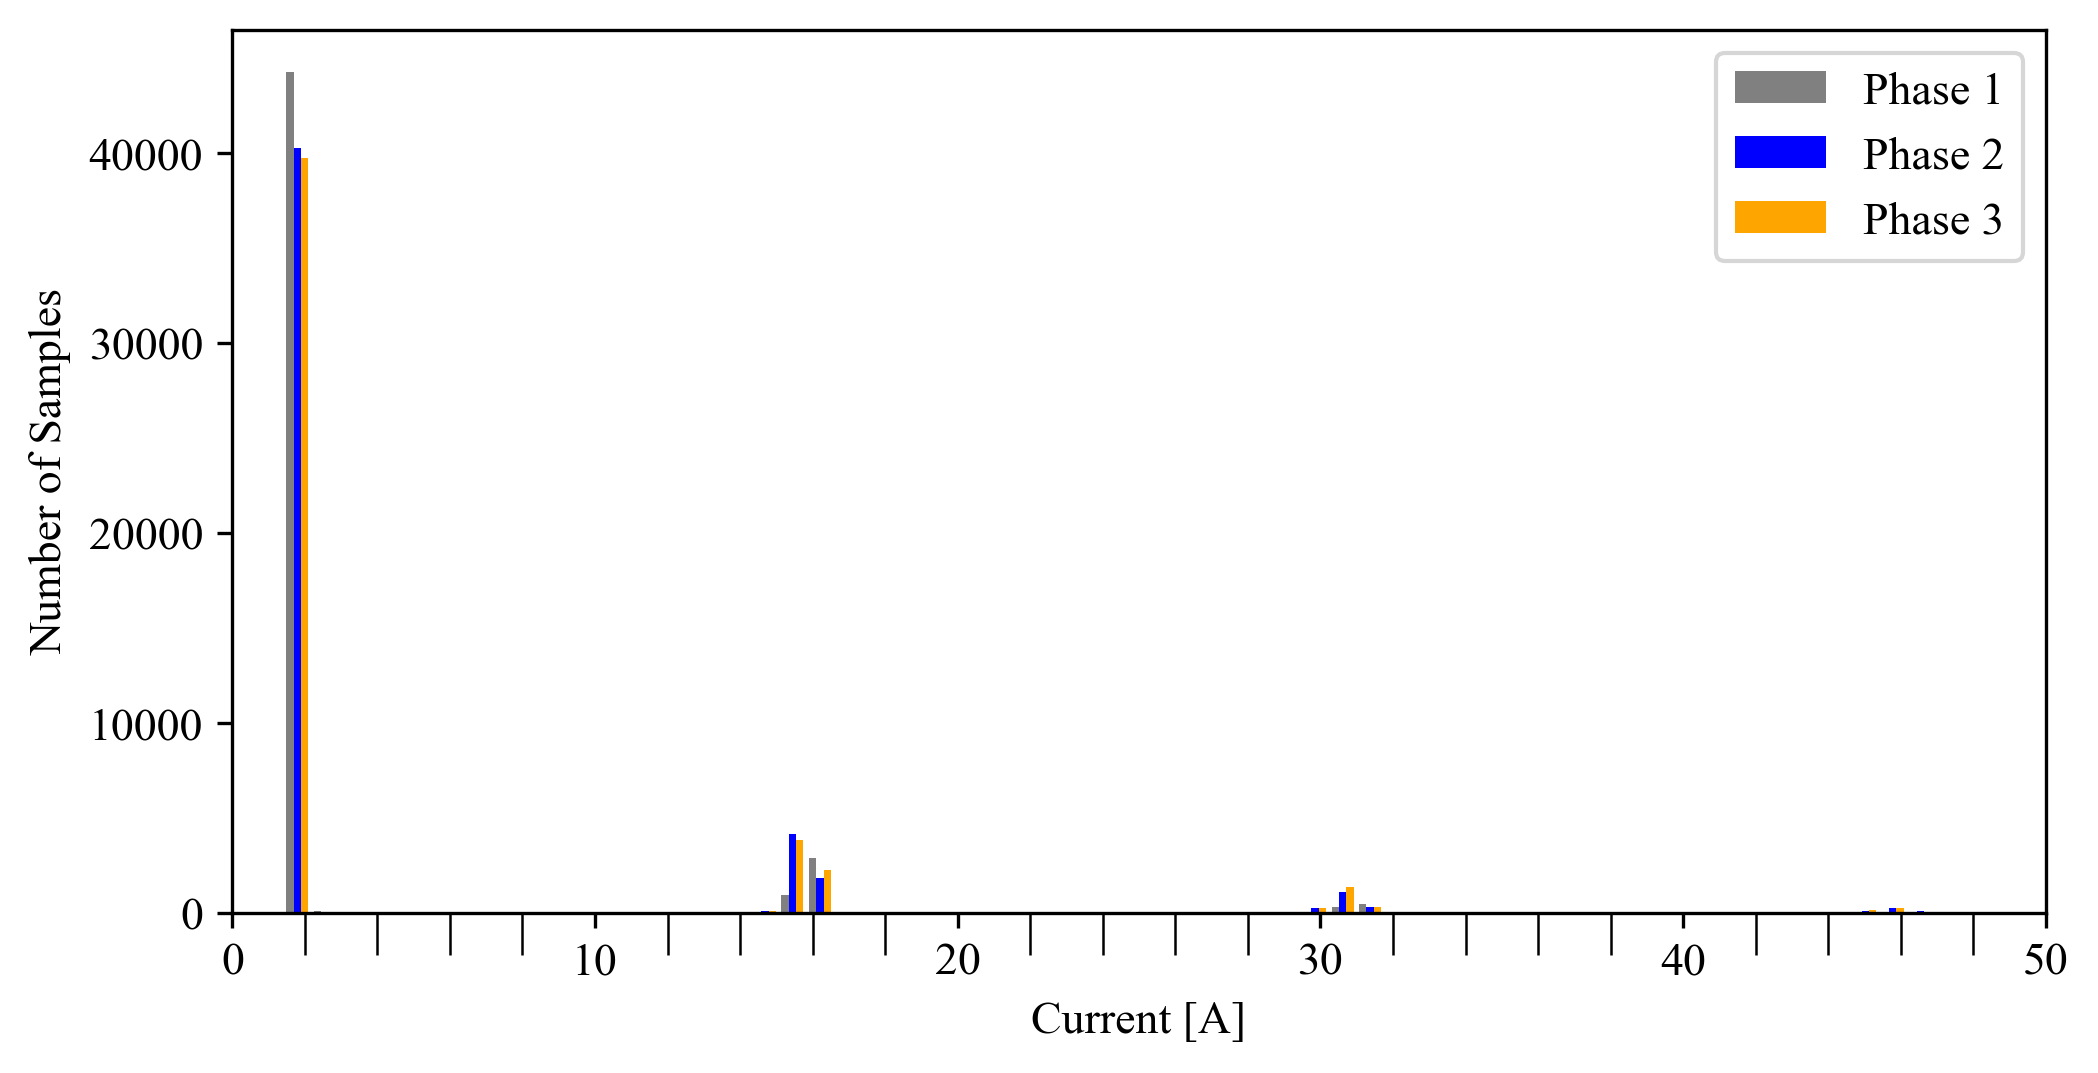

In [172]:
rmsi_p1_c1 = rmsi_all_p1
rmsi_p2_c1 = rmsi_all_p2
rmsi_p3_c1 = rmsi_all_p3

fig, ax = plt.subplots()
colors = ['grey', 'blue', 'orange']
hist_data = ax.hist((rmsi_p1_c1.values.transpose(), rmsi_p2_c1.values, rmsi_p3_c1.values), 100, color=colors,density=False, histtype='bar', label=['Phase 1', 'Phase 2','Phase 3'])
ax.legend()
ax.set_xlabel("Current [A]")
ax.set_ylabel('Number of Samples')
ax.set_xlim(0,50)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=10)

In [177]:
d = {'Phase1':hist_data[0][0],'Phase2':hist_data[0][1],'Phase3':hist_data[0][2]}
df = pd.DataFrame(data=d)
df.index = hist_data[1][:100]
df.to_excel("4-50.xlsx")

### PCA

In [13]:
model1 = PCA(2)
phase1_trans = model1.fit_transform(shi_all_p1)

model2 = PCA(2)
phase2_trans = model2.fit_transform(shi_all_p2)

model3 = PCA(2)
phase3_trans = model3.fit_transform(shi_all_p3)

In [14]:
from sklearn.preprocessing import StandardScaler

phase1_trans = StandardScaler().fit_transform(phase1_trans)
phase2_trans = StandardScaler().fit_transform(phase2_trans)
phase3_trans = StandardScaler().fit_transform(phase3_trans)

### DBSCAN

In [15]:
clustering1 = DBSCAN(eps=0.28, min_samples=200).fit(phase1_trans)
clustering2 = DBSCAN(eps=0.28, min_samples=200).fit(phase2_trans)
clustering3 = DBSCAN(eps=0.28, min_samples=200).fit(phase3_trans)

In [16]:
## clusteranpassung
labels3 = clustering3.labels_
labels3[labels3 == 0] = 100
labels3[labels3 == 1] = 0
labels3[labels3 == 2] = 1
labels3[labels3 == 100] = 2

labels2 = clustering2.labels_
labels1 = clustering1.labels_

### Plot PCA + Clustering

Text(0.5, 0, 'PC 1')

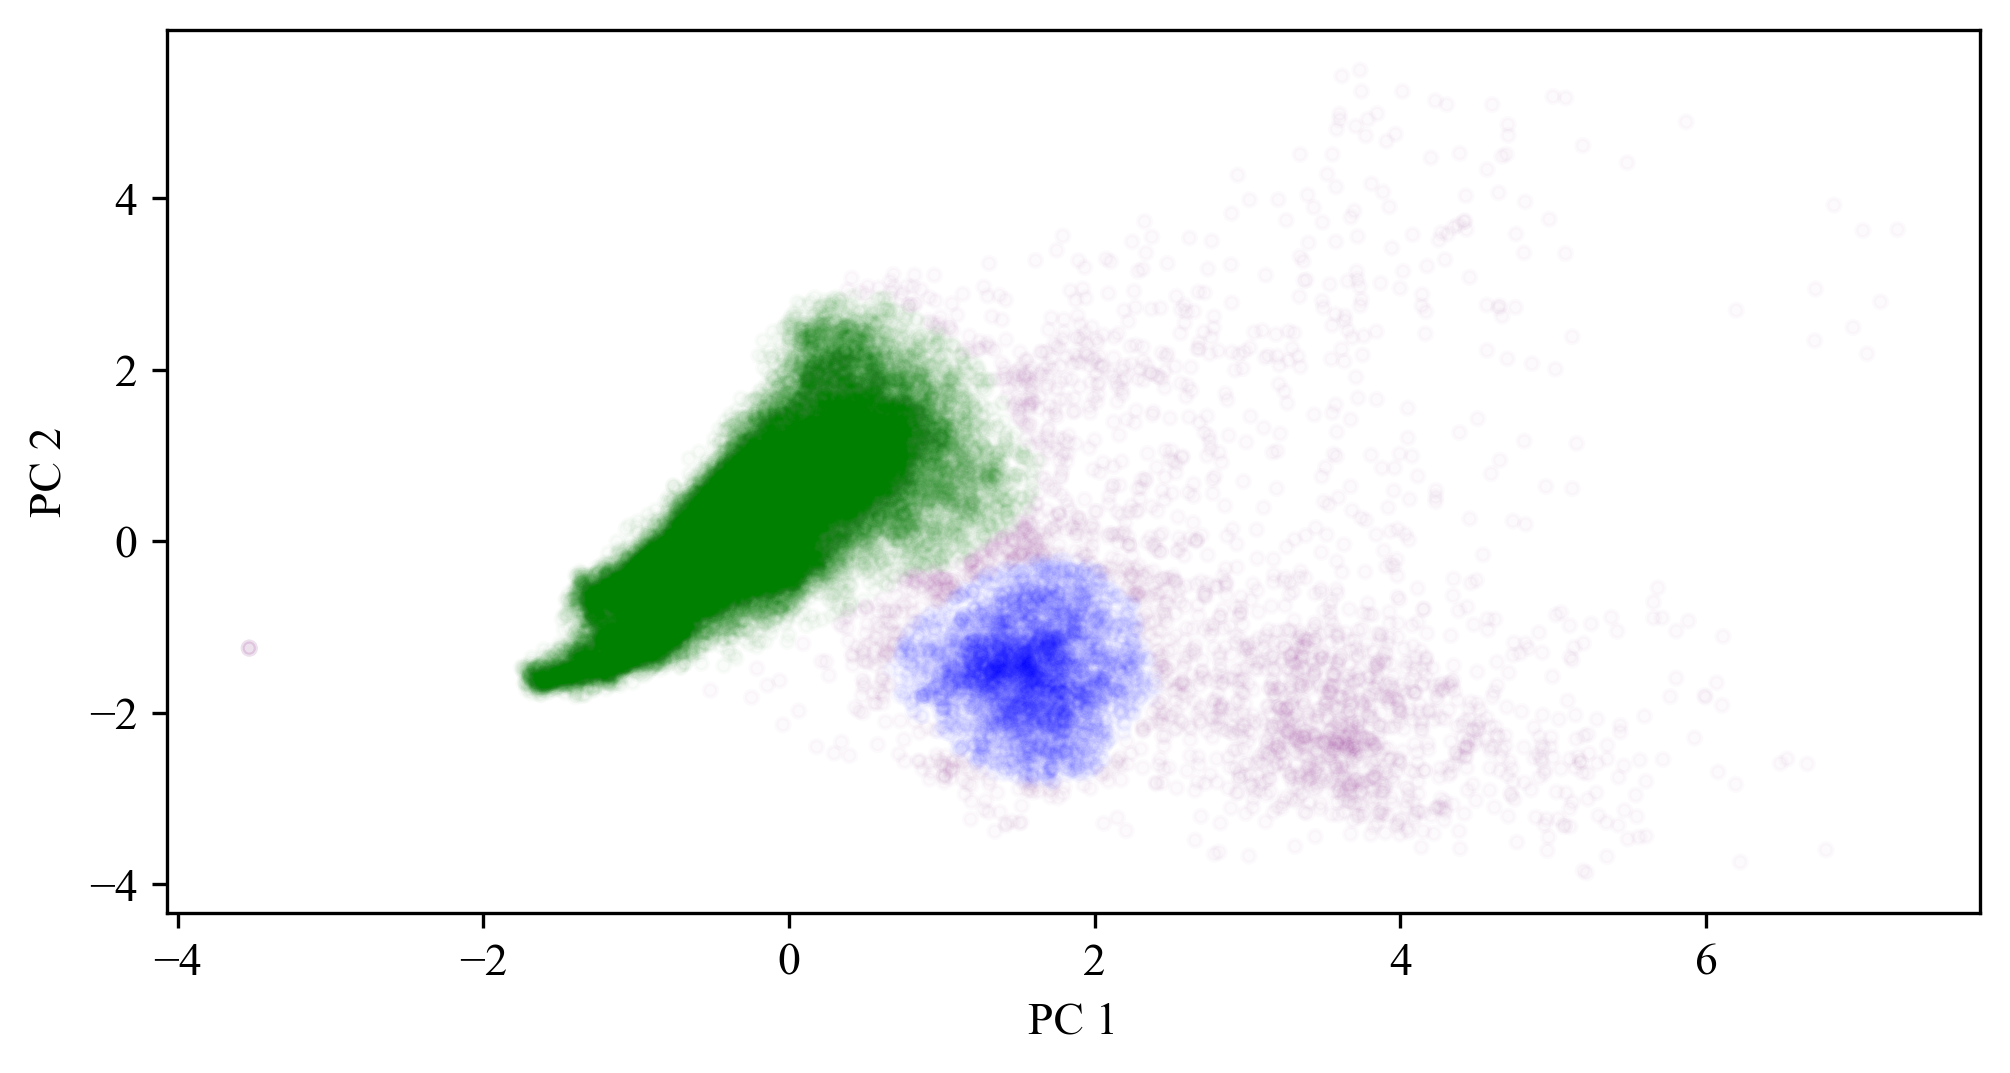

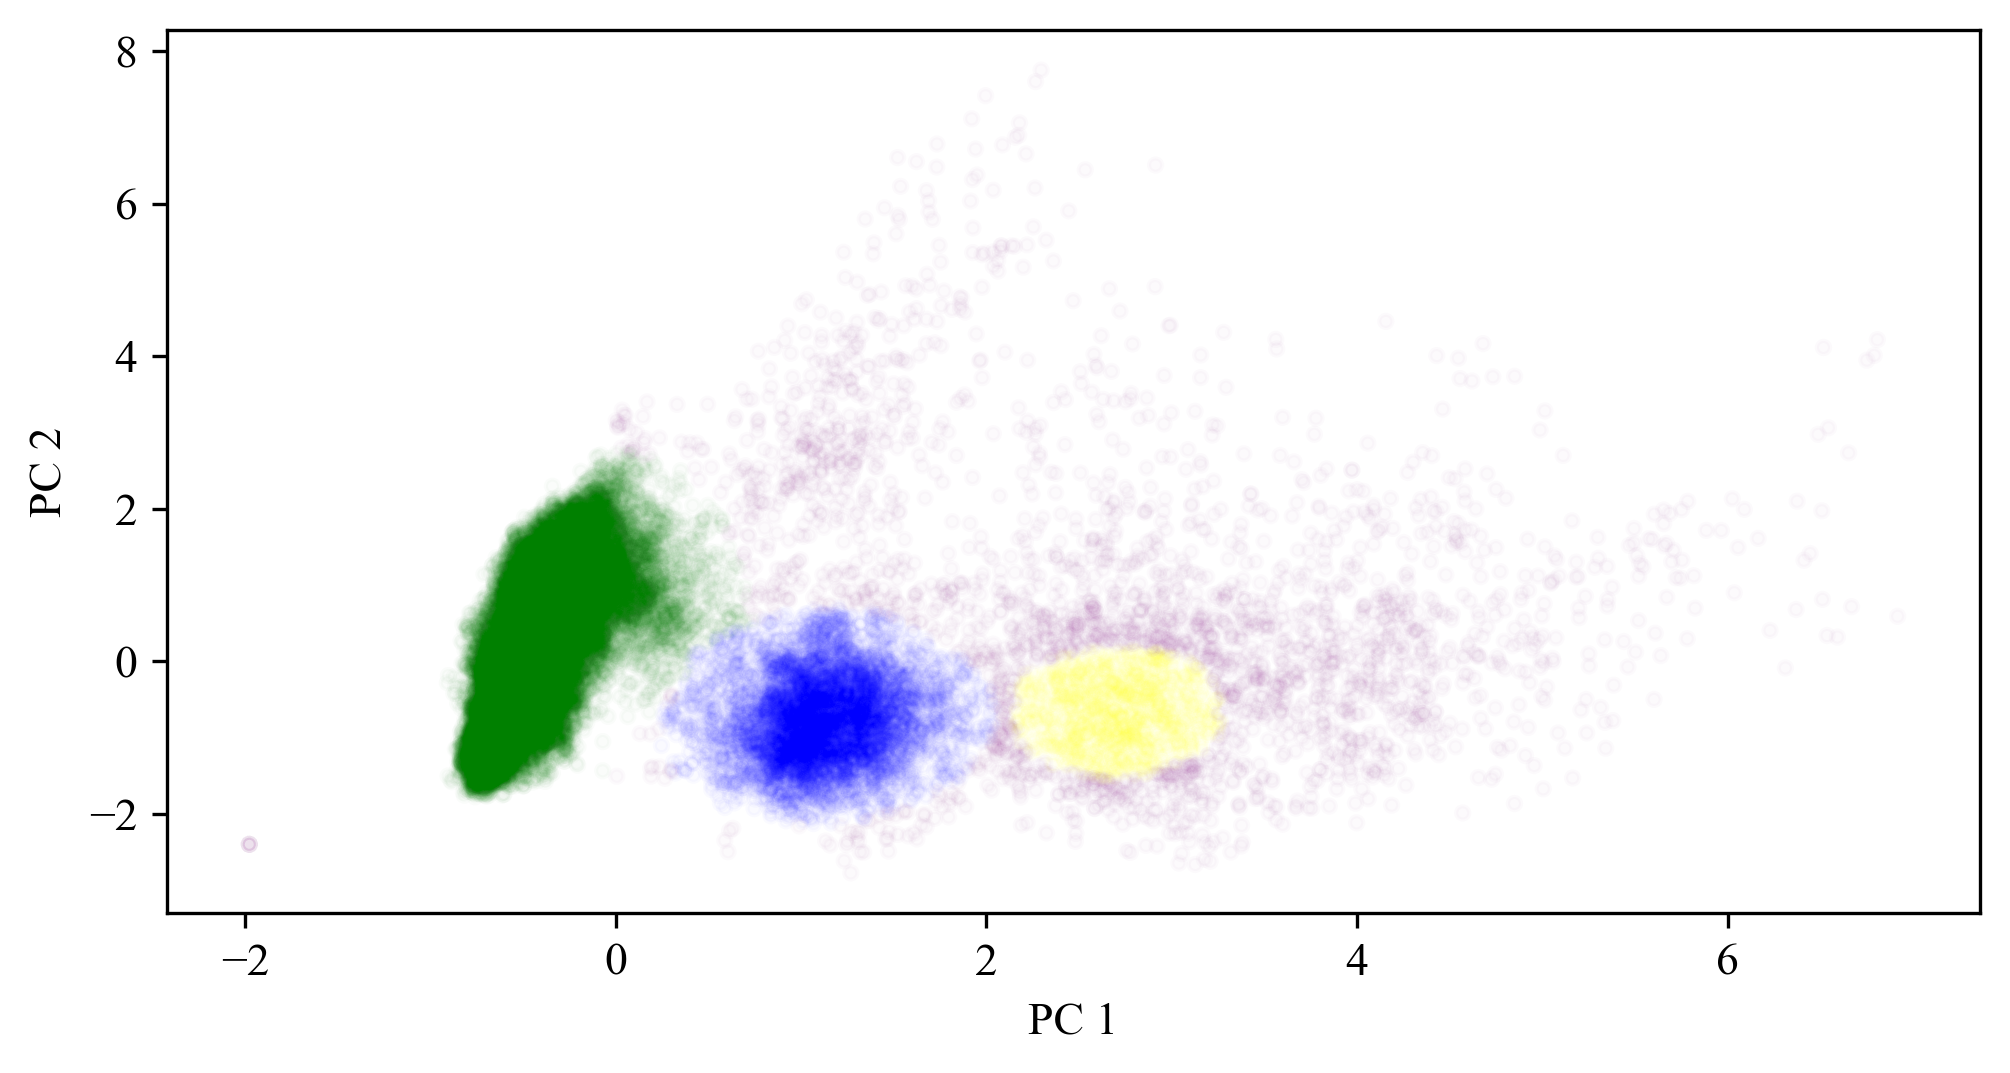

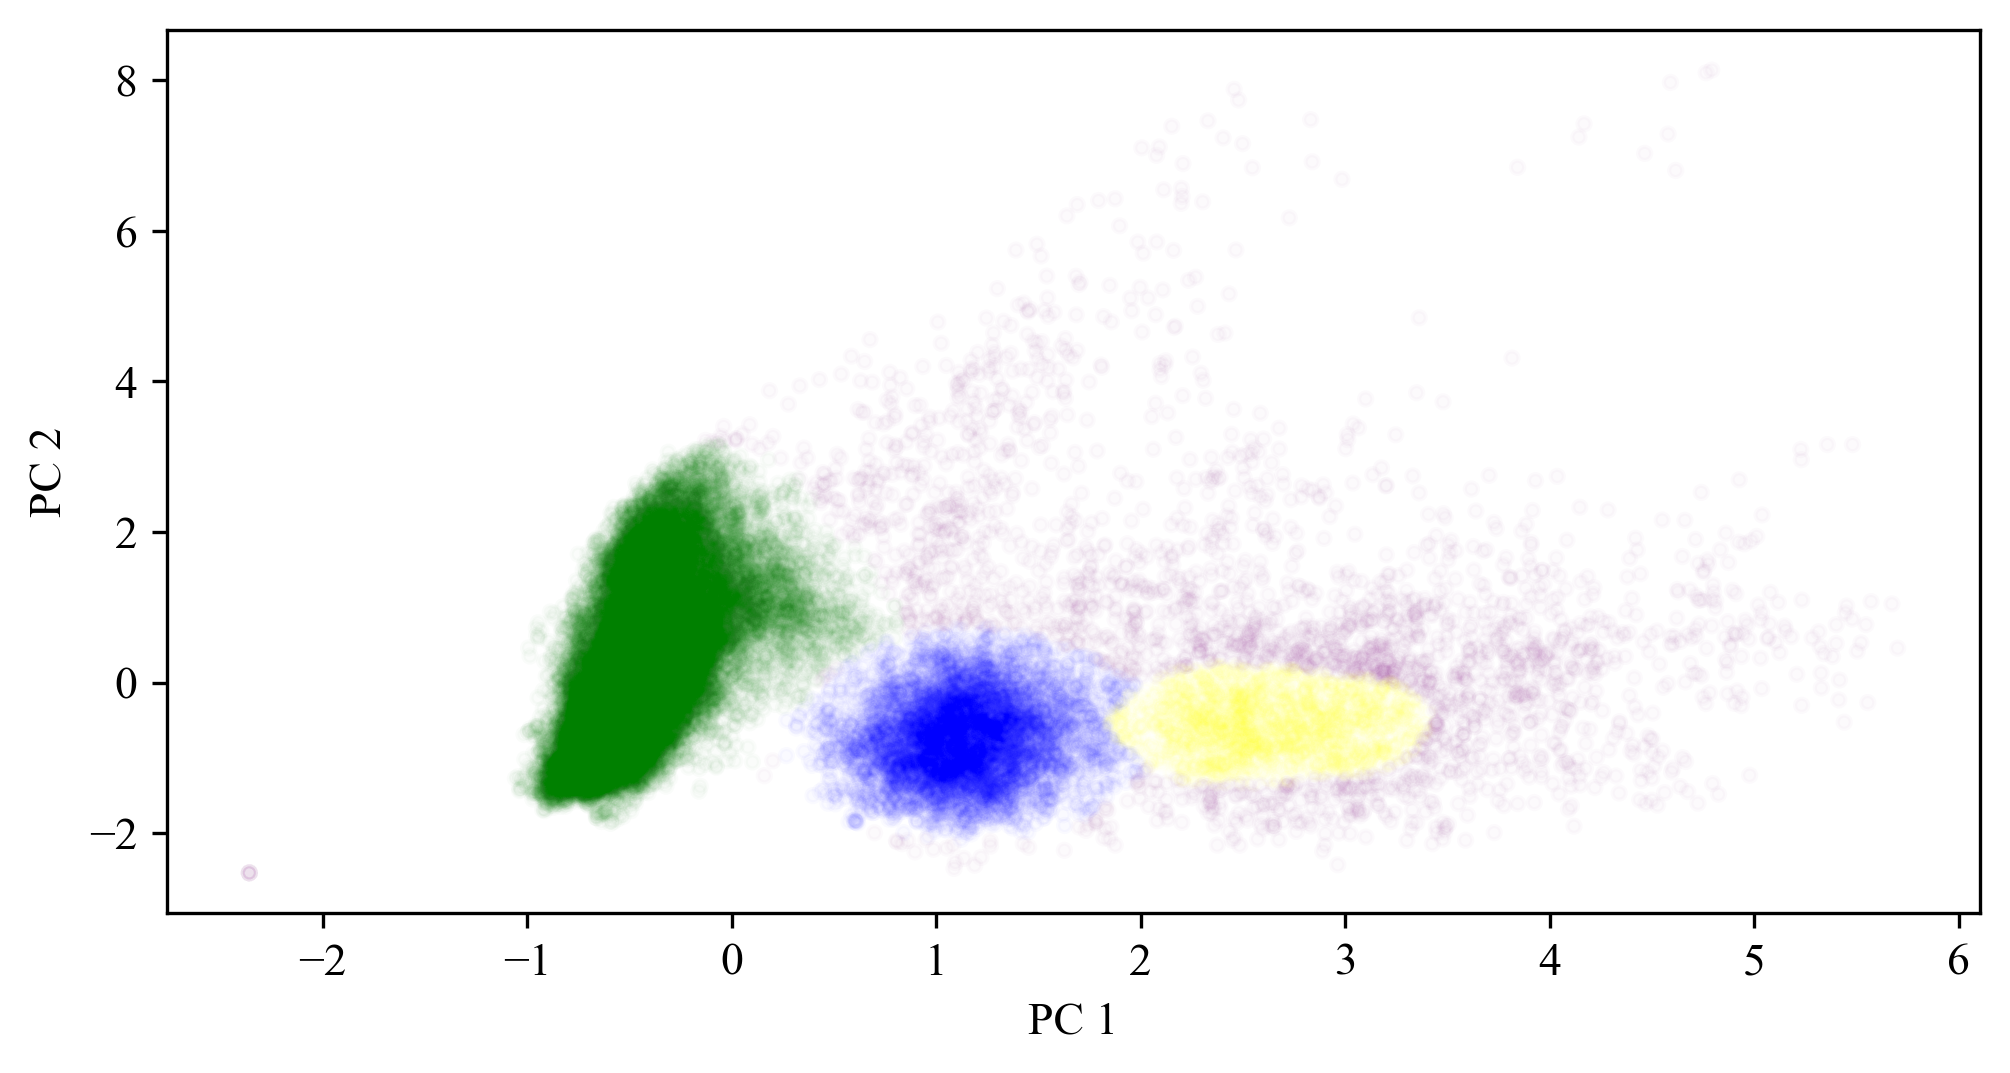

In [33]:
colors1 = []
for l in labels1:
    if l == 0:
        colors1.append('blue')
    if l == 1:
        colors1.append('green')
    if l == 2:
        colors1.append('yellow')
    if l == -1:
        colors1.append('purple')
        
colors2 = []
for l in labels2:
    if l == 0:
        colors2.append('blue')
    if l == 1:
        colors2.append('green')
    if l == 2:
        colors2.append('yellow')
    if l == -1:
        colors2.append('purple')
        
colors3 = []
for l in labels3:
    if l == 0:
        colors3.append('blue')
    if l == 1:
        colors3.append('green')
    if l == 2:
        colors3.append('yellow')
    if l == -1:
        colors3.append('purple')

fig, ax = plt.subplots()
ax.scatter(phase1_trans[:,0], phase1_trans[:,1], s=10, c=colors1, alpha=0.02)
ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')


fig, ax = plt.subplots()
ax.scatter(phase2_trans[:,0], phase2_trans[:,1], s=10, c=colors2, alpha=0.02)
ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')


fig, ax = plt.subplots()
ax.scatter(phase3_trans[:,0], phase3_trans[:,1], s=10, c=colors3, alpha=0.02)
ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')

In [113]:
d={'PC1_p1' :phase1_trans[:,0],'PC2_p1': phase1_trans[:,1], "Cluster_p1": colors1}

df = pd.DataFrame(data=d)

df.to_excel("4-16.xlsx")

In [114]:
d={'PC1_p2' :phase2_trans[:,0],'PC2_p2': phase2_trans[:,1], "Cluster_p2": colors2}

df = pd.DataFrame(data=d)

df.to_excel("4-17.xlsx")

In [115]:
d={'PC1_p3' :phase3_trans[:,0],'PC2_p3': phase3_trans[:,1], "Cluster_p3": colors1}

df = pd.DataFrame(data=d)

df.to_excel("4-18.xlsx")

Text(0.5, 0, 'PC 1')

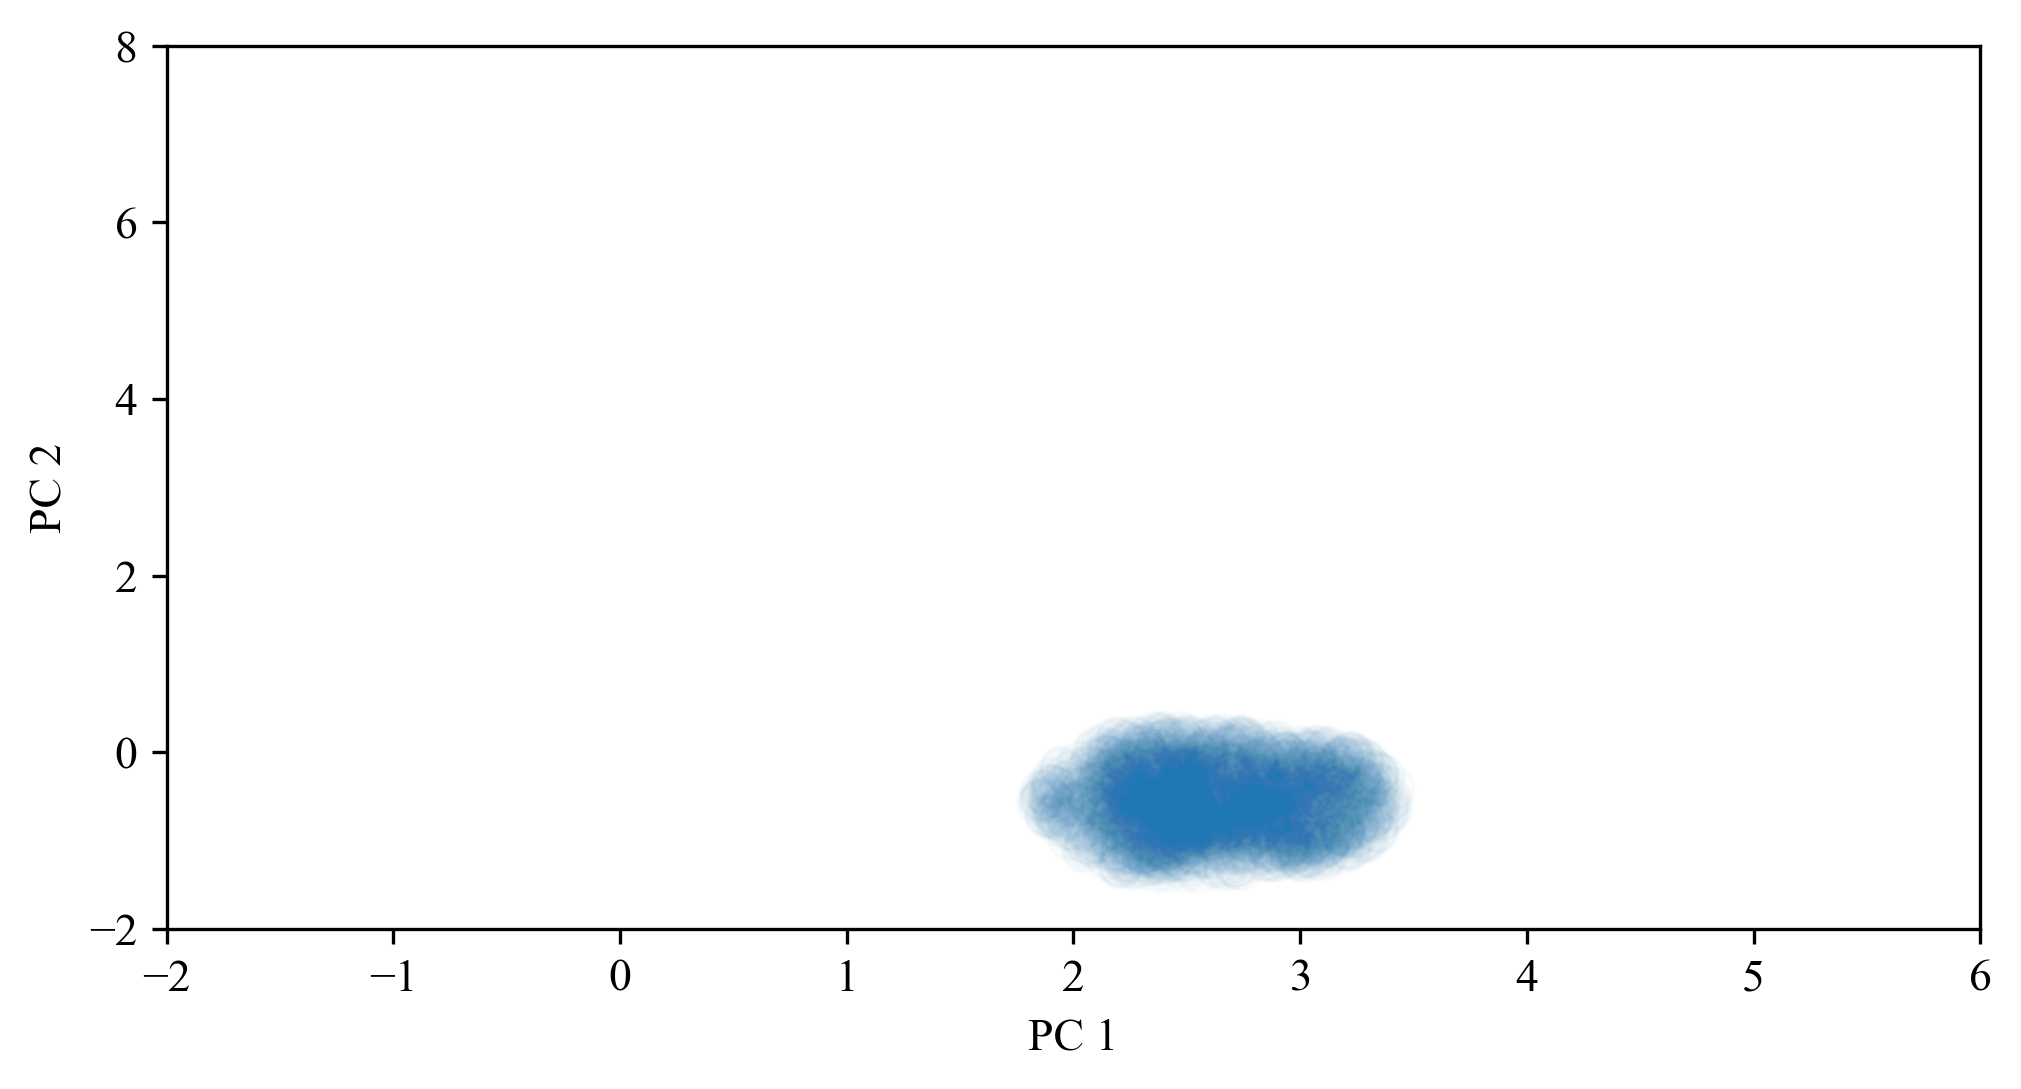

In [18]:
fig, ax = plt.subplots()
ax.scatter(phase3_trans[:,0][labels3 == 2], phase3_trans[:,1][labels3 == 2], s=100, alpha=0.02)
ax.set_xlim((-2,6))
ax.set_ylim((-2,8))
ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')

### Plot RMSI + Cluster

### All Time

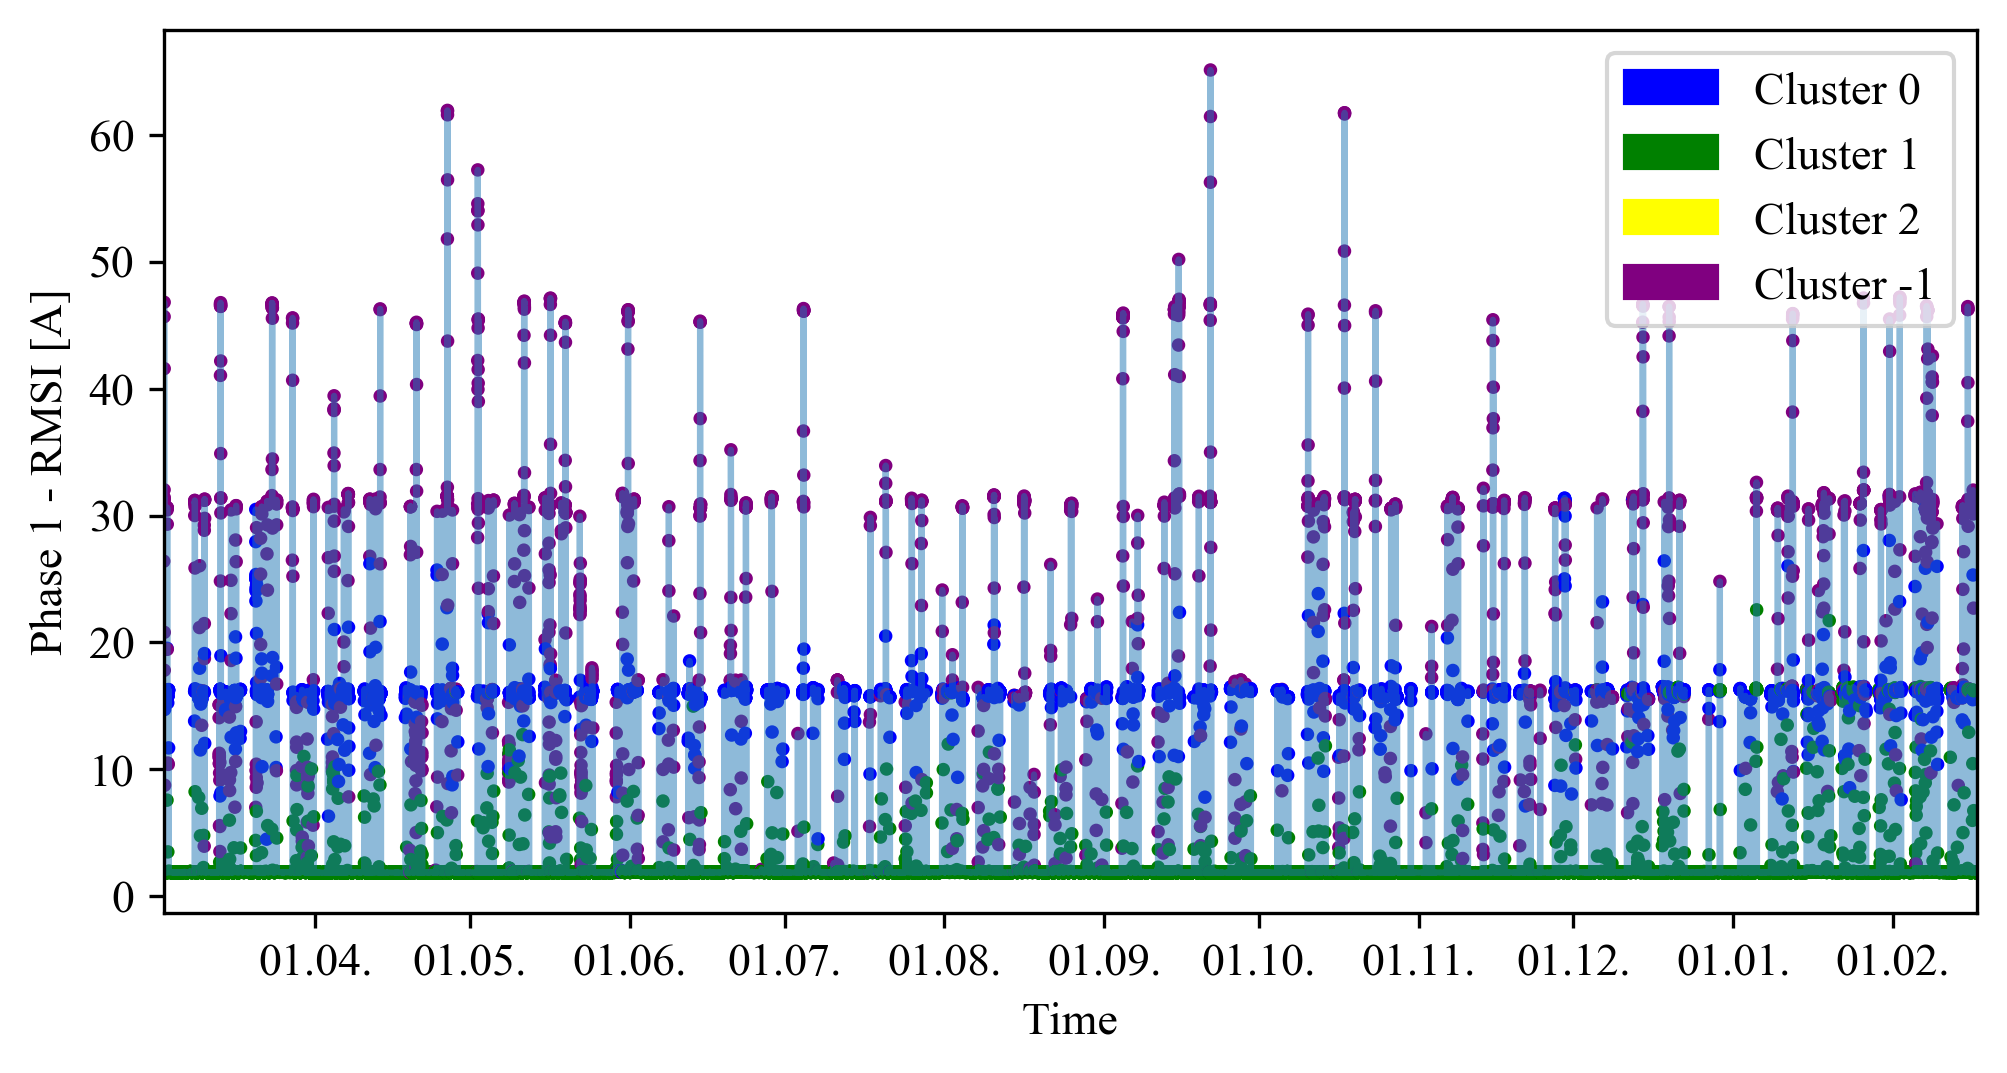

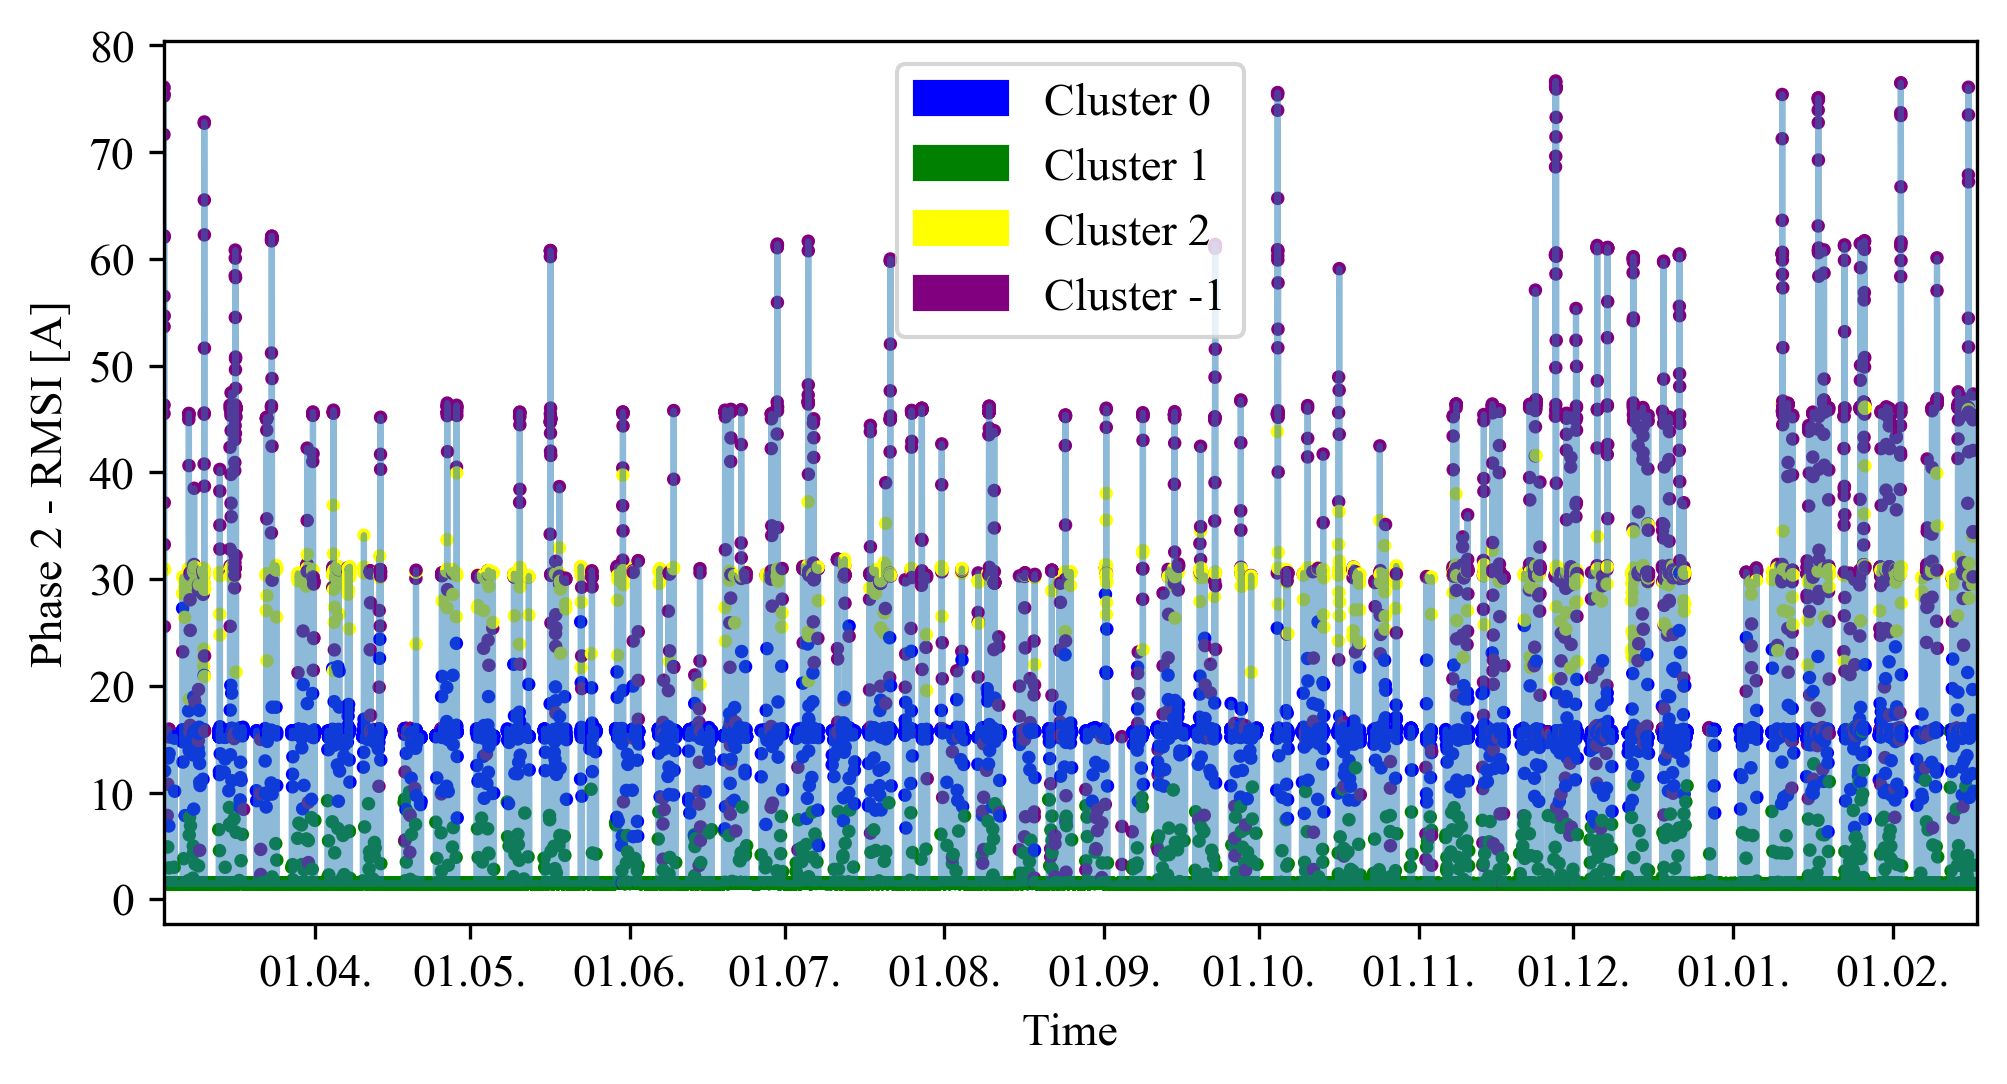

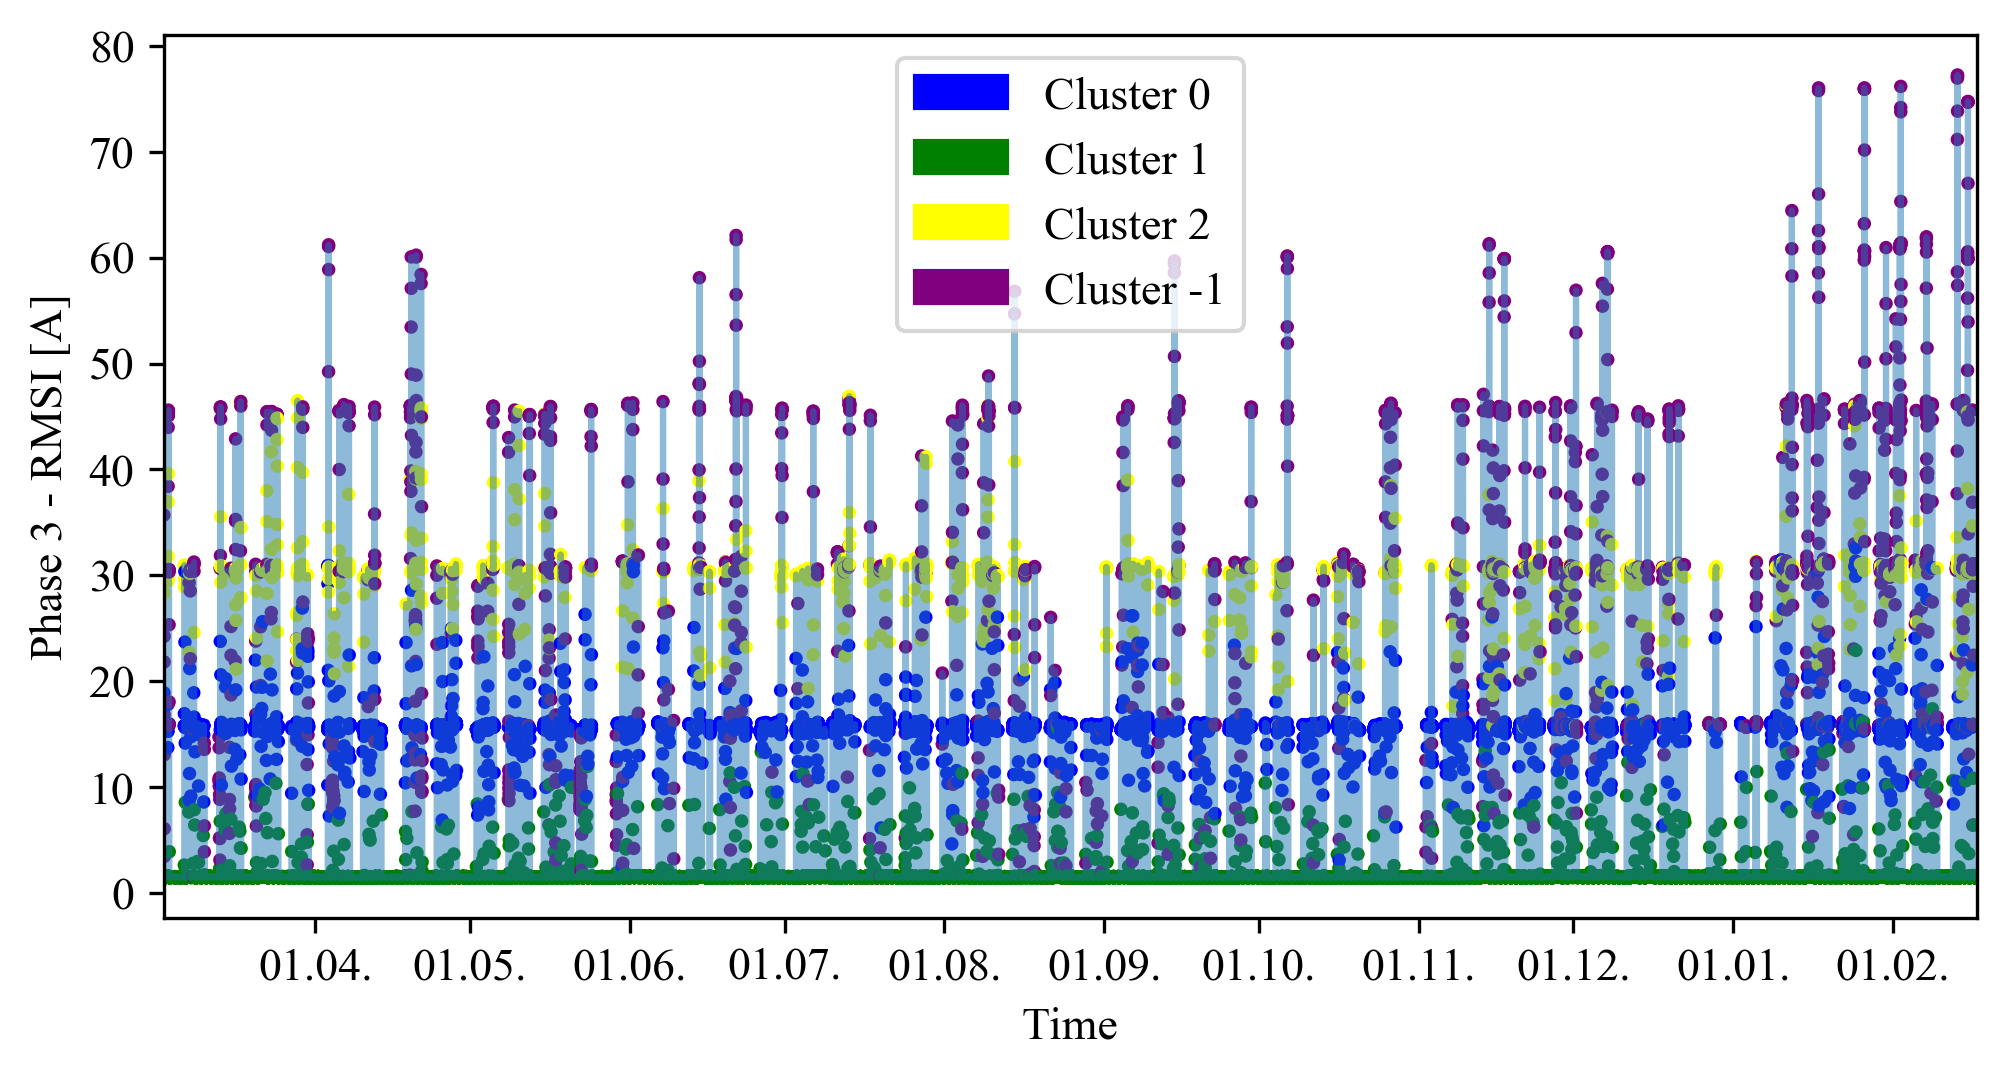

In [26]:
fig, ax = plt.subplots()
ax.scatter(rmsi_all_p1.index, rmsi_all_p1.values,c=colors1, s=5)
ax.plot(rmsi_all_p1, alpha=0.5)
ax.set_ylabel('Phase 1 - RMSI [A]')
ax.set_xlim(rmsi_all_p1.index[0],rmsi_all_p1.index[-1])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax.set_xlabel('Time')
C1 = mpatches.Patch(color='green', label='Cluster 1')
C0 = mpatches.Patch(color='blue', label='Cluster 0')
C2 = mpatches.Patch(color='yellow', label='Cluster 2')
Cm1 = mpatches.Patch(color='purple', label='Cluster -1')
ax.legend(handles=[C0,C1,C2,Cm1])

fig, ax = plt.subplots()
ax.scatter(rmsi_all_p2.index, rmsi_all_p2.values,c=colors2, s=5)
ax.plot(rmsi_all_p2, alpha=0.5)
ax.set_ylabel('Phase 2 - RMSI [A]')
ax.set_xlim(rmsi_all_p2.index[0],rmsi_all_p2.index[-1])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax.set_xlabel('Time')
C1 = mpatches.Patch(color='green', label='Cluster 1')
C0 = mpatches.Patch(color='blue', label='Cluster 0')
C2 = mpatches.Patch(color='yellow', label='Cluster 2')
Cm1 = mpatches.Patch(color='purple', label='Cluster -1')
ax.legend(handles=[C0,C1,C2,Cm1])

fig, ax = plt.subplots()
ax.scatter(rmsi_all_p3.index, rmsi_all_p3.values,c=colors3, s=5)
ax.plot(rmsi_all_p3, alpha=0.5)
ax.set_ylabel('Phase 3 - RMSI [A]')
ax.set_xlim(rmsi_all_p3.index[0],rmsi_all_p3.index[-1])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax.set_xlabel('Time')
C1 = mpatches.Patch(color='green', label='Cluster 1')
C0 = mpatches.Patch(color='blue', label='Cluster 0')
C2 = mpatches.Patch(color='yellow', label='Cluster 2')
Cm1 = mpatches.Patch(color='purple', label='Cluster -1')
ax.legend(handles=[C0,C1,C2,Cm1])

In [ ]:
d = {'RMSI_p1':rmsi_all_p1.values.flatten(), 'Cluster_p1':colors1}
df = pd.DataFrame(data=d)
df.index = rmsi_all_p1.index.tz_localize(None)
df.to_excel("4-19.xlsx")

In [118]:
d = {'RMSI_p2':rmsi_all_p2.values.flatten(), 'Cluster_p2':colors2}
df = pd.DataFrame(data=d)
df.index = rmsi_all_p2.index.tz_localize(None)
df.to_excel("4-20.xlsx")

In [119]:
d = {'RMSI_p3':rmsi_all_p3.values.flatten(), 'Cluster_p3':colors3}
df = pd.DataFrame(data=d)
df.index = rmsi_all_p3.index.tz_localize(None)
df.to_excel("4-21.xlsx")

### Just few days

In [120]:
d = {'RMSI_p1':rmsi_all_p1.values[startsample:endsample].flatten(), 'Cluster_p1':colors1[startsample:endsample]}
df = pd.DataFrame(data=d)
df.index = rmsi_all_p1.index[startsample:endsample].tz_localize(None)
df.to_excel("4-22.xlsx")

In [121]:
d = {'RMSI_p2':rmsi_all_p2.values[startsample:endsample].flatten(), 'Cluster_p2':colors2[startsample:endsample]}
df = pd.DataFrame(data=d)
df.index = rmsi_all_p2.index[startsample:endsample].tz_localize(None)
df.to_excel("4-23.xlsx")

In [122]:
d = {'RMSI_p3':rmsi_all_p3.values[startsample:endsample].flatten(), 'Cluster_p3':colors3[startsample:endsample]}
df = pd.DataFrame(data=d)
df.index = rmsi_all_p3.index[startsample:endsample].tz_localize(None)
df.to_excel("4-24.xlsx")

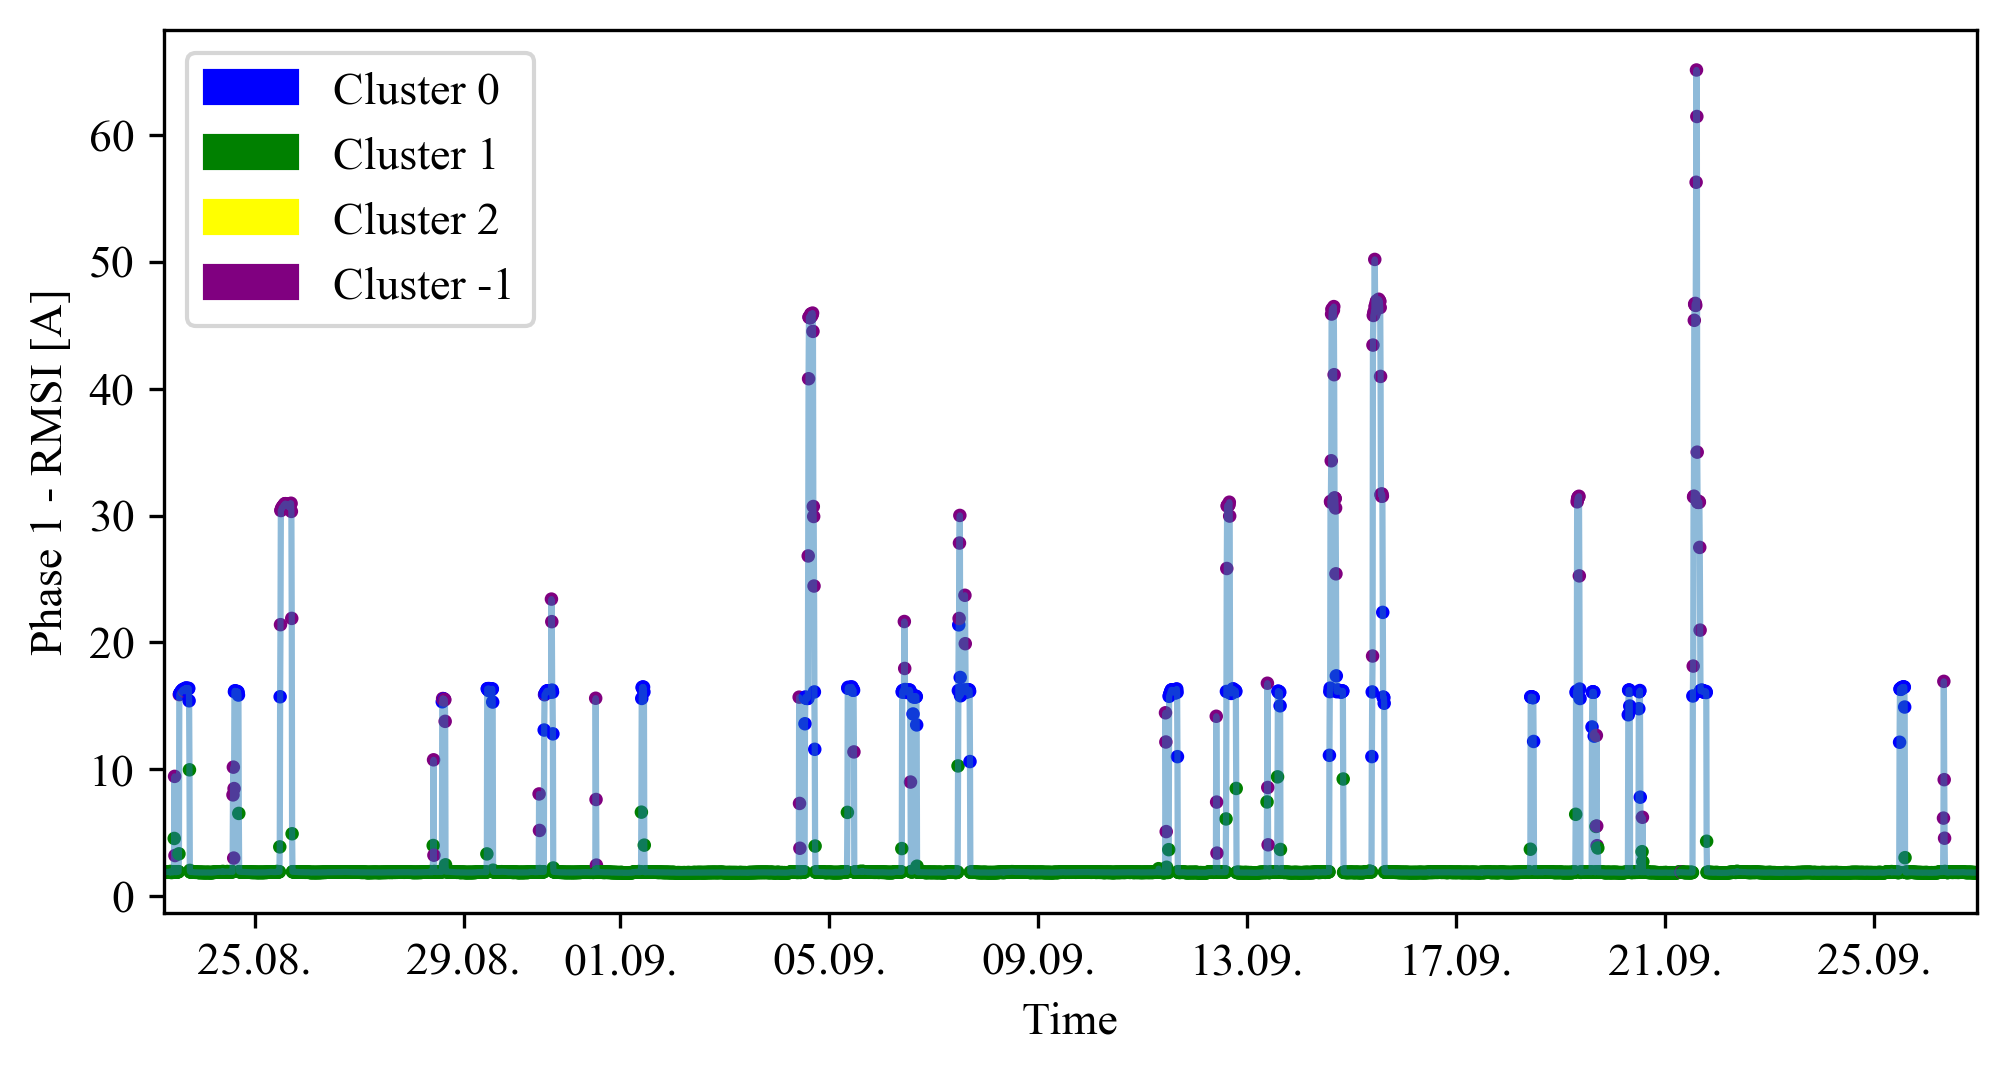

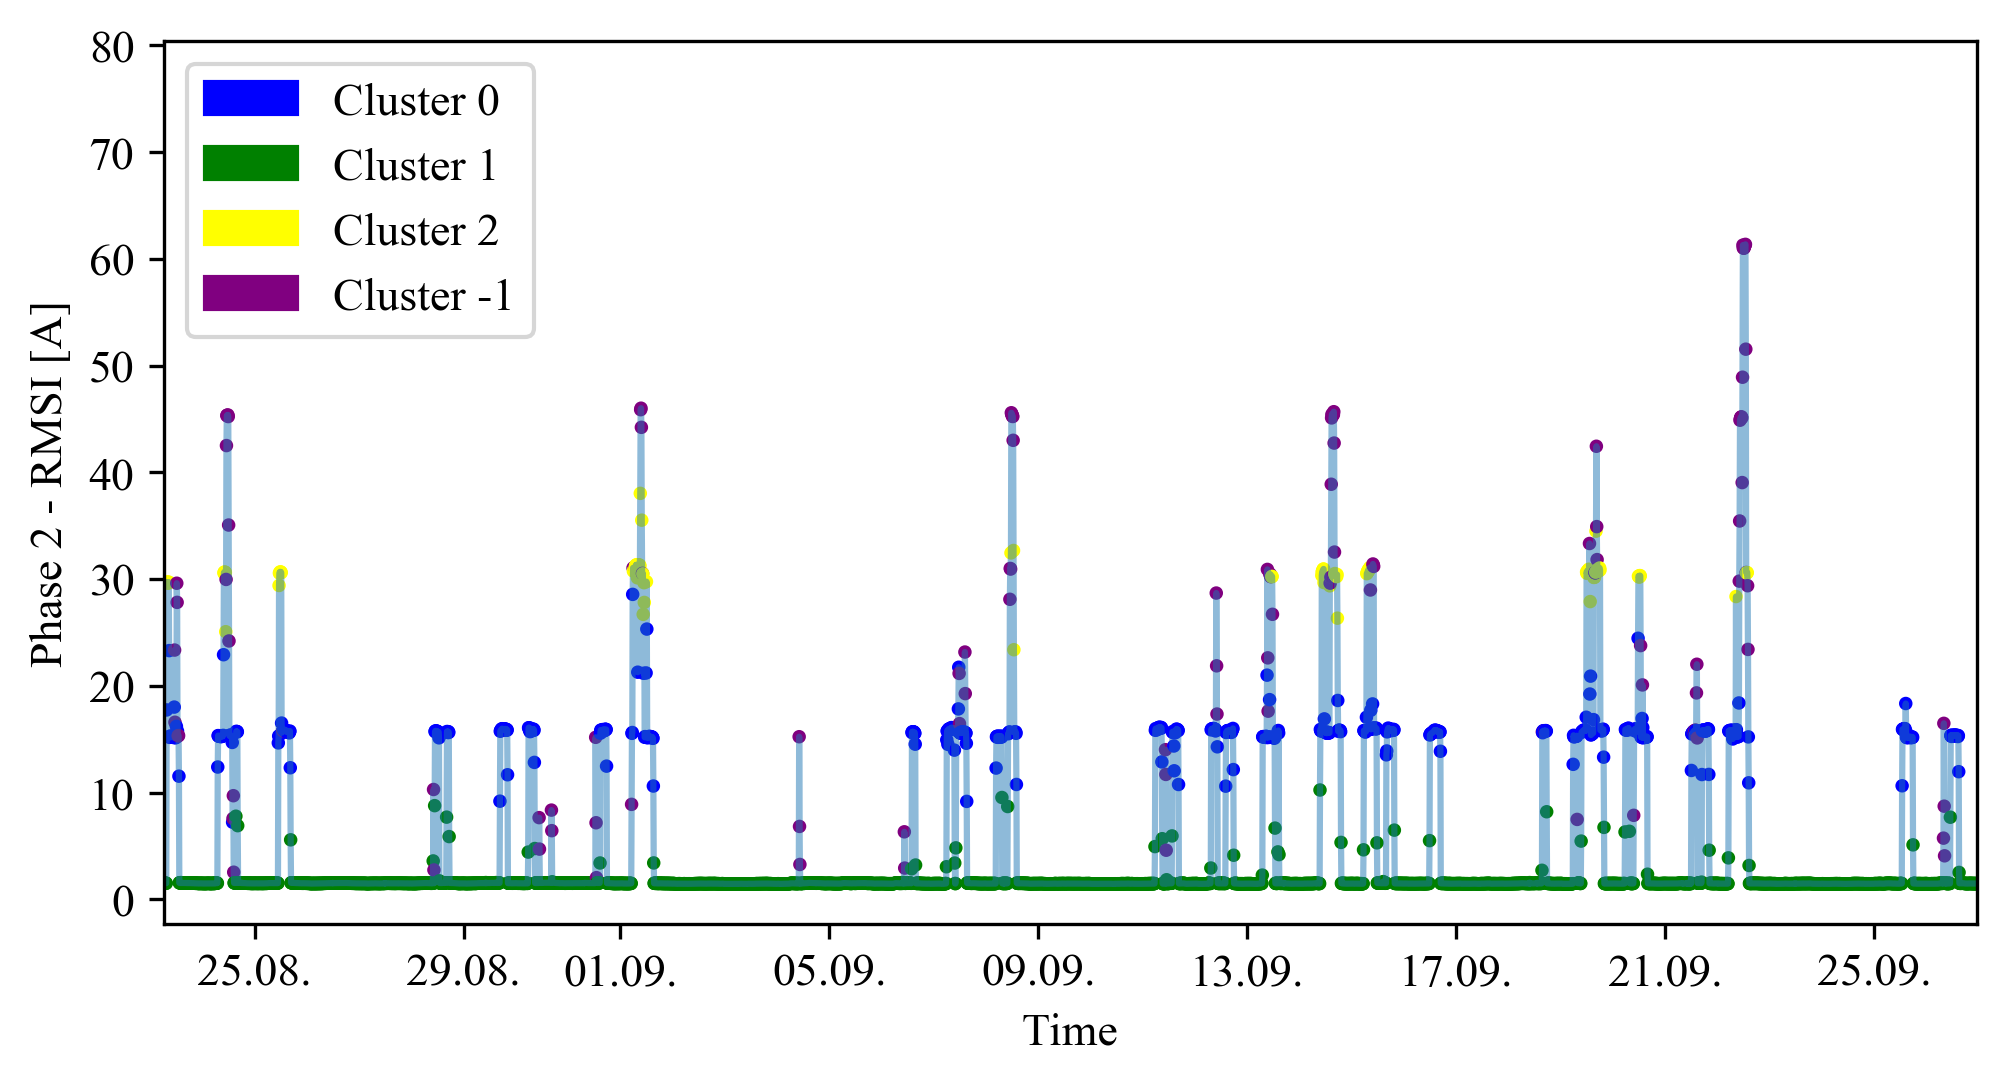

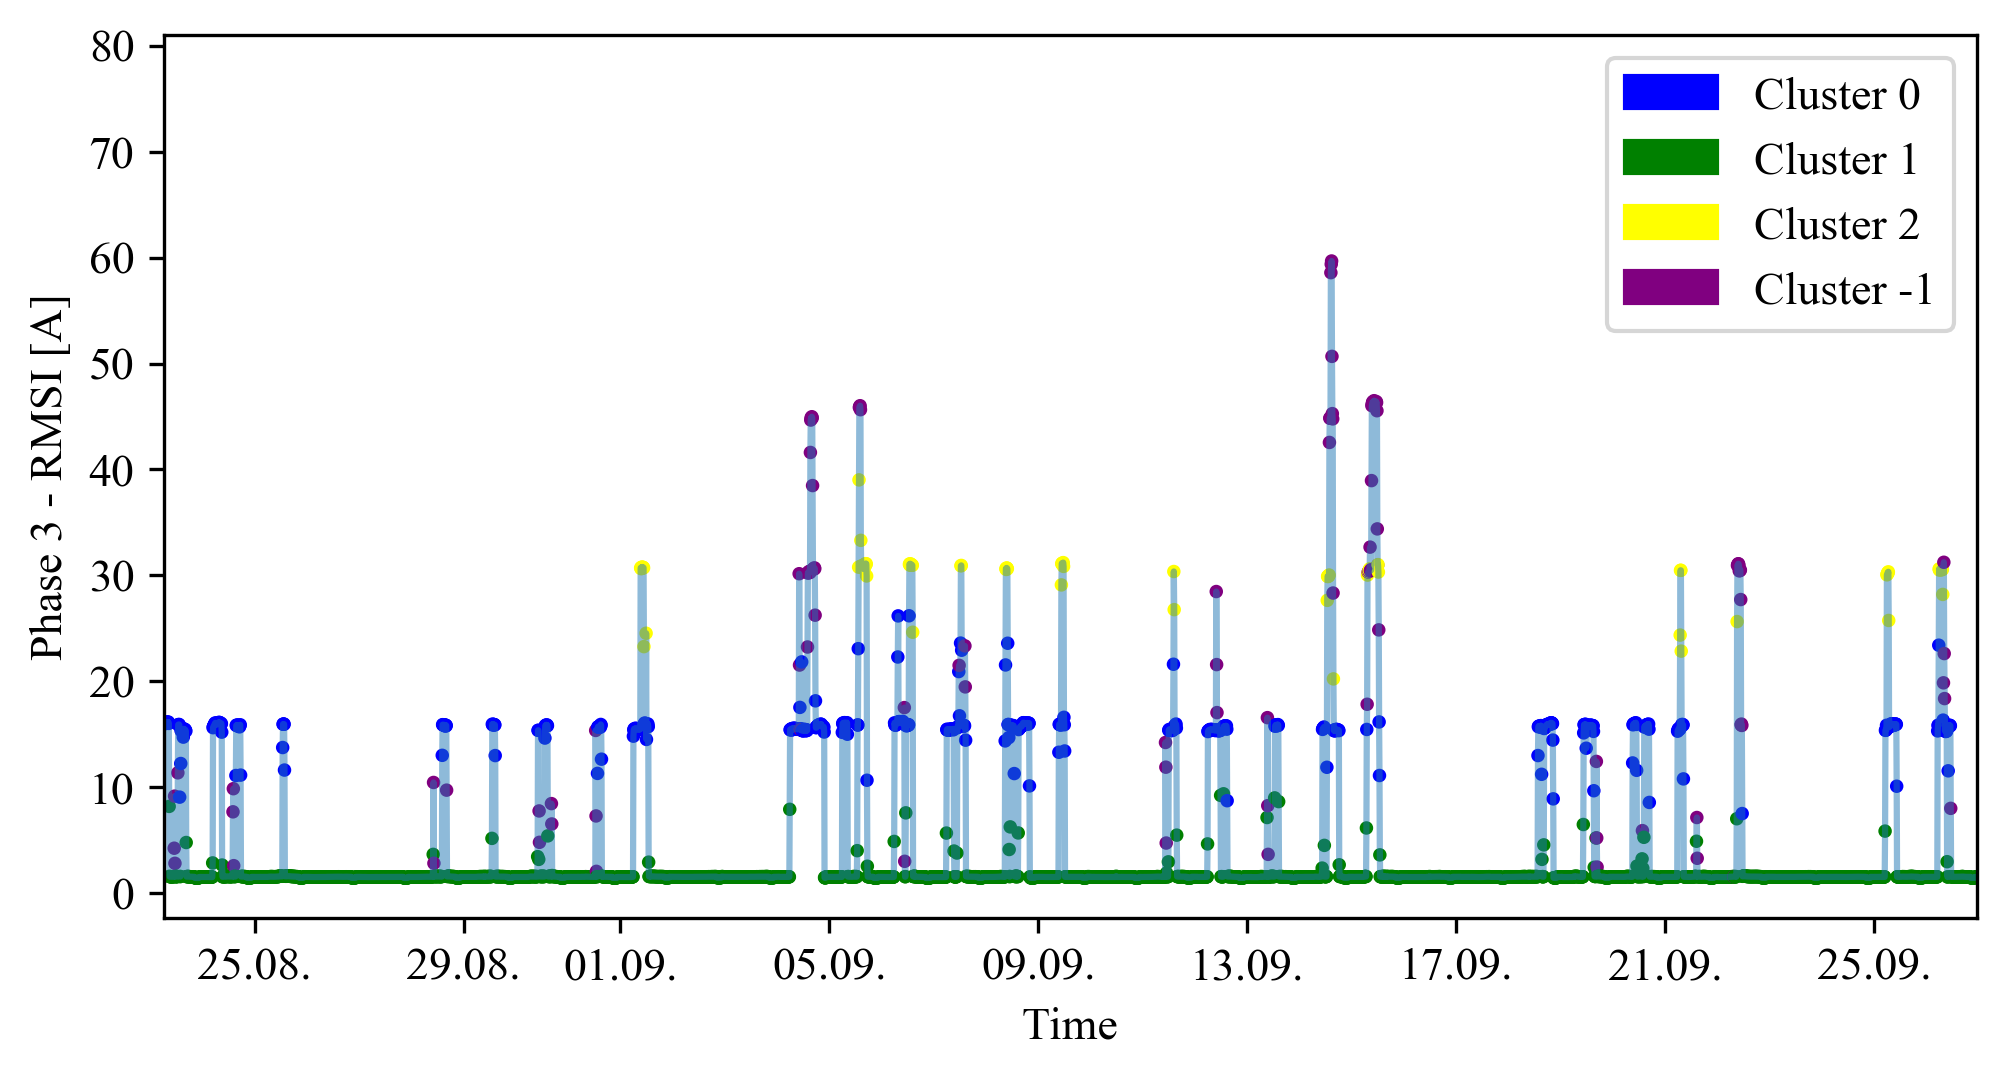

In [34]:
import matplotlib.patches as mpatches
startsample = 25000
endsample = 30000

fig, ax = plt.subplots()
scatter = ax.scatter(rmsi_all_p1.index[startsample:endsample], rmsi_all_p1.values[startsample:endsample],c=colors1[startsample:endsample], s=5)
ax.plot(rmsi_all_p1, alpha=0.5)
ax.set_ylabel('Phase 1 - RMSI [A]')
ax.set_xlim(rmsi_all_p1.index[startsample],rmsi_all_p1.index[endsample])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax.set_xlabel('Time')
C1 = mpatches.Patch(color='green', label='Cluster 1')
C0 = mpatches.Patch(color='blue', label='Cluster 0')
C2 = mpatches.Patch(color='yellow', label='Cluster 2')
Cm1 = mpatches.Patch(color='purple', label='Cluster -1')
ax.legend(handles=[C0,C1,C2,Cm1])

fig, ax = plt.subplots()
ax.scatter(rmsi_all_p2.index[startsample:endsample], rmsi_all_p2.values[startsample:endsample],c=colors2[startsample:endsample], s=5)
ax.plot(rmsi_all_p2, alpha=0.5)
ax.set_ylabel('Phase 2 - RMSI [A]')
ax.set_xlim(rmsi_all_p2.index[startsample],rmsi_all_p2.index[endsample])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax.set_xlabel('Time')
C1 = mpatches.Patch(color='green', label='Cluster 1')
C0 = mpatches.Patch(color='blue', label='Cluster 0')
C2 = mpatches.Patch(color='yellow', label='Cluster 2')
Cm1 = mpatches.Patch(color='purple', label='Cluster -1')
ax.legend(handles=[C0,C1,C2,Cm1])

fig, ax = plt.subplots()
ax.scatter(rmsi_all_p3.index[startsample:endsample], rmsi_all_p3.values[startsample:endsample],c=colors3[startsample:endsample], s=5)
ax.plot(rmsi_all_p3, alpha=0.5)
ax.set_ylabel('Phase 3 - RMSI [A]')
ax.set_xlim(rmsi_all_p3.index[startsample],rmsi_all_p3.index[endsample])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
ax.set_xlabel('Time')
C1 = mpatches.Patch(color='green', label='Cluster 1')
C0 = mpatches.Patch(color='blue', label='Cluster 0')
C2 = mpatches.Patch(color='yellow', label='Cluster 2')
Cm1 = mpatches.Patch(color='purple', label='Cluster -1')
ax.legend(handles=[C0,C1,C2,Cm1])

## Calculate Footprints

### Phase 1

In [105]:
p1_bucket1 = pd.read_excel('MeanPhase1_Bucket1.xlsx')
p1_bucket2 = pd.read_excel('MeanPhase1_Bucket2.xlsx')
p1_bucket3 = pd.read_excel('MeanPhase1_Bucket3.xlsx')
p1_bucket4 = pd.read_excel('MeanPhase1_Bucket4.xlsx')

In [39]:
p1_c1 = shi_all_p1[labels1 == 1]
p1_c0 = shi_all_p1[labels1 == 0]
p1_cm1 = shi_all_p1[labels1 == -1]

In [88]:
p1_c1_mean = np.mean(p1_c1, axis=0)
p1_c0_mean = np.mean(p1_c0, axis=0)
p1_cm1_mean = np.mean(p1_cm1, axis=0)
p1_c1_mean_db = levels_dbmyA(p1_c1_mean.to_numpy(dtype=np.float32))
p1_c0_mean_db = levels_dbmyA(p1_c0_mean.to_numpy(dtype=np.float32))
p1_cm1_mean_db = levels_dbmyA(p1_cm1_mean.to_numpy(dtype=np.float32))


x = generateXAxisData()/1000
d = {'c1': p1_c1_mean_db,'c0': p1_c0_mean_db,'cm1': p1_cm1_mean_db }
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("clusterPhase1.xlsx")

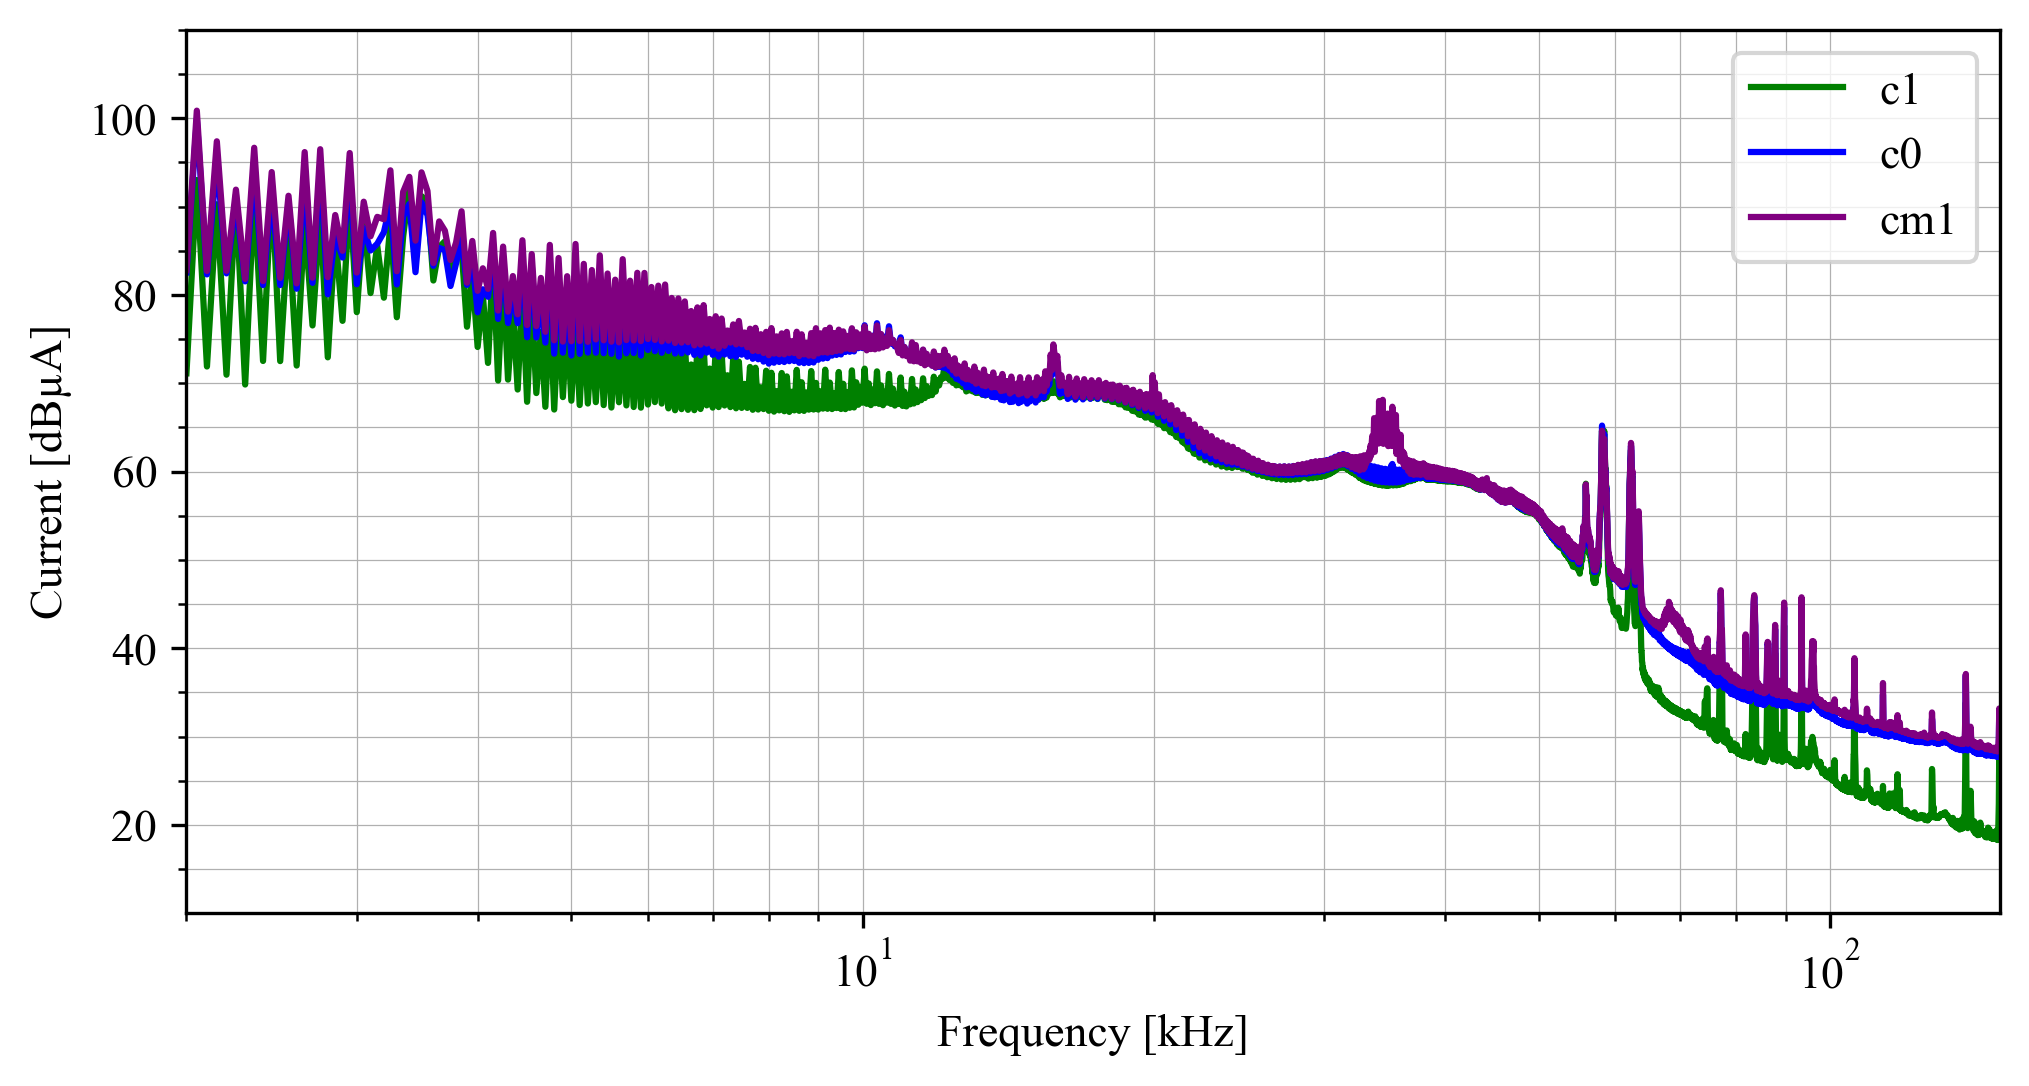

In [111]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p1_c1_mean_db, label ="c1", c='green')
ax.plot(x, p1_c0_mean_db, label ="c0", c='blue')
ax.plot(x, p1_cm1_mean_db, label ="cm1", c='purple')
ax.plot(x, p1_bucket1['p12A'], label ="Bucket 1")
ax.plot(x, p1_bucket2['p1Bucket2'], label ="Bucket 2")
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()

### Phase 2

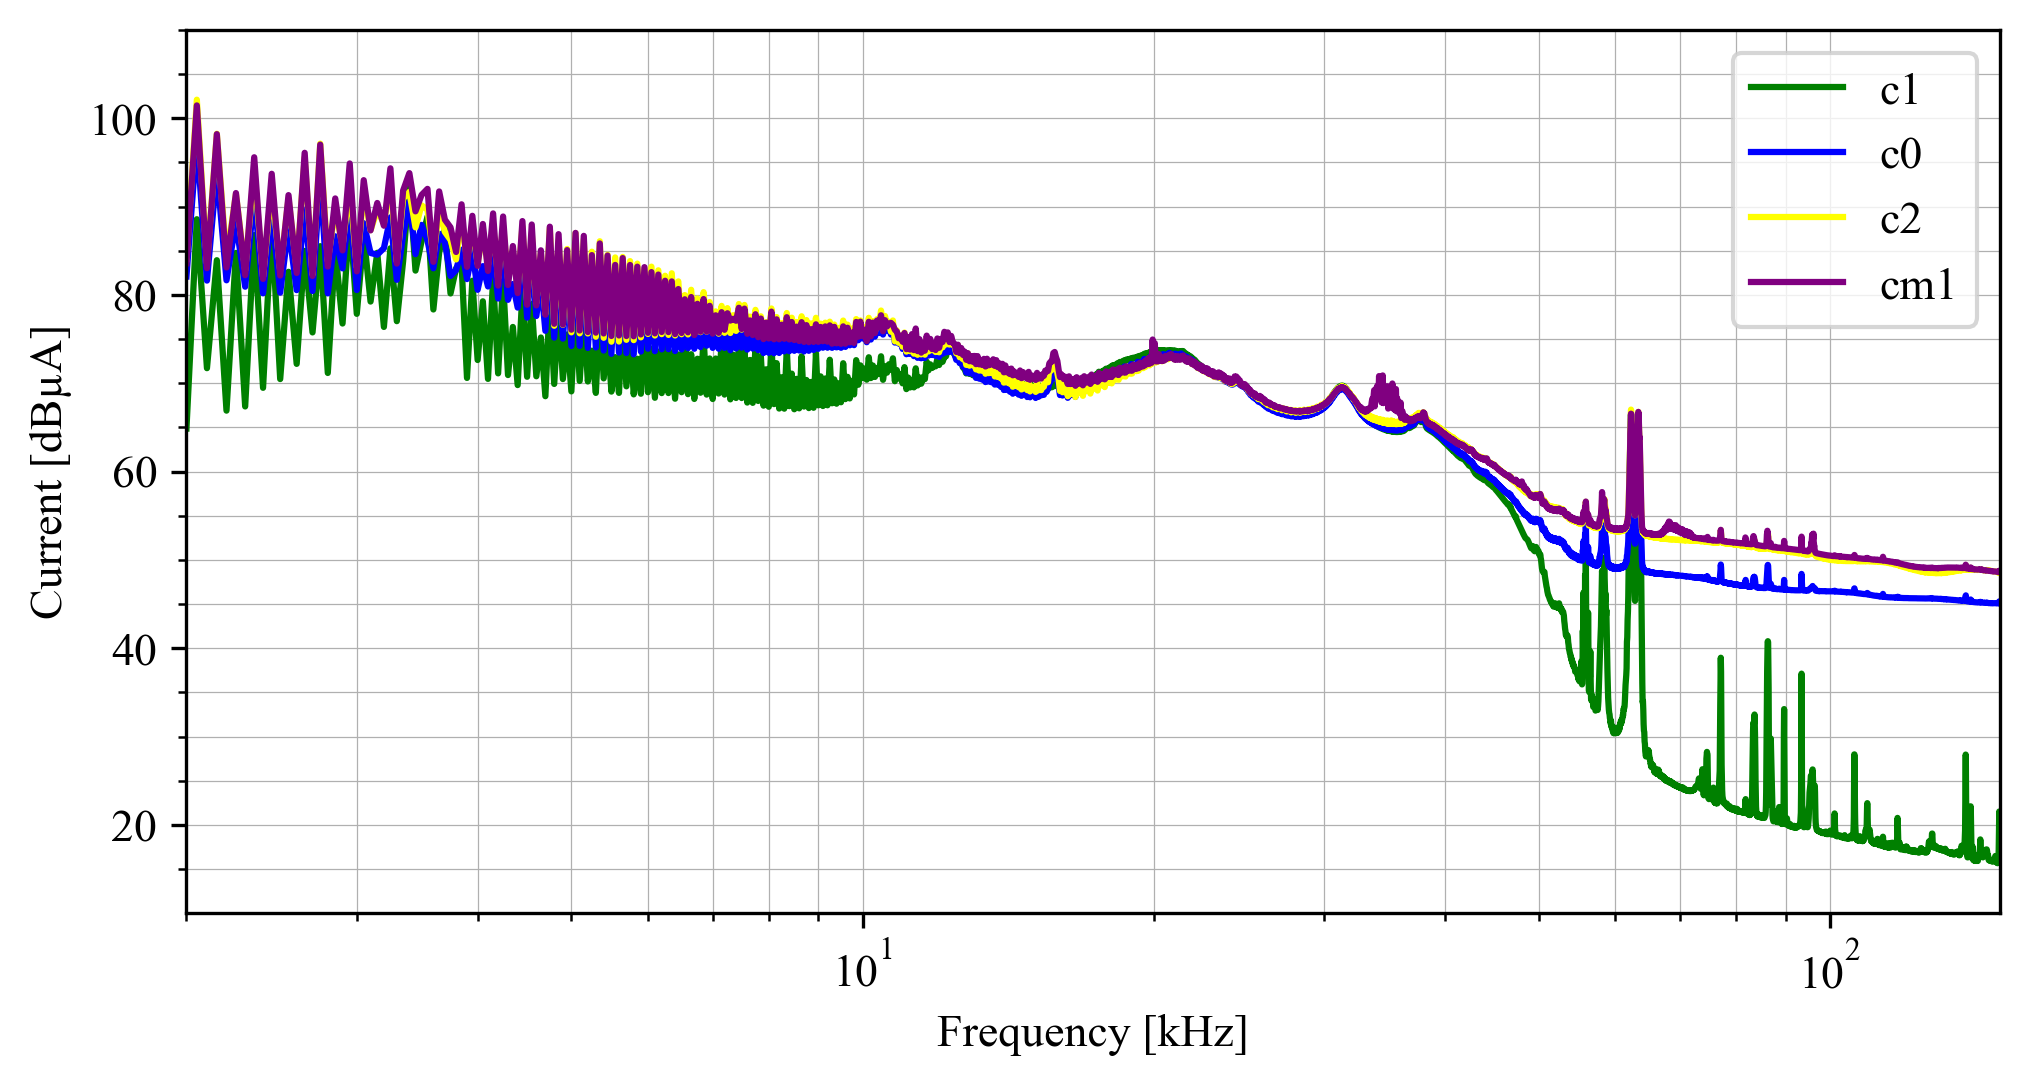

In [89]:
p2_c1 = shi_all_p2[labels2 == 1]
p2_c0 = shi_all_p2[labels2 == 0]
p2_c2 = shi_all_p2[labels2 == 2]
p2_cm1 = shi_all_p2[labels2 == -1]

p2_c1_mean = np.mean(p2_c1, axis=0)
p2_c0_mean = np.mean(p2_c0, axis=0)
p2_c2_mean = np.mean(p2_c2, axis=0)
p2_cm1_mean = np.mean(p2_cm1, axis=0)
p2_c1_mean_db = levels_dbmyA(p2_c1_mean.to_numpy(dtype=np.float32))
p2_c0_mean_db = levels_dbmyA(p2_c0_mean.to_numpy(dtype=np.float32))
p2_c2_mean_db = levels_dbmyA(p2_c2_mean.to_numpy(dtype=np.float32))
p2_cm1_mean_db = levels_dbmyA(p2_cm1_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000
d = {'c1': p2_c1_mean_db,'c0': p2_c0_mean_db,'cm1': p2_cm1_mean_db,'c2': p2_c2_mean_db }
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("clusterPhase2.xlsx")

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p2_c1_mean_db, label ="c1", c='green')
ax.plot(x, p2_c0_mean_db, label ="c0", c='blue')
ax.plot(x, p2_c2_mean_db, label ="c2", c='yellow')
ax.plot(x, p2_cm1_mean_db, label ="cm1", c='purple')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()

### Phase 3

In [102]:
p3_bucket1 = pd.read_excel('MeanPhase1_Bucket1.xlsx')
p3_bucket2 = pd.read_excel('MeanPhase1_Bucket2.xlsx')
p3_bucket3 = pd.read_excel('MeanPhase1_Bucket3.xlsx')
p3_bucket4 = pd.read_excel('MeanPhase1_Bucket4.xlsx')

In [104]:
p3_bucket2

Unnamed: 0  p1Bucket2
0           2.00  82.309724
1           2.05  99.411105
2           2.10  82.114527
3           2.15  94.987358
4           2.20  82.119720
...          ...        ...
2955      149.75  32.615985
2956      149.80  31.010527
2957      149.85  29.758596
2958      149.90  29.380141
2959      149.95  29.075970

[2960 rows x 2 columns]

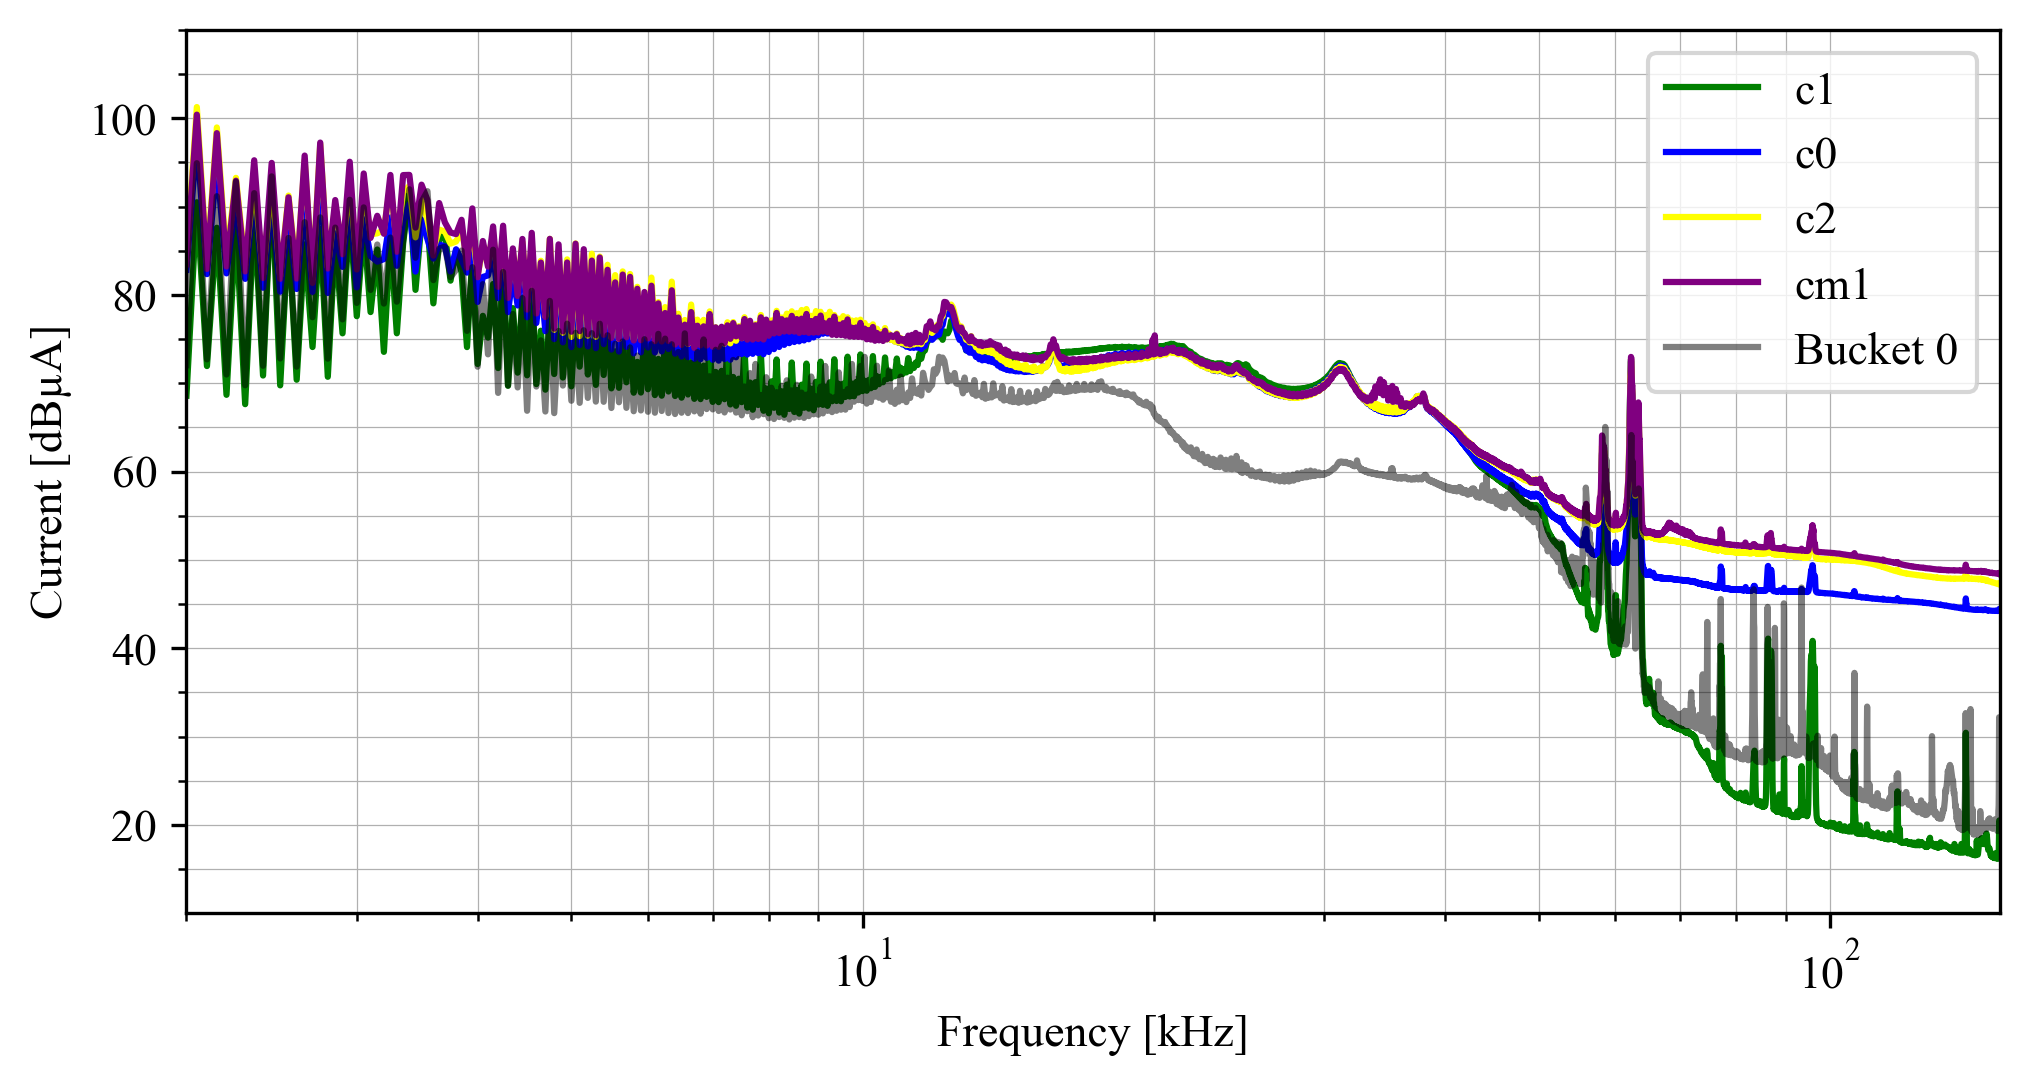

In [101]:
p3_c1 = shi_all_p3[labels3 == 1]
p3_c0 = shi_all_p3[labels3 == 0]
p3_c2 = shi_all_p3[labels3 == 2]
p3_cm1 = shi_all_p3[labels3 == -1]

p3_c1_mean = np.mean(p3_c1, axis=0)
p3_c0_mean = np.mean(p3_c0, axis=0)
p3_c2_mean = np.mean(p3_c2, axis=0)
p3_cm1_mean = np.mean(p3_cm1, axis=0)
p3_c1_mean_db = levels_dbmyA(p3_c1_mean.to_numpy(dtype=np.float32))
p3_c0_mean_db = levels_dbmyA(p3_c0_mean.to_numpy(dtype=np.float32))
p3_c2_mean_db = levels_dbmyA(p3_c2_mean.to_numpy(dtype=np.float32))
p3_cm1_mean_db = levels_dbmyA(p3_cm1_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000
d = {'c1': p3_c1_mean_db,'c0': p3_c0_mean_db,'cm1': p3_cm1_mean_db,'c2': p3_c2_mean_db }
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("clusterPhase3.xlsx")

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p3_c1_mean_db, label ="c1", c='green')
ax.plot(x, p3_c0_mean_db, label ="c0", c='blue')
ax.plot(x, p3_c2_mean_db, label ="c2", c='yellow')
ax.plot(x, p3_cm1_mean_db, label ="cm1", c='purple')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()

### Cluster 0

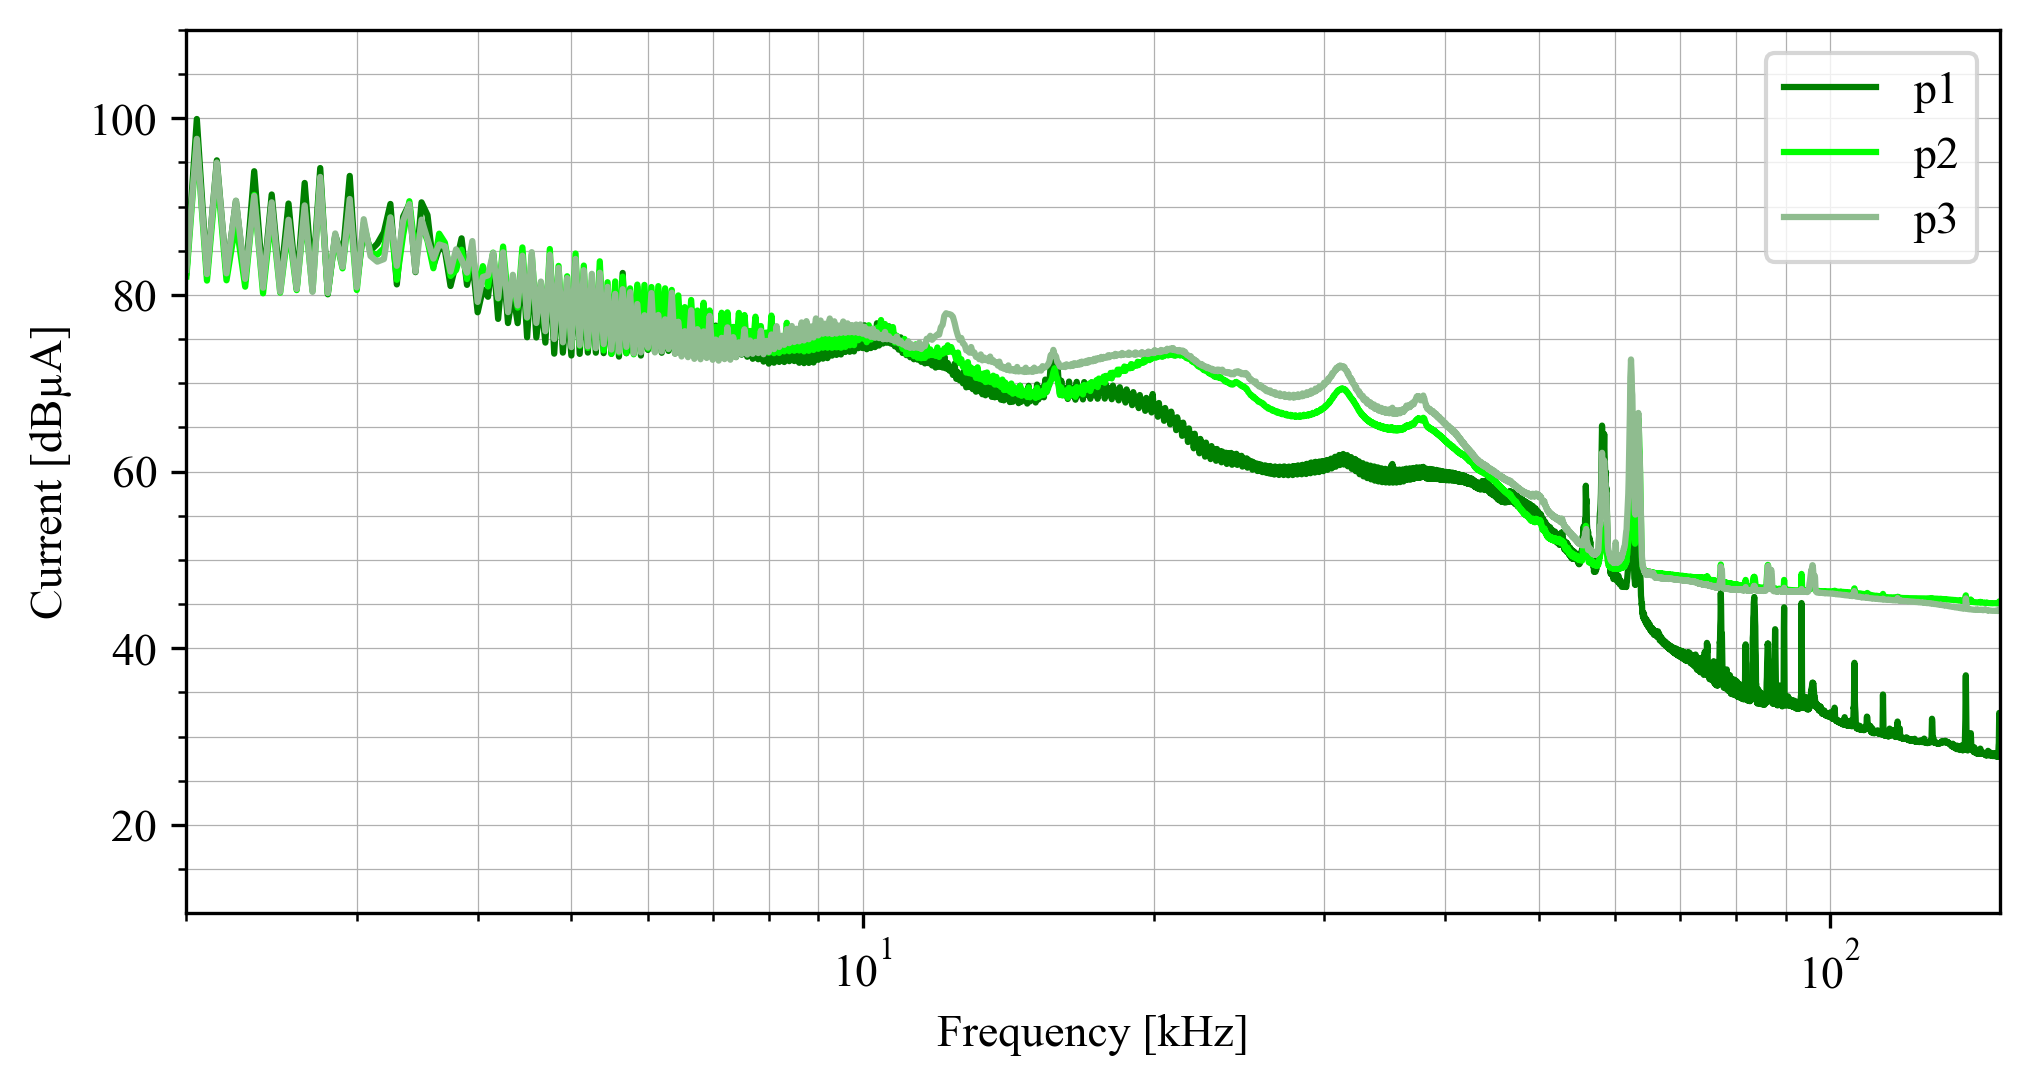

In [44]:
x = generateXAxisData()/1000
fig, ax = plt.subplots()
ax.plot(x, p1_c0_mean_db, label ="p1", c='green')
ax.plot(x, p2_c0_mean_db, label ="p2", c='lime')
ax.plot(x, p3_c0_mean_db, label ="p3", c='darkseagreen')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()

In [154]:
x = generateXAxisData()/1000
d = {'p1': p1_c0_mean_db,'p2': p2_c0_mean_db,'p3': p3_c0_mean_db }
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-32.xlsx")

### Cluster 1

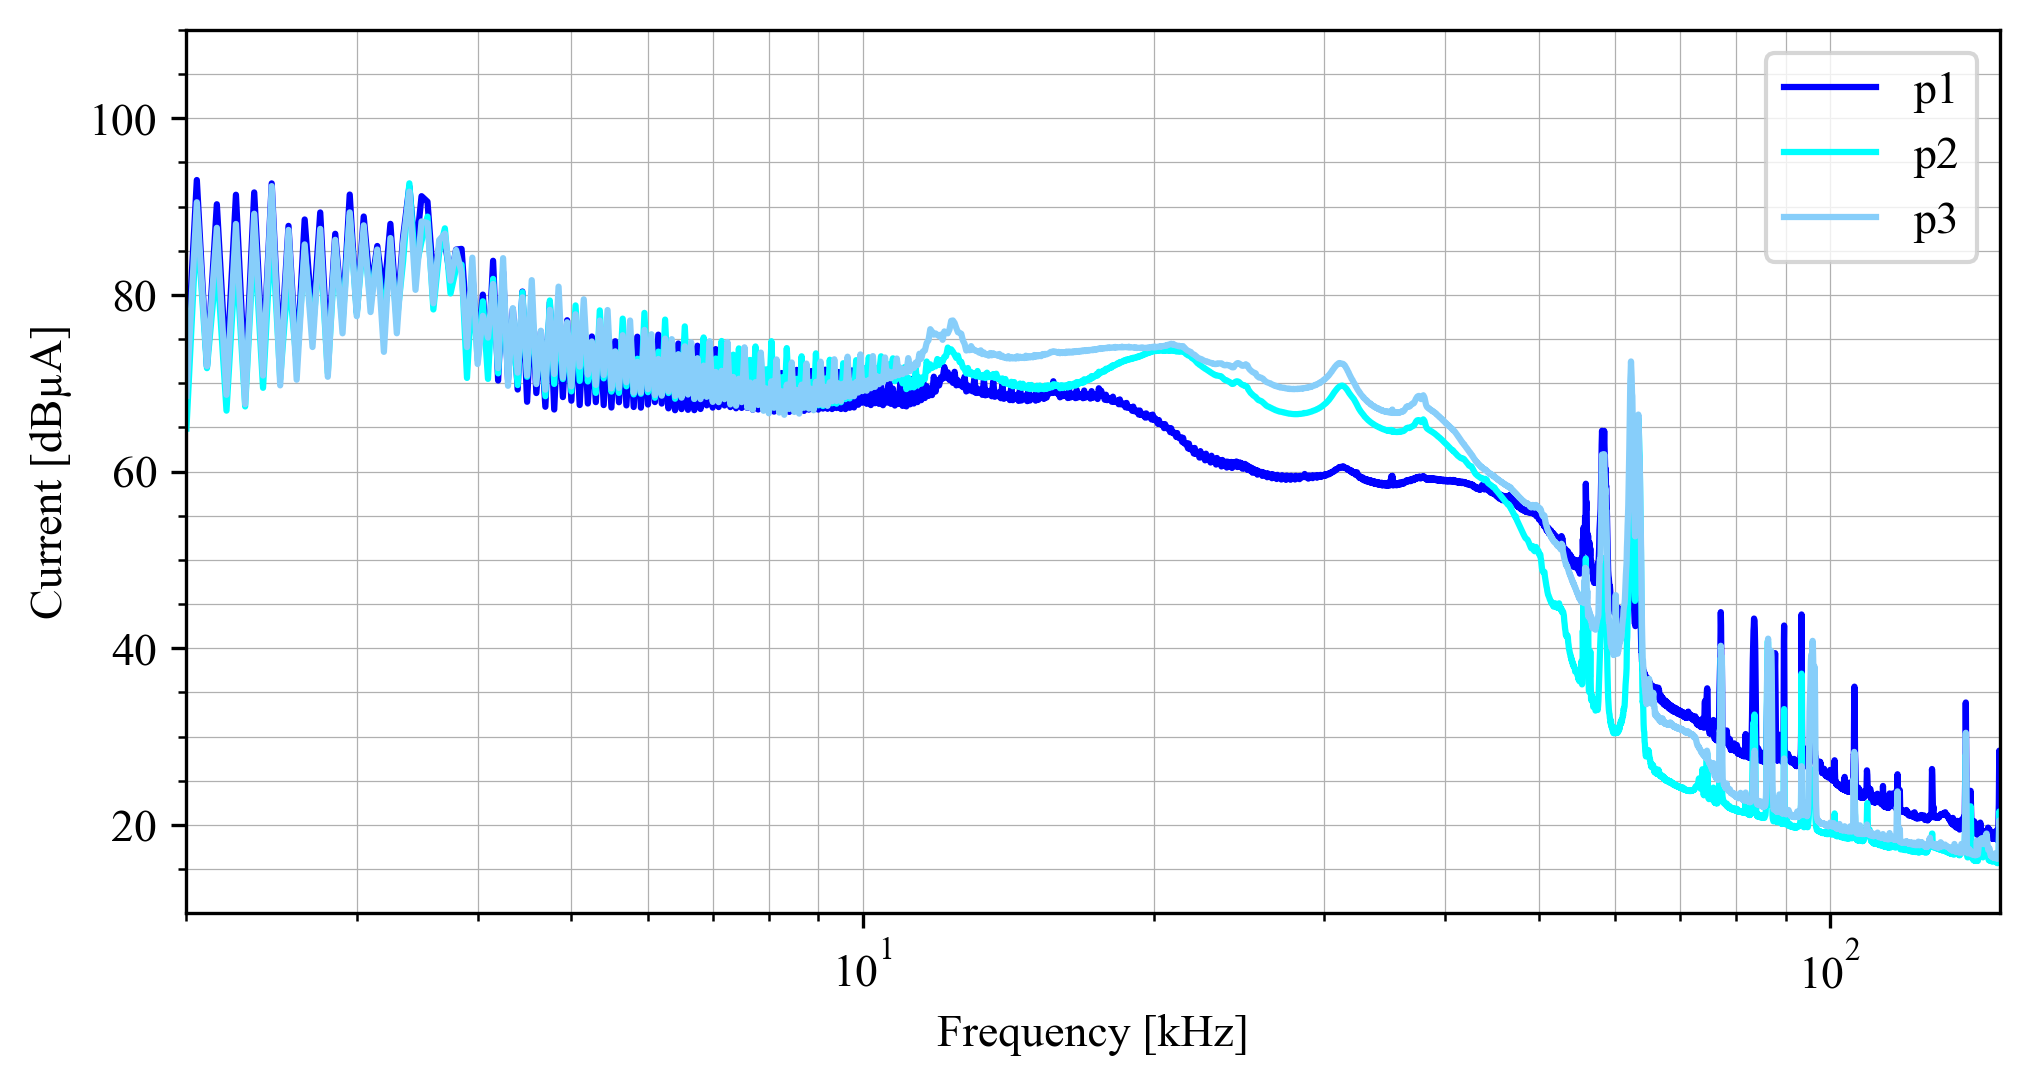

In [45]:
x = generateXAxisData()/1000
fig, ax = plt.subplots()
ax.plot(x, p1_c1_mean_db, label ="p1", c='blue')
ax.plot(x, p2_c1_mean_db, label ="p2", c='cyan')
ax.plot(x, p3_c1_mean_db, label ="p3", c='lightskyblue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()

In [155]:
x = generateXAxisData()/1000
d = {'p1': p1_c1_mean_db,'p2': p2_c1_mean_db,'p3': p3_c1_mean_db }
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-33.xlsx")

### Cluster 2

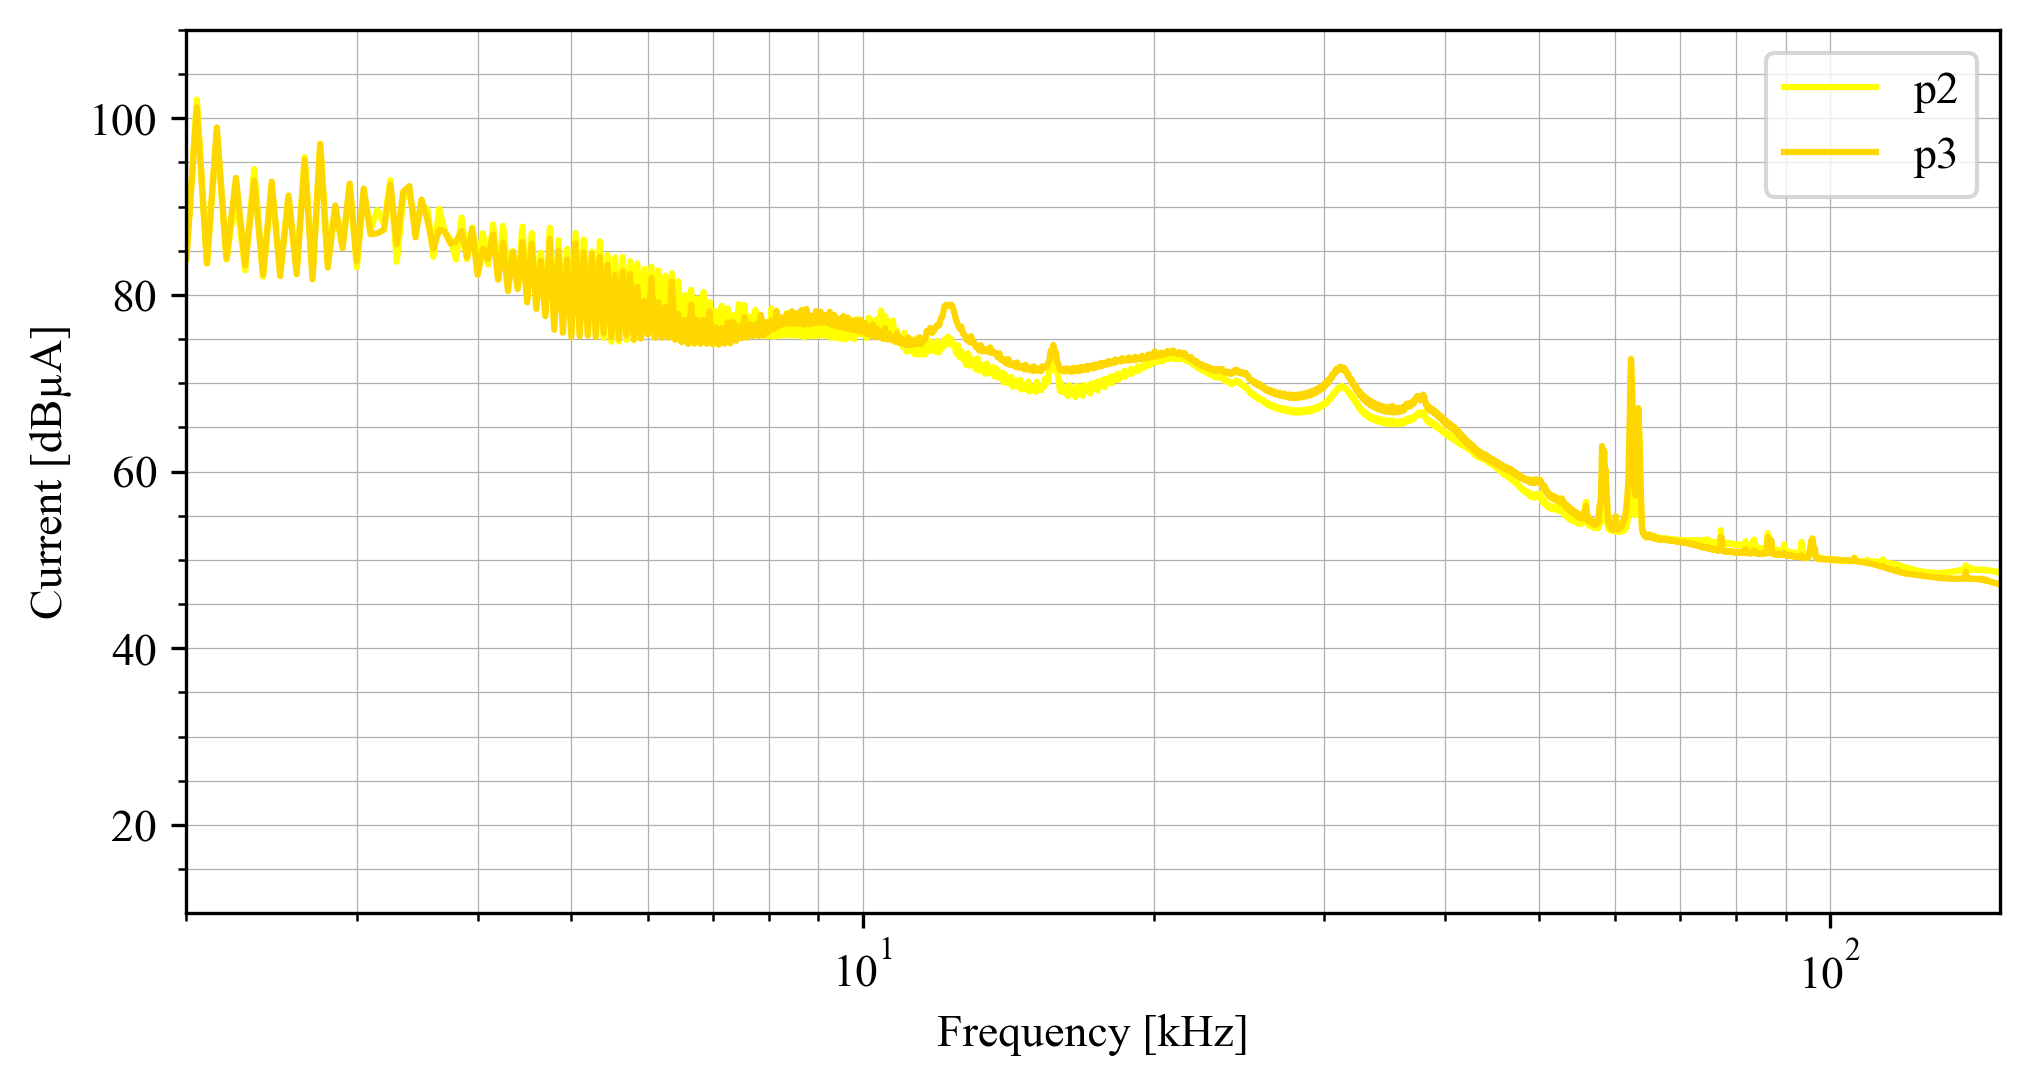

In [46]:
x = generateXAxisData()/1000
fig, ax = plt.subplots()
ax.plot(x, p2_c2_mean_db, label ="p2", c='yellow')
ax.plot(x, p3_c2_mean_db, label ="p3", c='gold')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()

In [156]:
x = generateXAxisData()/1000
d = {'p2': p2_c2_mean_db,'p3': p3_c2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-34.xlsx")

### Cluster -1

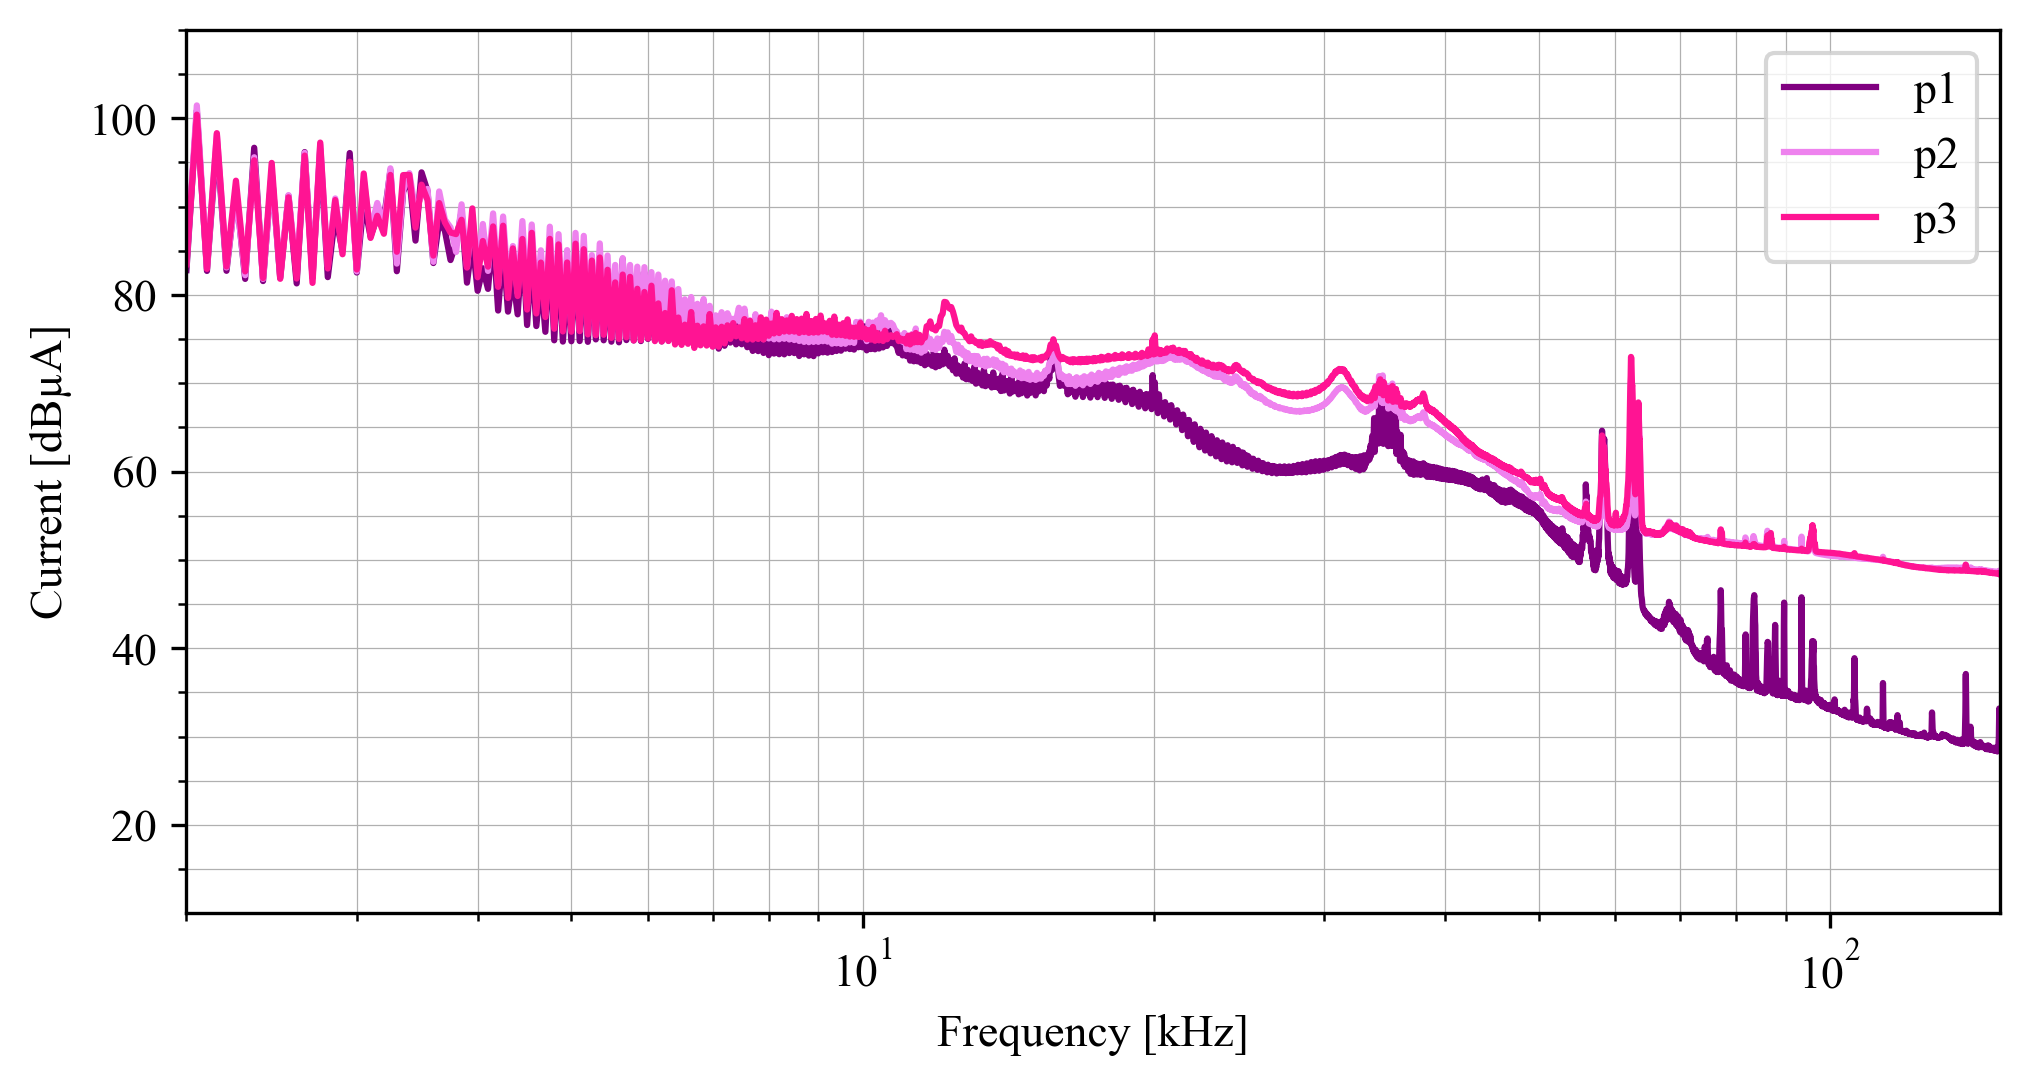

In [47]:
x = generateXAxisData()/1000
fig, ax = plt.subplots()
ax.plot(x, p1_cm1_mean_db, label ="p1", c='purple')
ax.plot(x, p2_cm1_mean_db, label ="p2", c='violet')
ax.plot(x, p3_cm1_mean_db, label ="p3", c='deeppink')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()

In [157]:
x = generateXAxisData()/1000
d = {'p1': p1_cm1_mean_db,'p2': p2_cm1_mean_db,'p3': p3_cm1_mean_db }
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-35.xlsx")

### P1 Phasenbeziehung Ladevorgänge anderer Phasen

In [48]:
p1_c1_1 = shi_all_p1[(labels1 == 1) & (labels2 != 1) & (labels3 != 1)]

In [49]:
p1_c1_2 = shi_all_p1[(labels1 == 1) & (labels2 == 1) & (labels3 == 1)]

In [50]:
p1_c1_1_mean = np.mean(p1_c1_1, axis=0)
p1_c1_2_mean = np.mean(p1_c1_2, axis=0)
p1_c1_1_mean_db = levels_dbmyA(p1_c1_1_mean.to_numpy(dtype=np.float32))
p1_c1_2_mean_db = levels_dbmyA(p1_c1_2_mean.to_numpy(dtype=np.float32))

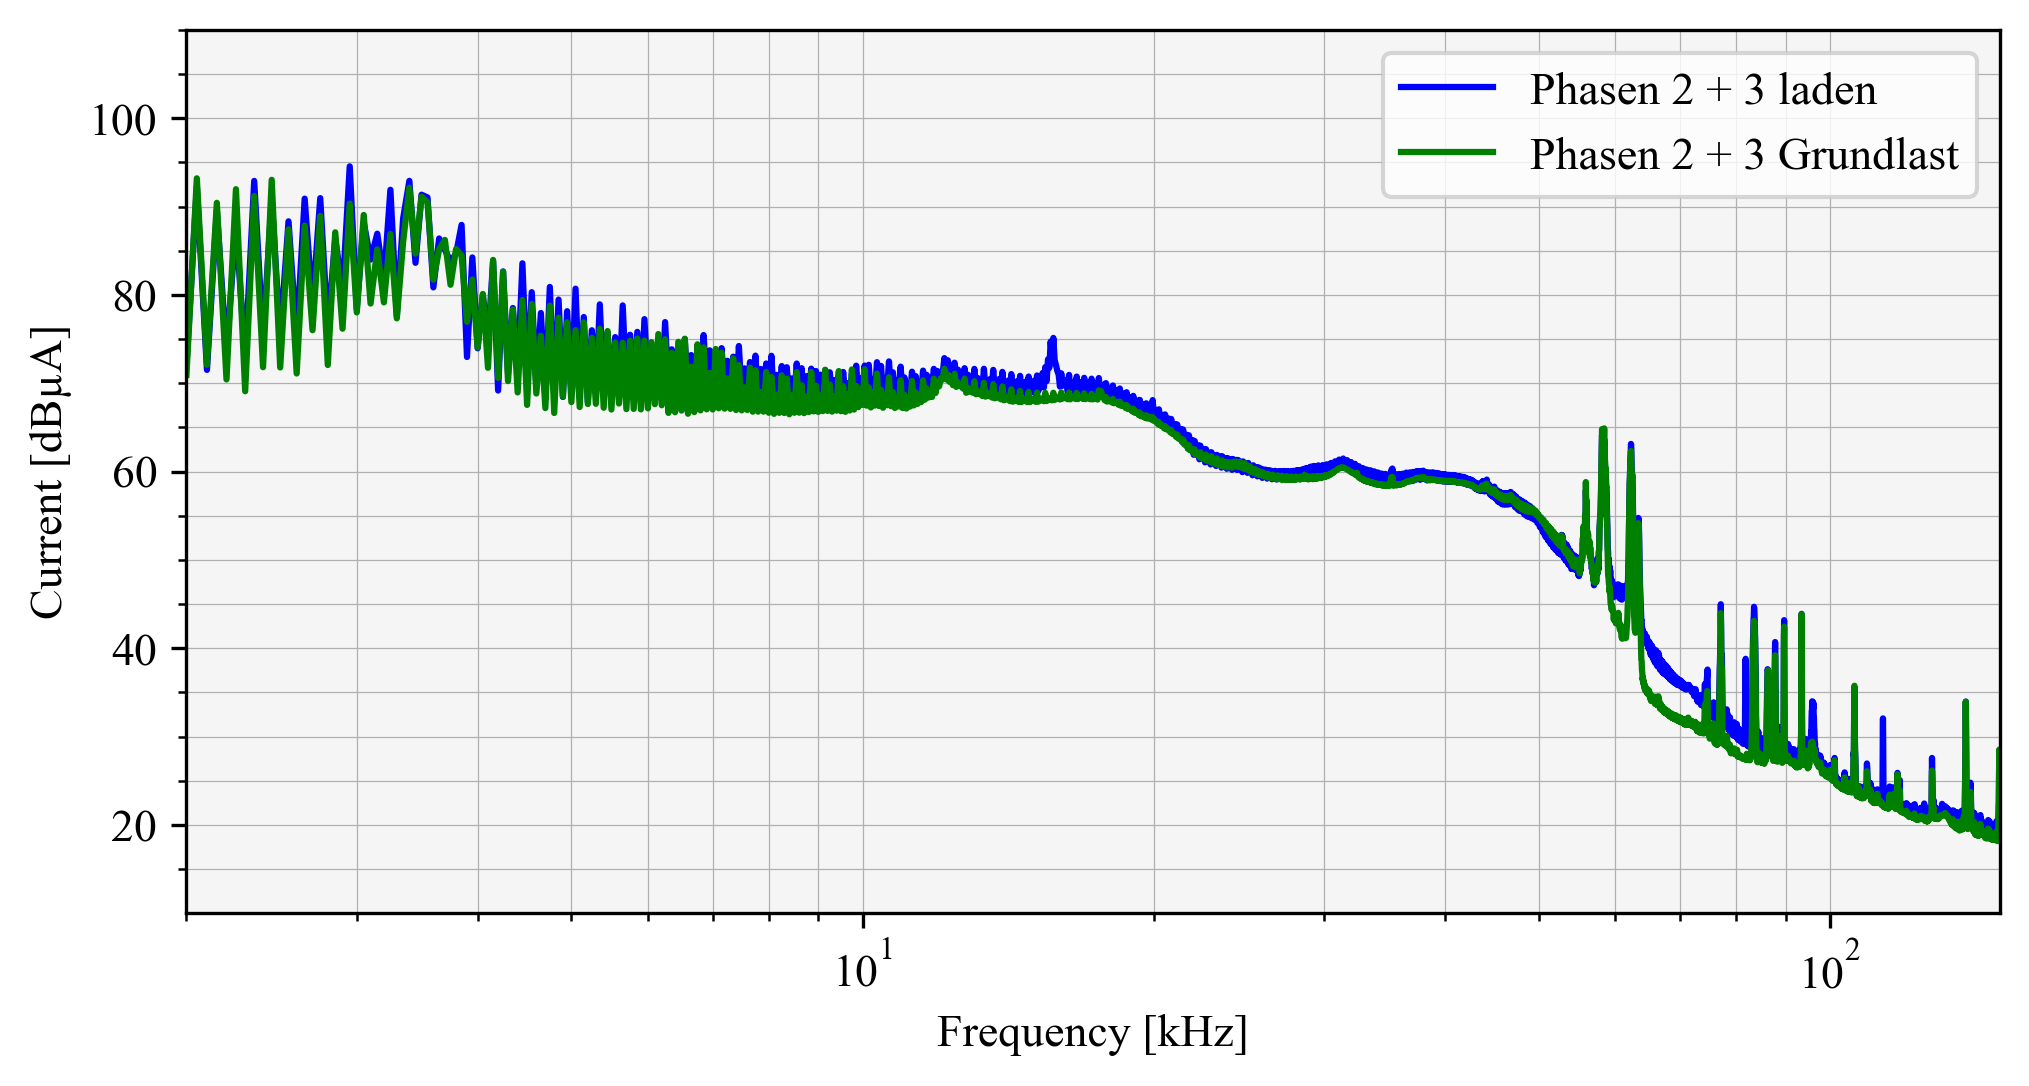

In [51]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p1_c1_1_mean_db, label ="Phasen 2 + 3 laden", c='blue')
ax.plot(x, p1_c1_2_mean_db, label ="Phasen 2 + 3 Grundlast", c='green')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('whitesmoke')

In [158]:
x = generateXAxisData()/1000
d = {'laden': p1_c1_1_mean_db,'grundlast': p1_c1_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-36.xlsx")

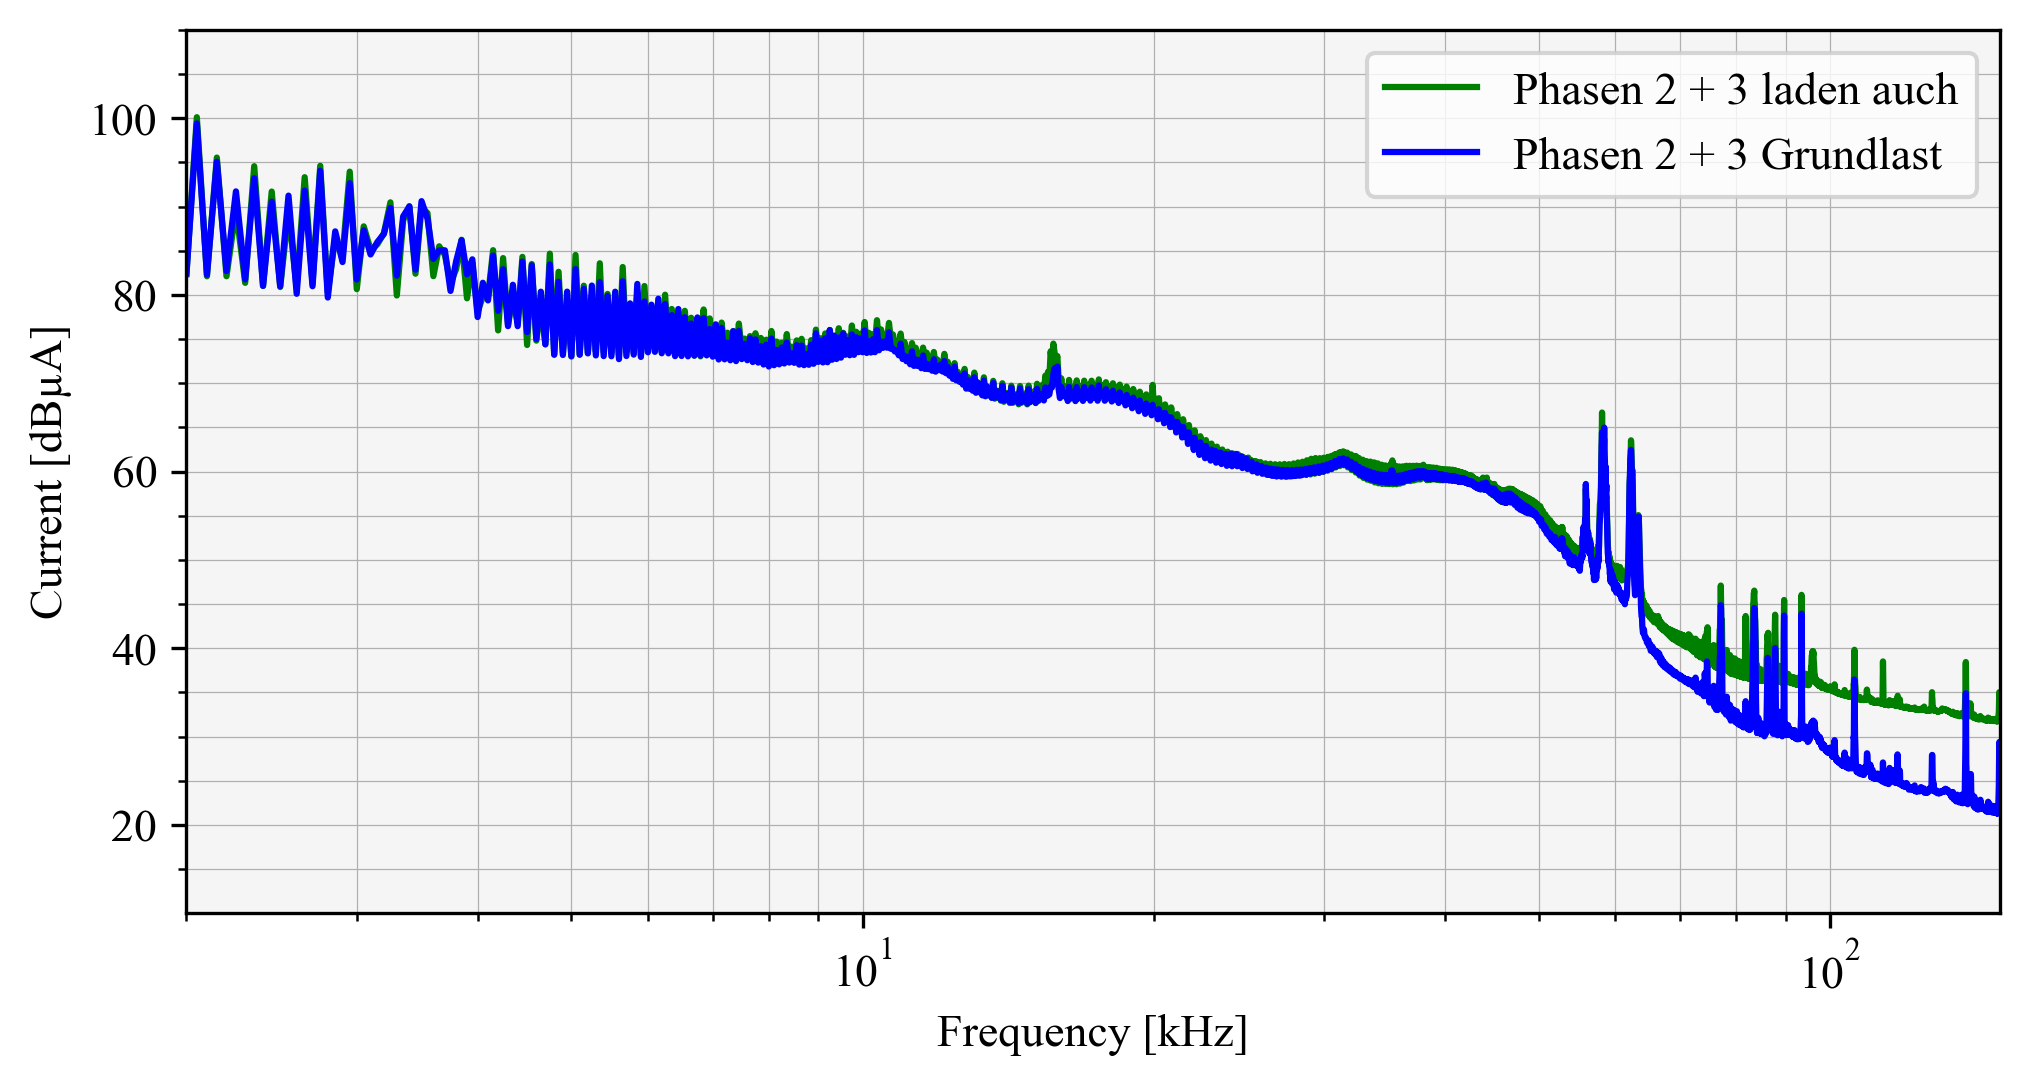

In [52]:
p1_c0_1 = shi_all_p1[(labels1 == 0) & (labels2 != 1) & (labels3 != 1)]
p1_c0_2 = shi_all_p1[(labels1 == 0) & (labels2 == 1) & (labels3 == 1)]

p1_c0_1_mean = np.mean(p1_c0_1, axis=0)
p1_c0_2_mean = np.mean(p1_c0_2, axis=0)
p1_c0_1_mean_db = levels_dbmyA(p1_c0_1_mean.to_numpy(dtype=np.float32))
p1_c0_2_mean_db = levels_dbmyA(p1_c0_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p1_c0_1_mean_db, label ="Phasen 2 + 3 laden auch", c='green')
ax.plot(x, p1_c0_2_mean_db, label ="Phasen 2 + 3 Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('whitesmoke')

In [159]:
x = generateXAxisData()/1000
d = {'laden': p1_c0_1_mean_db,'grundlast': p1_c0_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-37.xlsx")

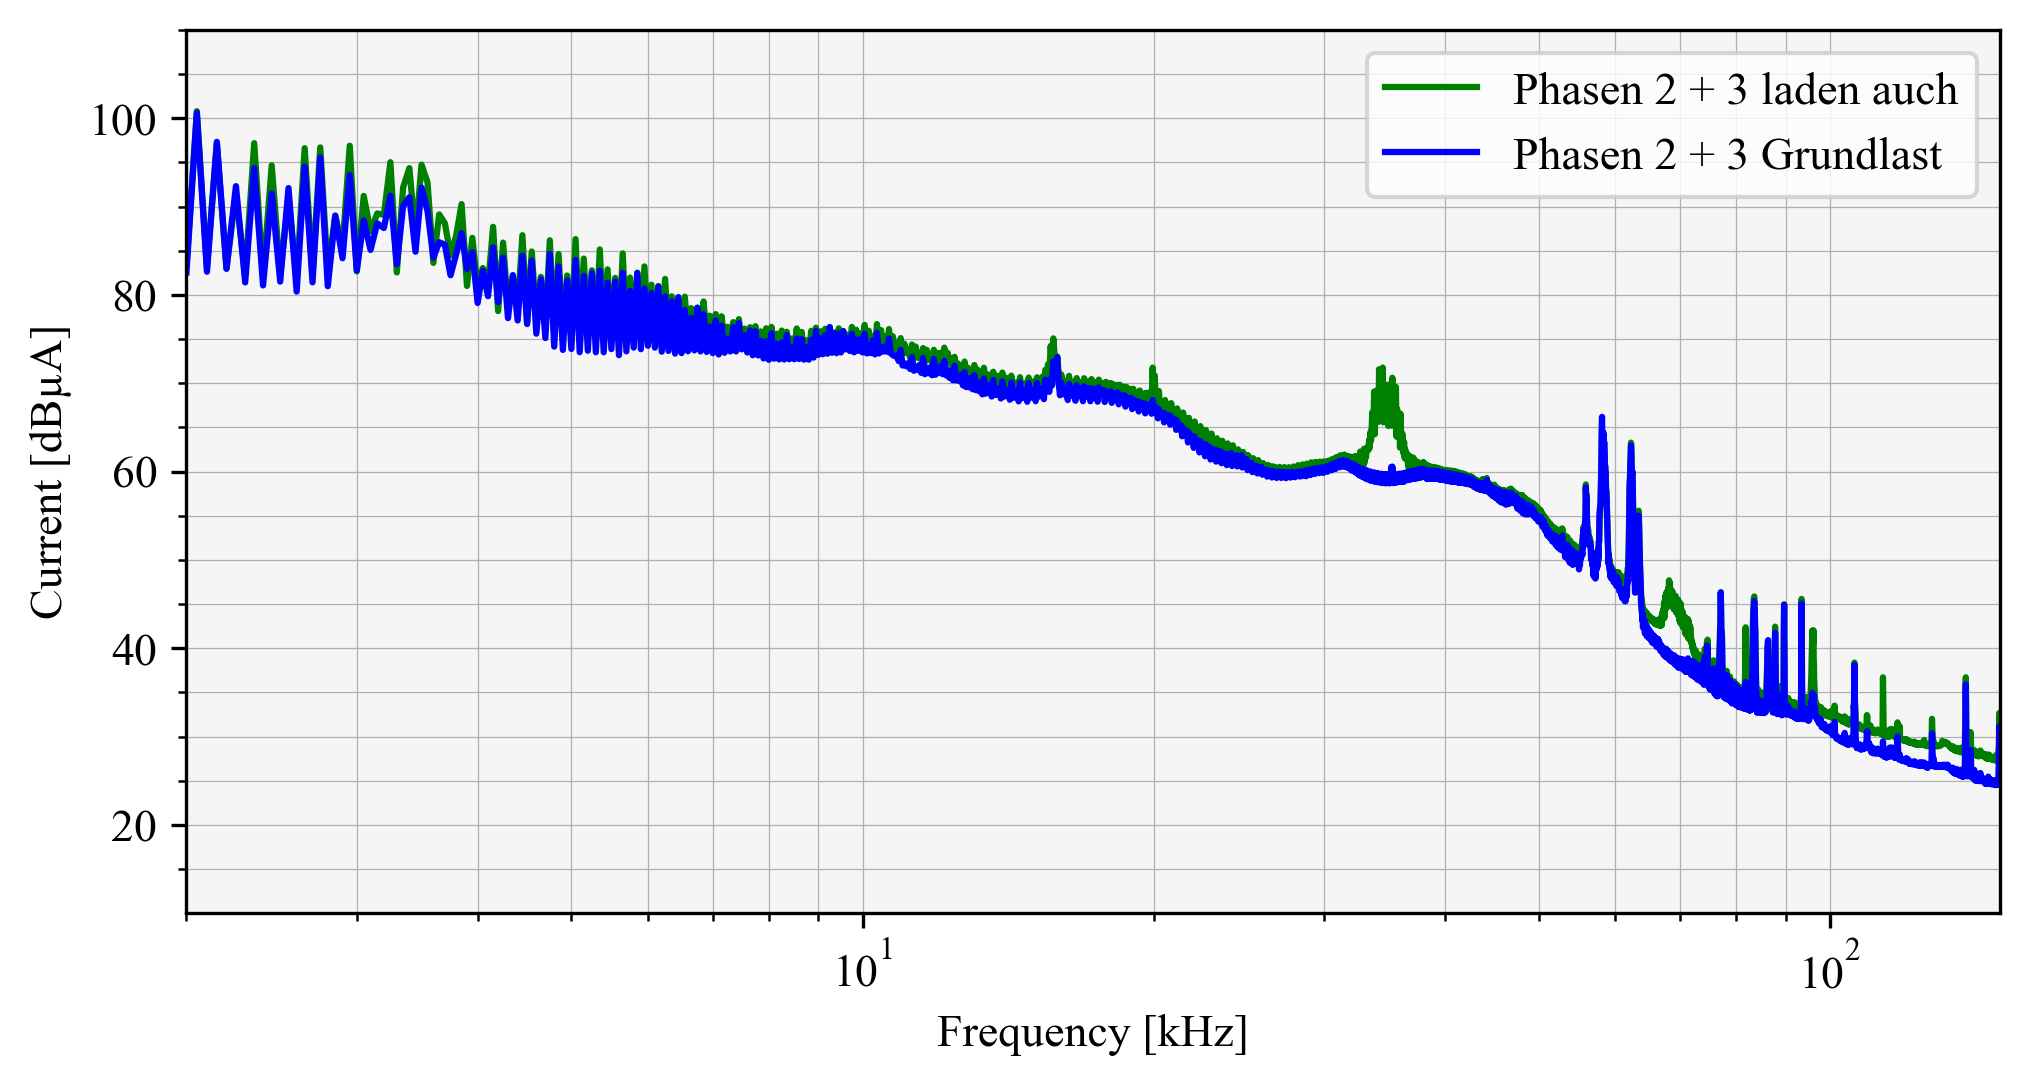

In [53]:
p1_cm1_1 = shi_all_p1[(labels1 == -1) & (labels2 != 1) & (labels3 != 1)]
p1_cm1_2 = shi_all_p1[(labels1 == -1) & (labels2 == 1) & (labels3 == 1)]

p1_cm1_1_mean = np.mean(p1_cm1_1, axis=0)
p1_cm1_2_mean = np.mean(p1_cm1_2, axis=0)
p1_cm1_1_mean_db = levels_dbmyA(p1_cm1_1_mean.to_numpy(dtype=np.float32))
p1_cm1_2_mean_db = levels_dbmyA(p1_cm1_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p1_cm1_1_mean_db, label ="Phasen 2 + 3 laden auch", c='green')
ax.plot(x, p1_cm1_2_mean_db, label ="Phasen 2 + 3 Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('whitesmoke')

In [160]:
x = generateXAxisData()/1000
d = {'laden': p1_cm1_1_mean_db,'grundlast': p1_cm1_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-38.xlsx")

### Phase 2 - Phasenbeziehung

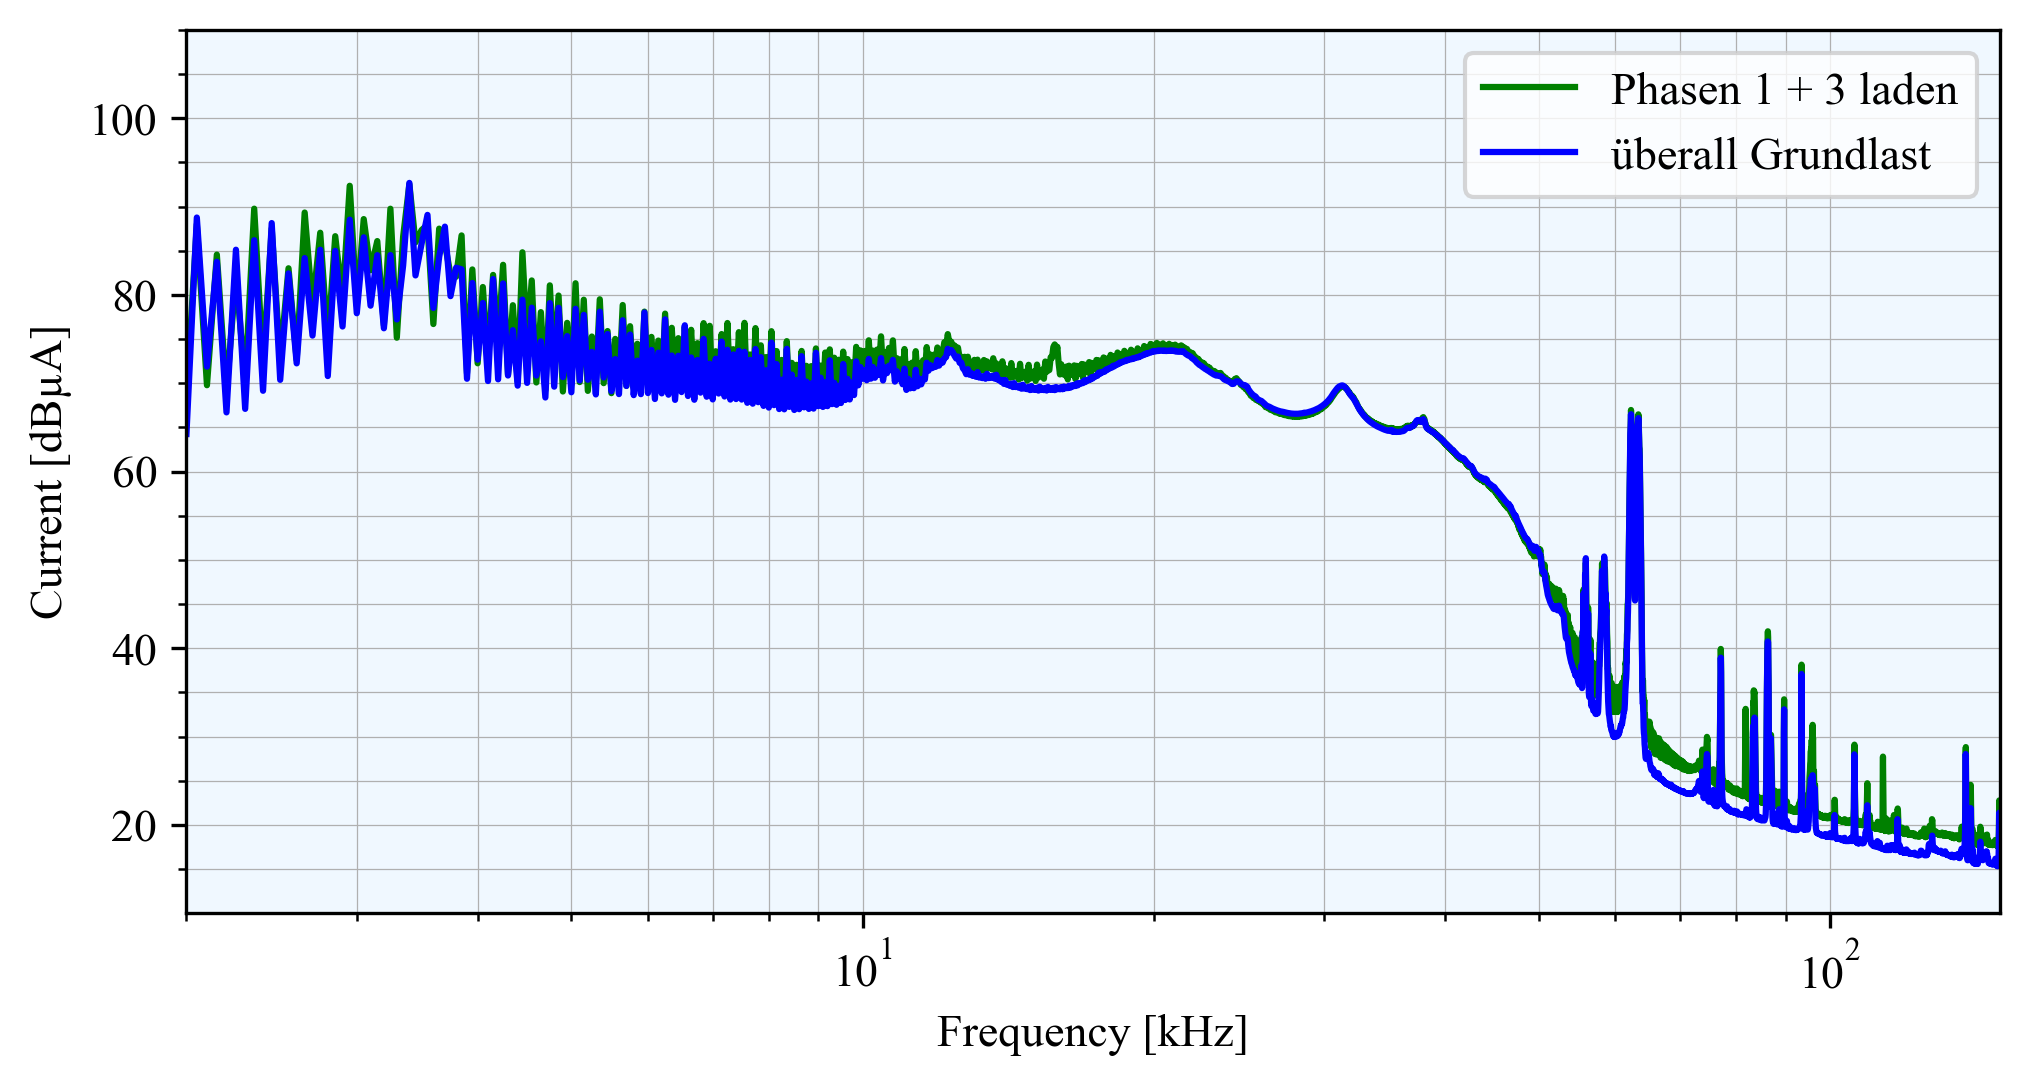

In [54]:
p2_c1_1 = shi_all_p2[(labels2 == 1) & (labels1 != 1) & (labels3 != 1)]
p2_c1_2 = shi_all_p2[(labels2 == 1) & (labels1 == 1) & (labels3 == 1)]

p2_c1_1_mean = np.mean(p2_c1_1, axis=0)
p2_c1_2_mean = np.mean(p2_c1_2, axis=0)
p2_c1_1_mean_db = levels_dbmyA(p2_c1_1_mean.to_numpy(dtype=np.float32))
p2_c1_2_mean_db = levels_dbmyA(p2_c1_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p2_c1_1_mean_db, label ="Phasen 1 + 3 laden", c='green')
ax.plot(x, p2_c1_2_mean_db, label ="überall Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('aliceblue')

In [161]:
x = generateXAxisData()/1000
d = {'laden': p2_c1_1_mean_db,'grundlast': p2_c1_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-39.xlsx")

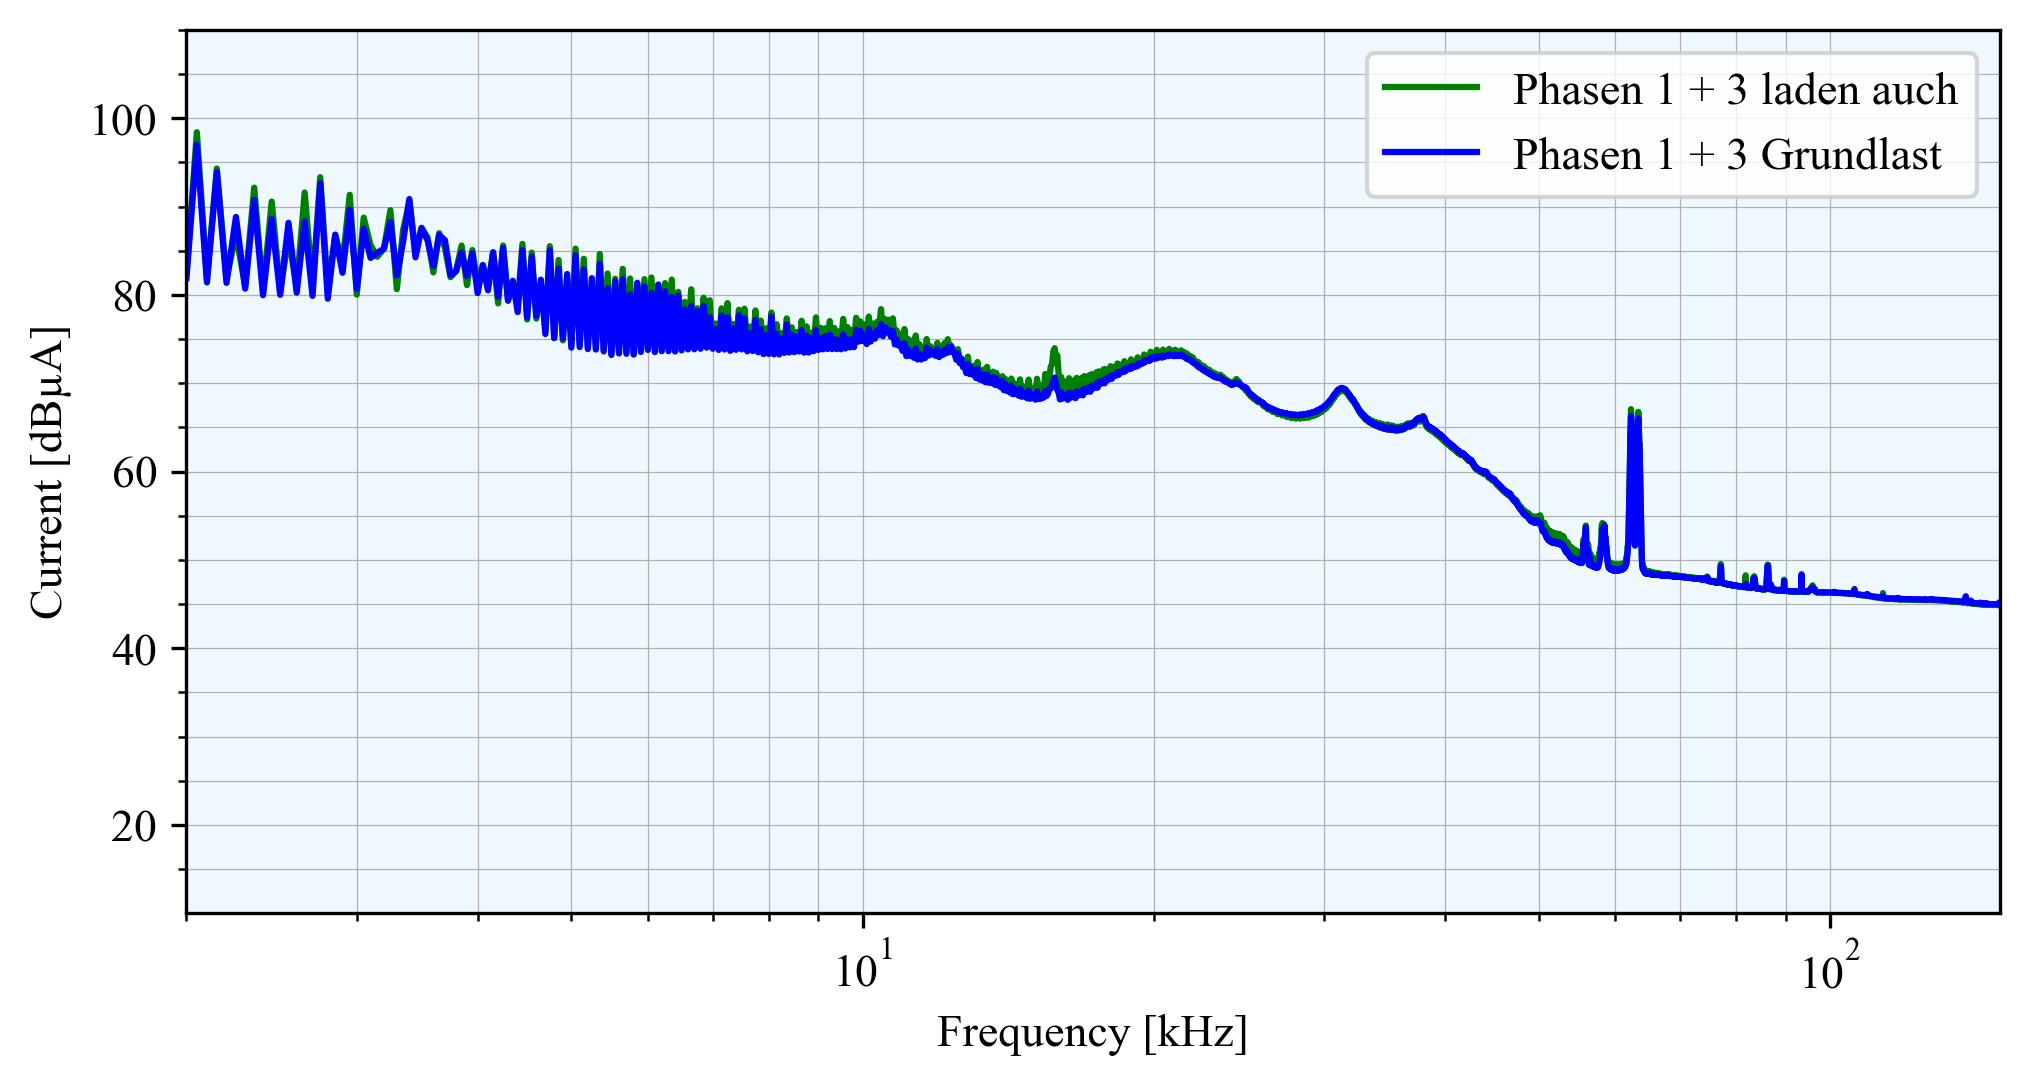

In [55]:
p2_c0_1 = shi_all_p2[(labels2 == 0) & (labels1 != 1) & (labels3 != 1)]
p2_c0_2 = shi_all_p2[(labels2 == 0) & (labels1 == 1) & (labels3 == 1)]

p2_c0_1_mean = np.mean(p2_c0_1, axis=0)
p2_c0_2_mean = np.mean(p2_c0_2, axis=0)
p2_c0_1_mean_db = levels_dbmyA(p2_c0_1_mean.to_numpy(dtype=np.float32))
p2_c0_2_mean_db = levels_dbmyA(p2_c0_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p2_c0_1_mean_db, label ="Phasen 1 + 3 laden auch", c='green')
ax.plot(x, p2_c0_2_mean_db, label ="Phasen 1 + 3 Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('aliceblue')

In [162]:
x = generateXAxisData()/1000
d = {'laden': p2_c0_1_mean_db,'grundlast': p2_c0_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-40.xlsx")

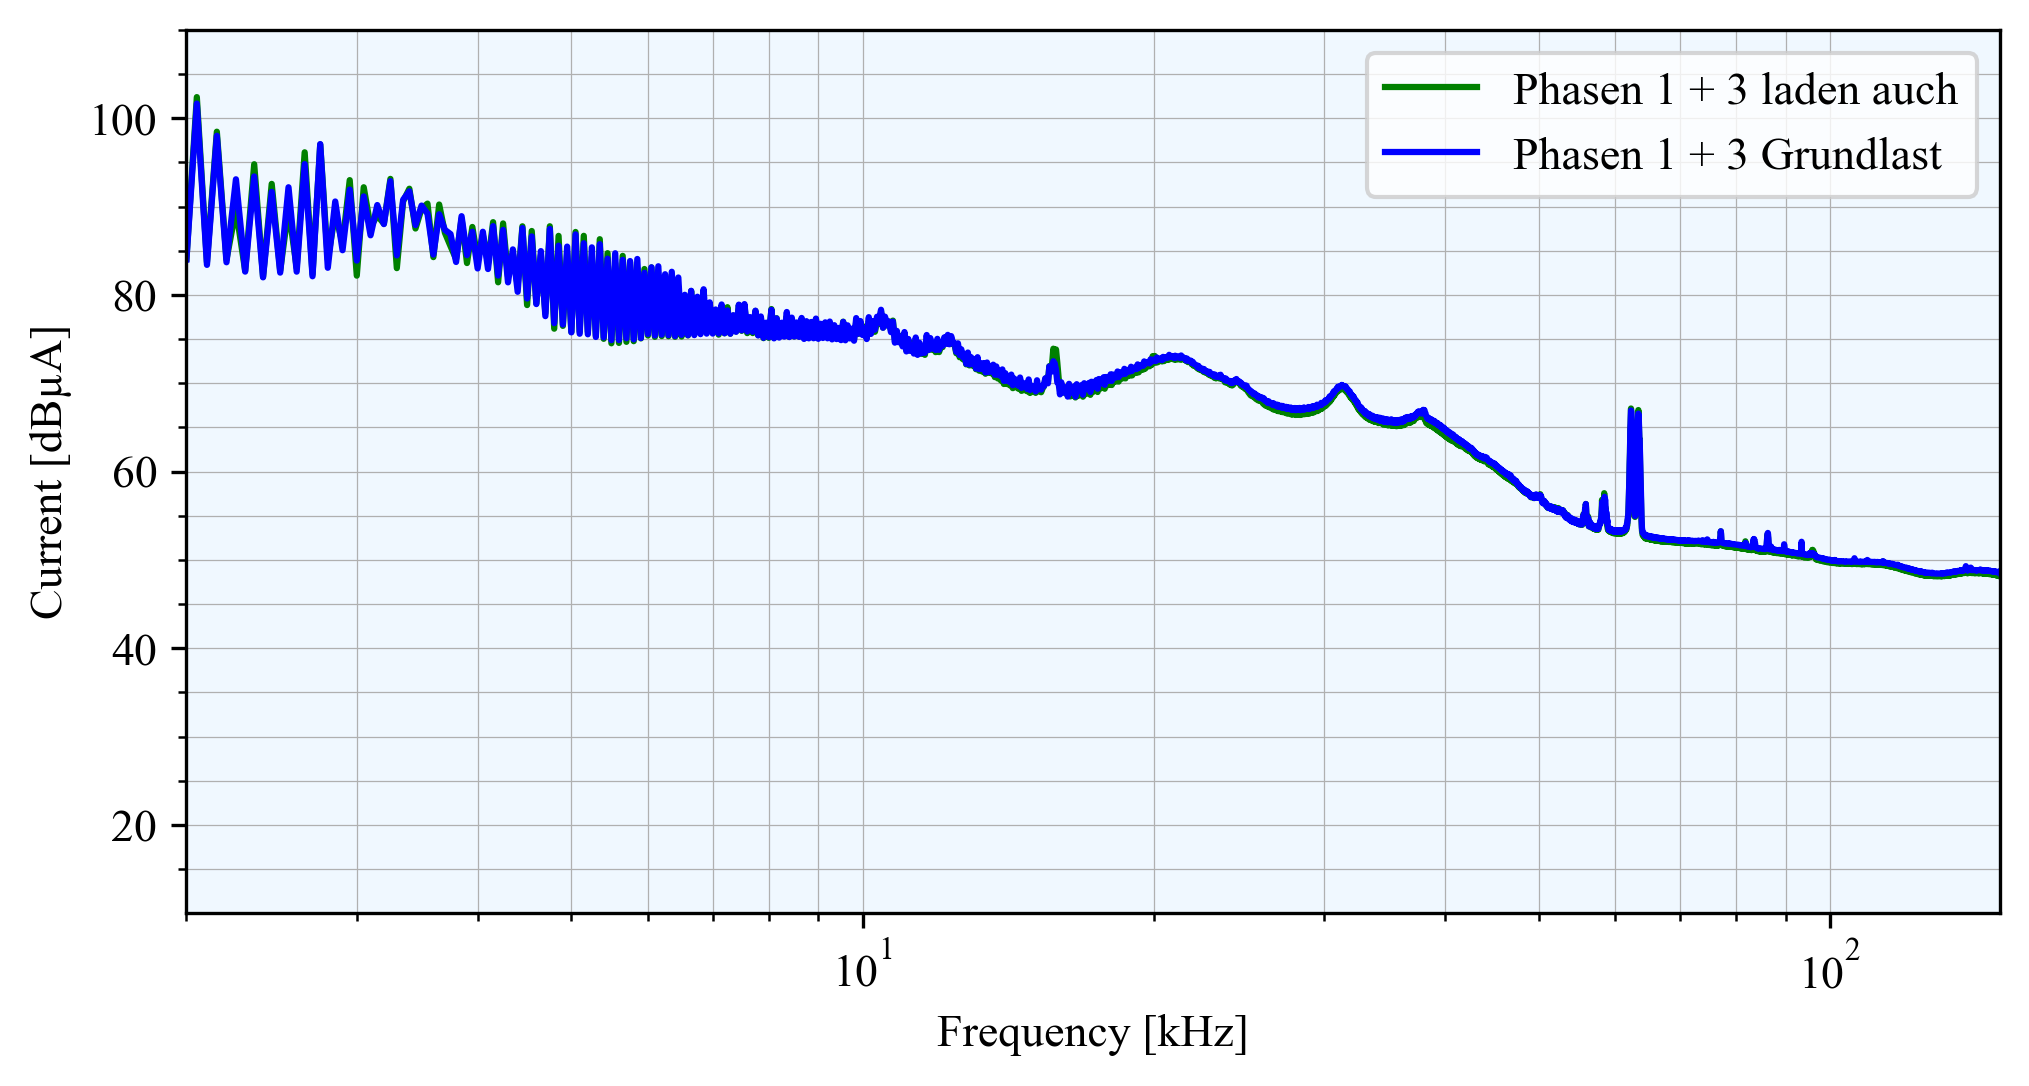

In [56]:
p2_c2_1 = shi_all_p2[(labels2 == 2) & (labels1 != 1) & (labels3 != 1)]
p2_c2_2 = shi_all_p2[(labels2 == 2) & (labels1 == 1) & (labels3 == 1)]

p2_c2_1_mean = np.mean(p2_c2_1, axis=0)
p2_c2_2_mean = np.mean(p2_c2_2, axis=0)
p2_c2_1_mean_db = levels_dbmyA(p2_c2_1_mean.to_numpy(dtype=np.float32))
p2_c2_2_mean_db = levels_dbmyA(p2_c2_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p2_c2_1_mean_db, label ="Phasen 1 + 3 laden auch", c='green')
ax.plot(x, p2_c2_2_mean_db, label ="Phasen 1 + 3 Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('aliceblue')

In [163]:
x = generateXAxisData()/1000
d = {'laden': p2_c2_1_mean_db,'grundlast': p2_c2_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-41.xlsx")

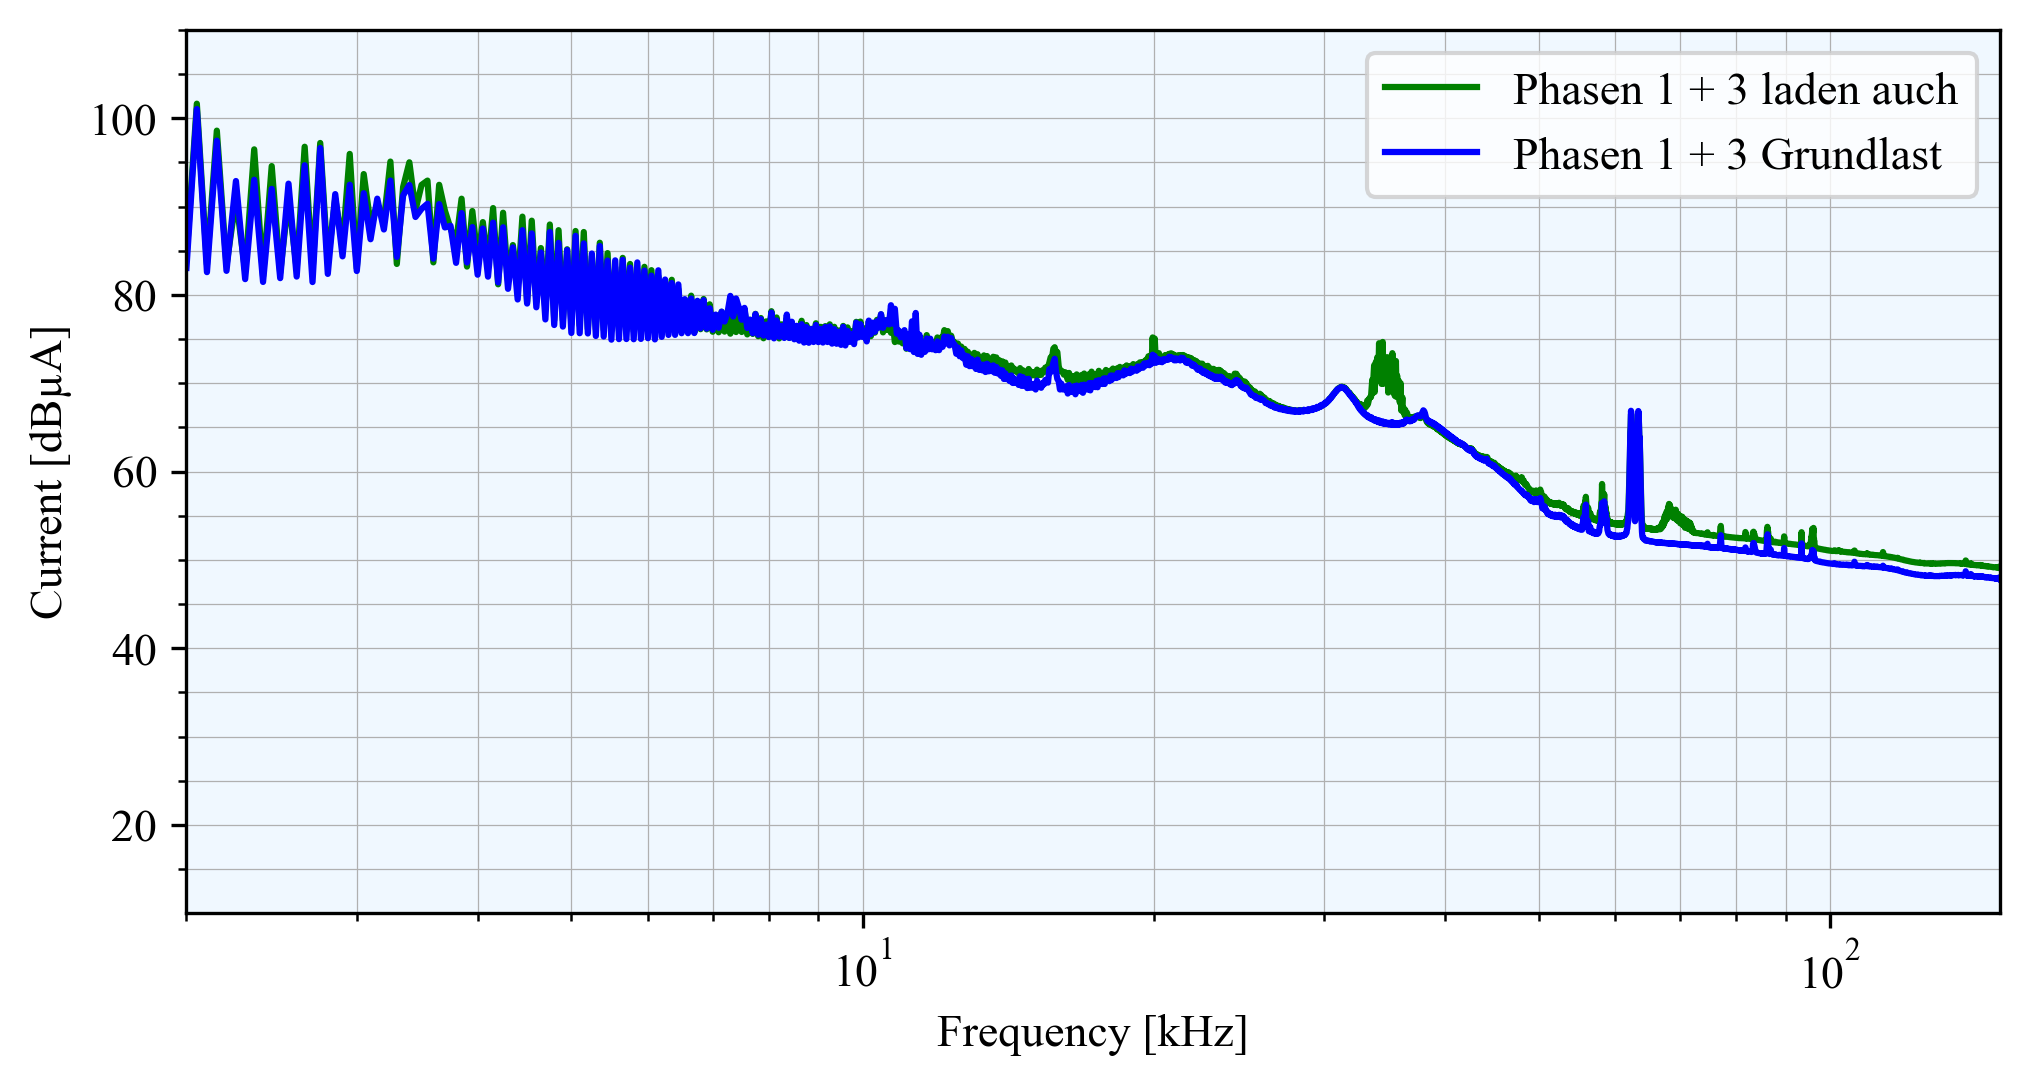

In [57]:
p2_cm1_1 = shi_all_p2[(labels2 == -1) & (labels1 != 1) & (labels3 != 1)]
p2_cm1_2 = shi_all_p2[(labels2 == -1) & (labels1 == 1) & (labels3 == 1)]

p2_cm1_1_mean = np.mean(p2_cm1_1, axis=0)
p2_cm1_2_mean = np.mean(p2_cm1_2, axis=0)
p2_cm1_1_mean_db = levels_dbmyA(p2_cm1_1_mean.to_numpy(dtype=np.float32))
p2_cm1_2_mean_db = levels_dbmyA(p2_cm1_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p2_cm1_1_mean_db, label ="Phasen 1 + 3 laden auch", c='green')
ax.plot(x, p2_cm1_2_mean_db, label ="Phasen 1 + 3 Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('aliceblue')

In [164]:
x = generateXAxisData()/1000
d = {'laden': p2_cm1_1_mean_db,'grundlast': p2_cm1_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-42.xlsx")

### Phase 3 - Phasenbeziehung

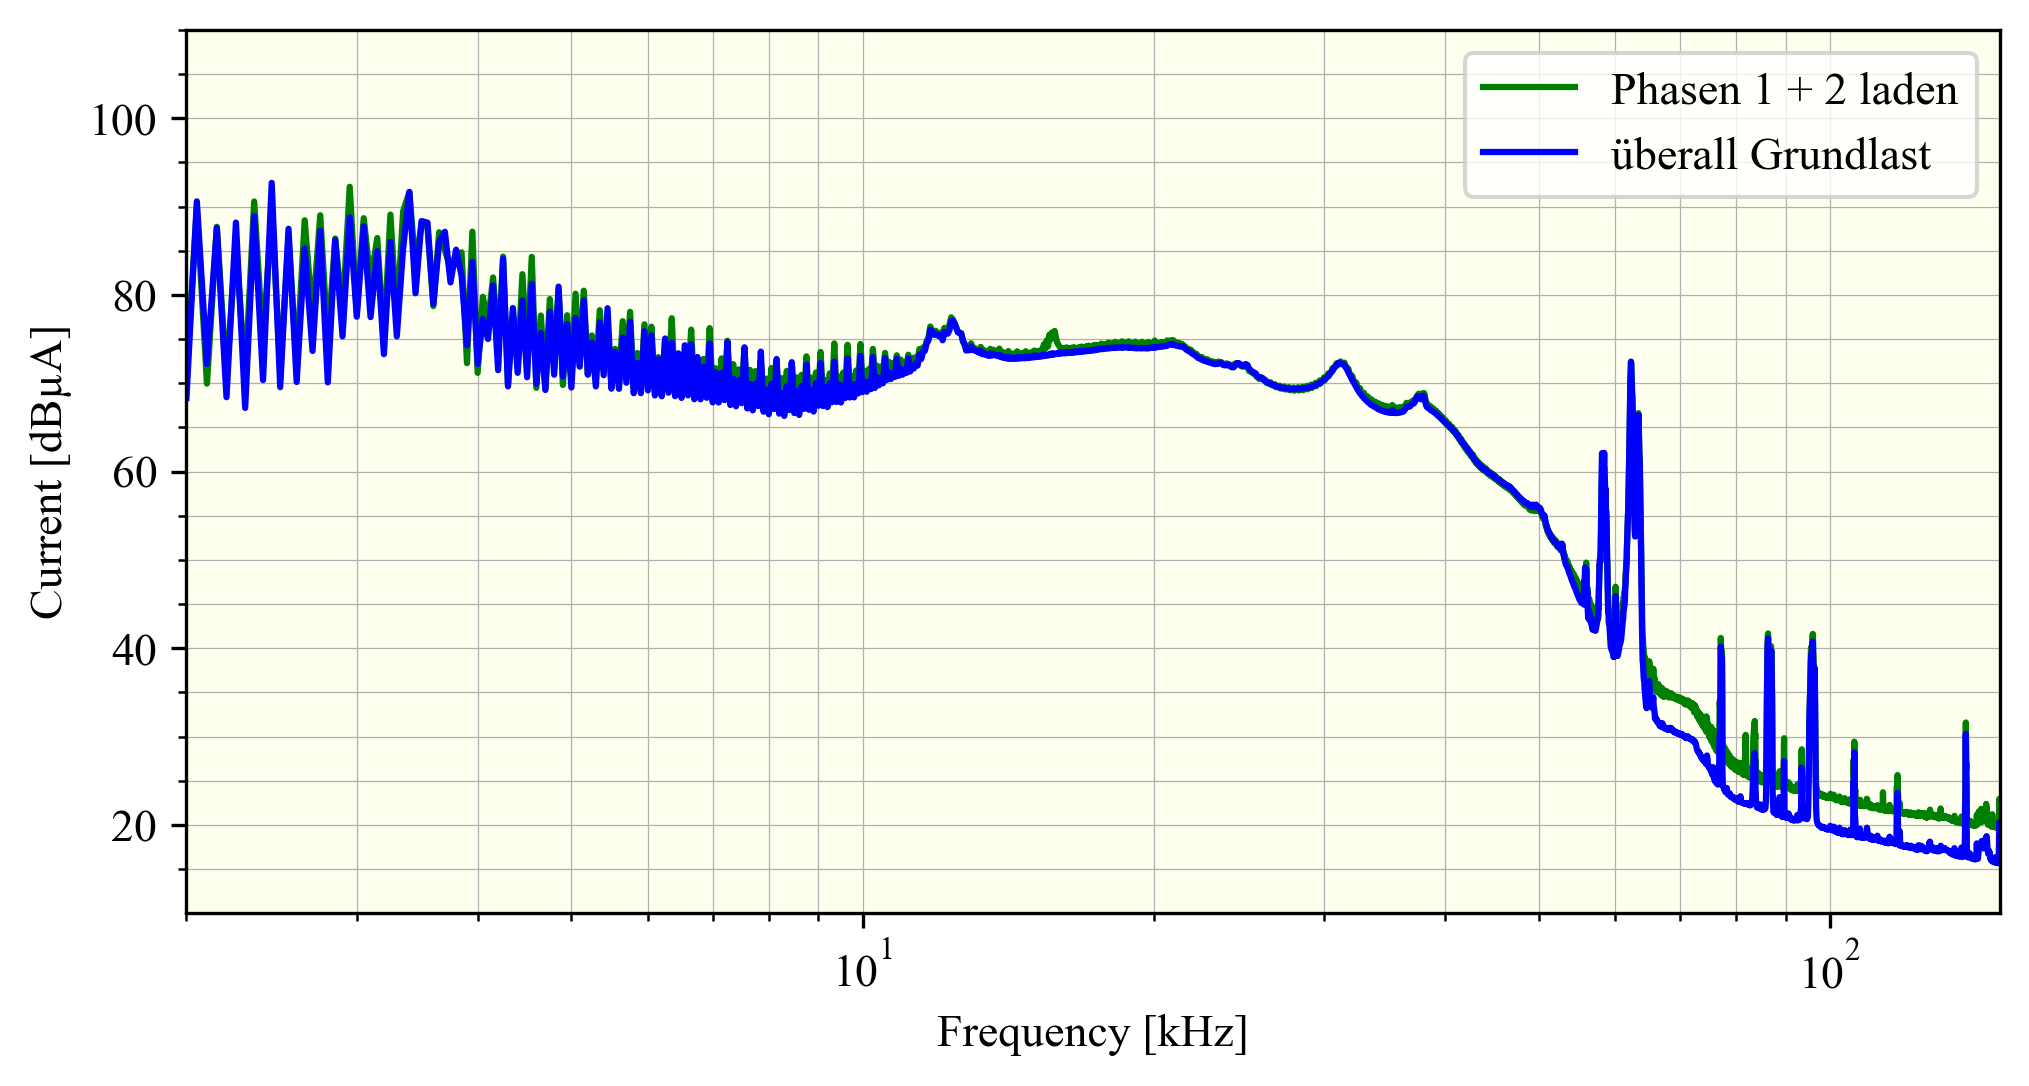

In [58]:
p3_c1_1 = shi_all_p3[(labels3 == 1) & (labels1 != 1) & (labels2 != 1)]
p3_c1_2 = shi_all_p3[(labels3 == 1) & (labels1 == 1) & (labels2 == 1)]

p3_c1_1_mean = np.mean(p3_c1_1, axis=0)
p3_c1_2_mean = np.mean(p3_c1_2, axis=0)
p3_c1_1_mean_db = levels_dbmyA(p3_c1_1_mean.to_numpy(dtype=np.float32))
p3_c1_2_mean_db = levels_dbmyA(p3_c1_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p3_c1_1_mean_db, label ="Phasen 1 + 2 laden", c='green')
ax.plot(x, p3_c1_2_mean_db, label ="überall Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('ivory')

In [165]:
x = generateXAxisData()/1000
d = {'laden': p3_c1_1_mean_db,'grundlast': p3_c1_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-43.xlsx")

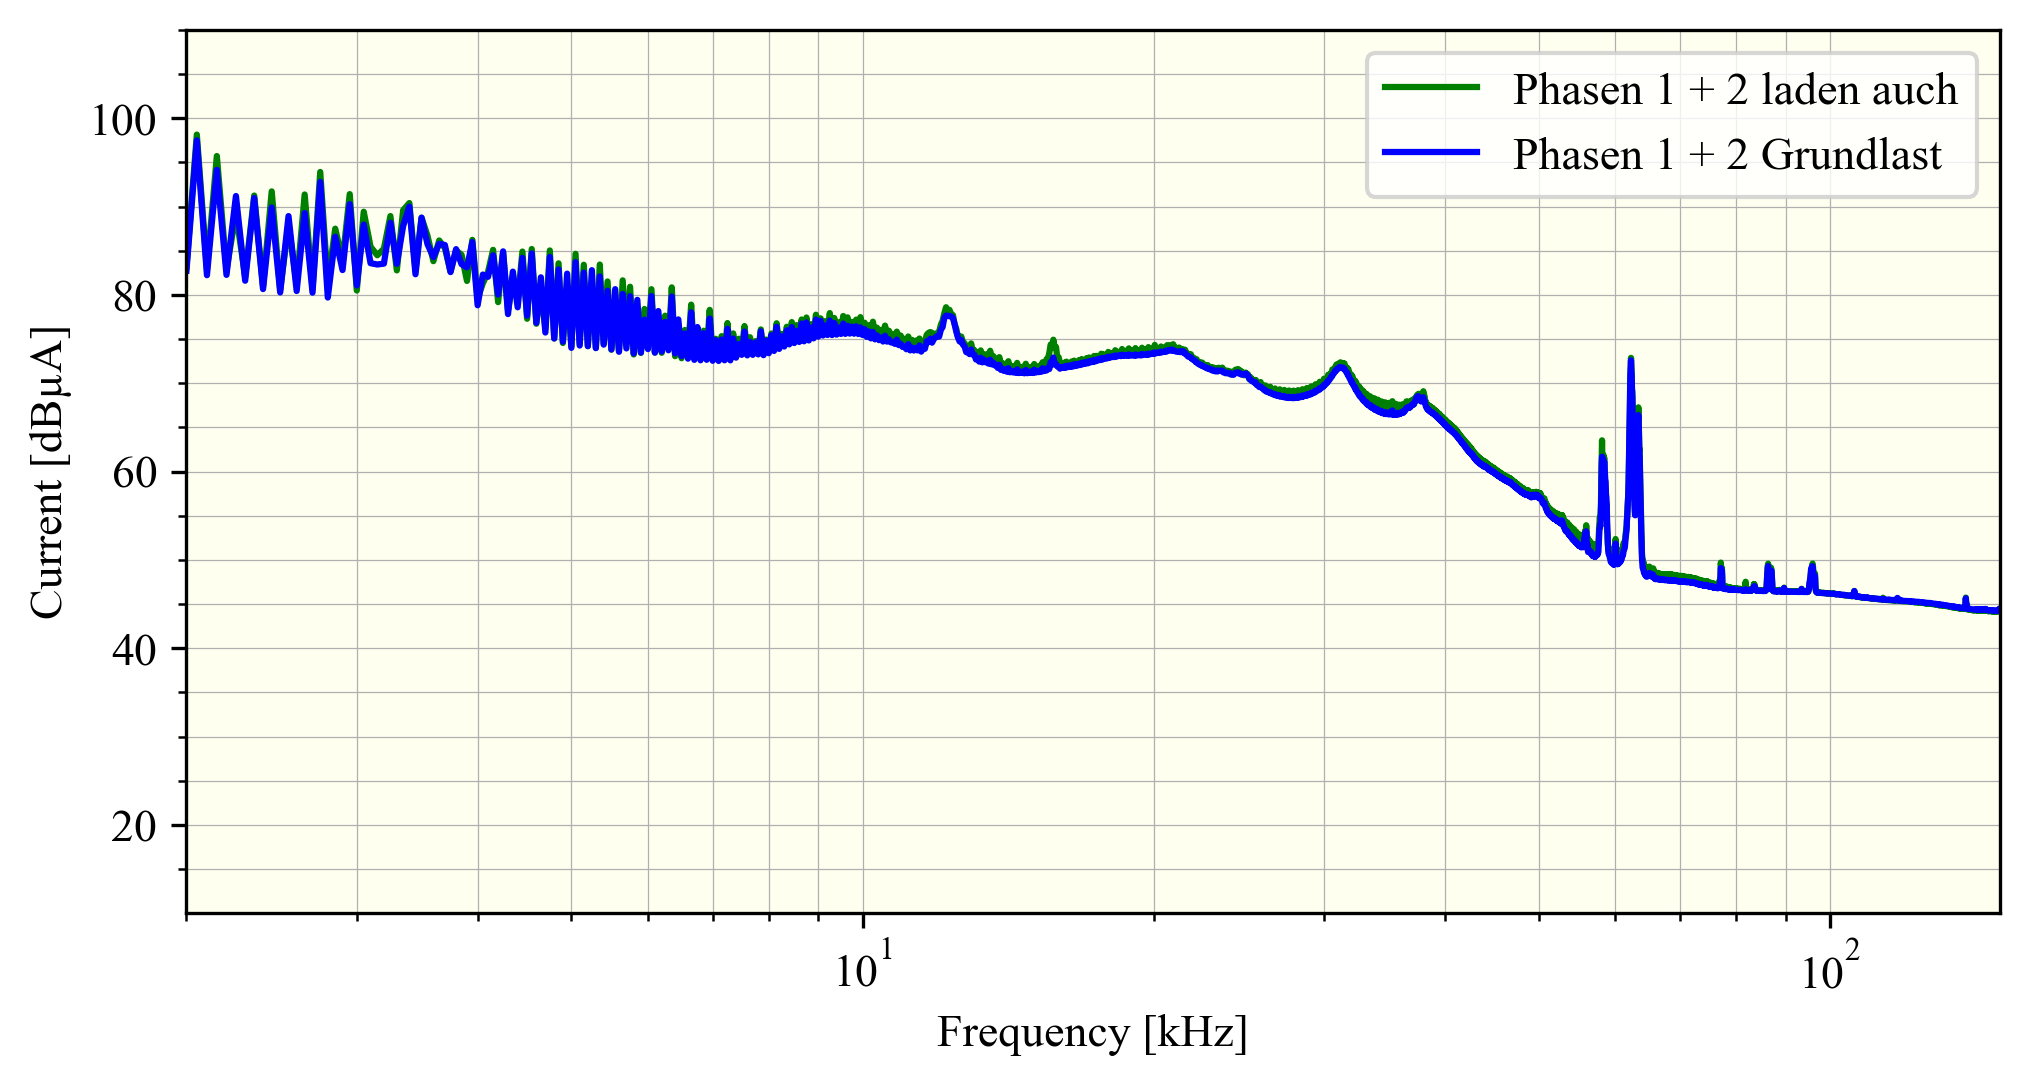

In [59]:
p3_c0_1 = shi_all_p3[(labels3 == 0) & (labels1 != 1) & (labels2 != 1)]
p3_c0_2 = shi_all_p3[(labels3 == 0) & (labels1 == 1) & (labels2 == 1)]

p3_c0_1_mean = np.mean(p3_c0_1, axis=0)
p3_c0_2_mean = np.mean(p3_c0_2, axis=0)
p3_c0_1_mean_db = levels_dbmyA(p3_c0_1_mean.to_numpy(dtype=np.float32))
p3_c0_2_mean_db = levels_dbmyA(p3_c0_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p3_c0_1_mean_db, label ="Phasen 1 + 2 laden auch", c='green')
ax.plot(x, p3_c0_2_mean_db, label ="Phasen 1 + 2 Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('ivory')

In [166]:
x = generateXAxisData()/1000
d = {'laden':p3_c0_1_mean_db,'grundlast': p3_c0_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-44.xlsx")

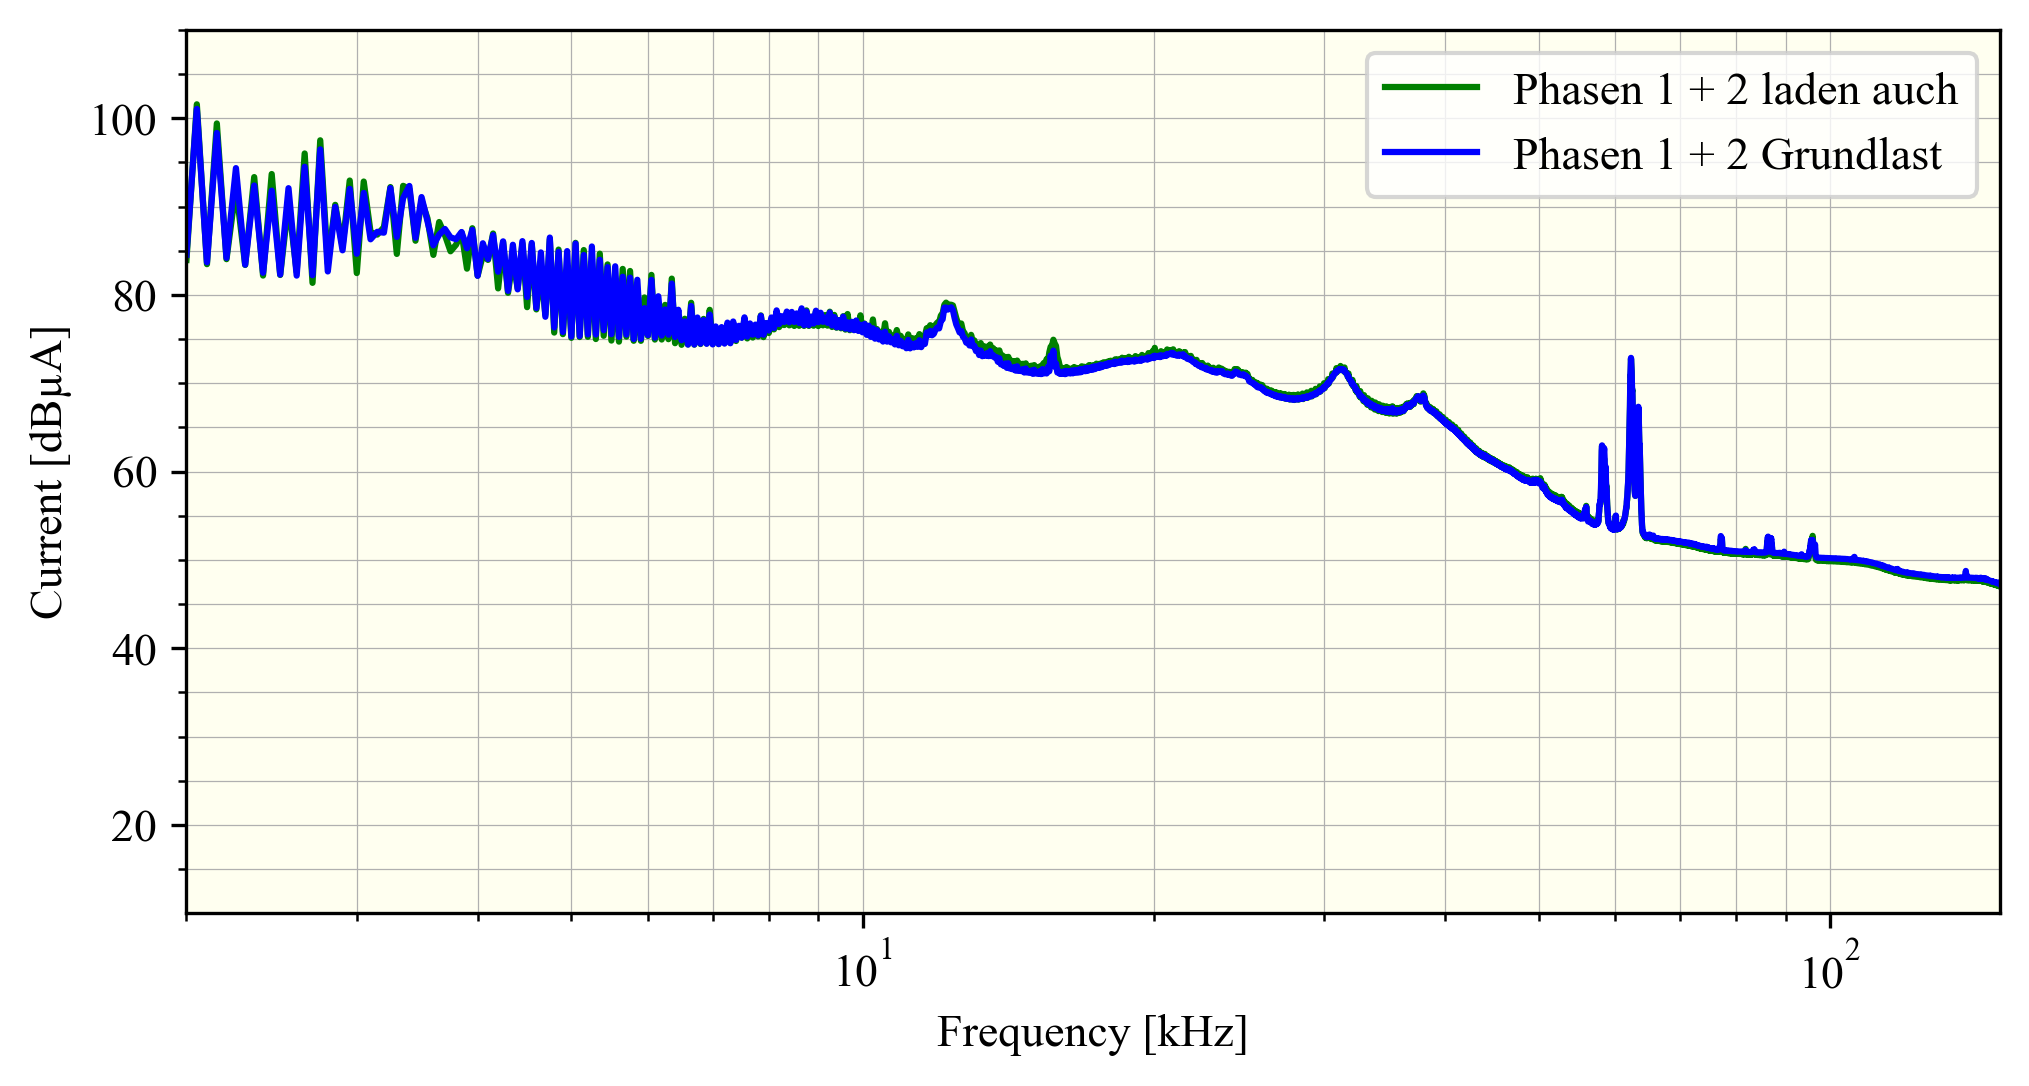

In [60]:
p3_c2_1 = shi_all_p3[(labels3 == 2) & (labels1 != 1) & (labels2 != 1)]
p3_c2_2 = shi_all_p3[(labels3 == 2) & (labels1 == 1) & (labels2 == 1)]

p3_c2_1_mean = np.mean(p3_c2_1, axis=0)
p3_c2_2_mean = np.mean(p3_c2_2, axis=0)
p3_c2_1_mean_db = levels_dbmyA(p3_c2_1_mean.to_numpy(dtype=np.float32))
p3_c2_2_mean_db = levels_dbmyA(p3_c2_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p3_c2_1_mean_db, label ="Phasen 1 + 2 laden auch", c='green')
ax.plot(x, p3_c2_2_mean_db, label ="Phasen 1 + 2 Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('ivory')

In [167]:
x = generateXAxisData()/1000
d = {'laden':p3_c2_1_mean_db,'grundlast': p3_c2_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-45.xlsx")

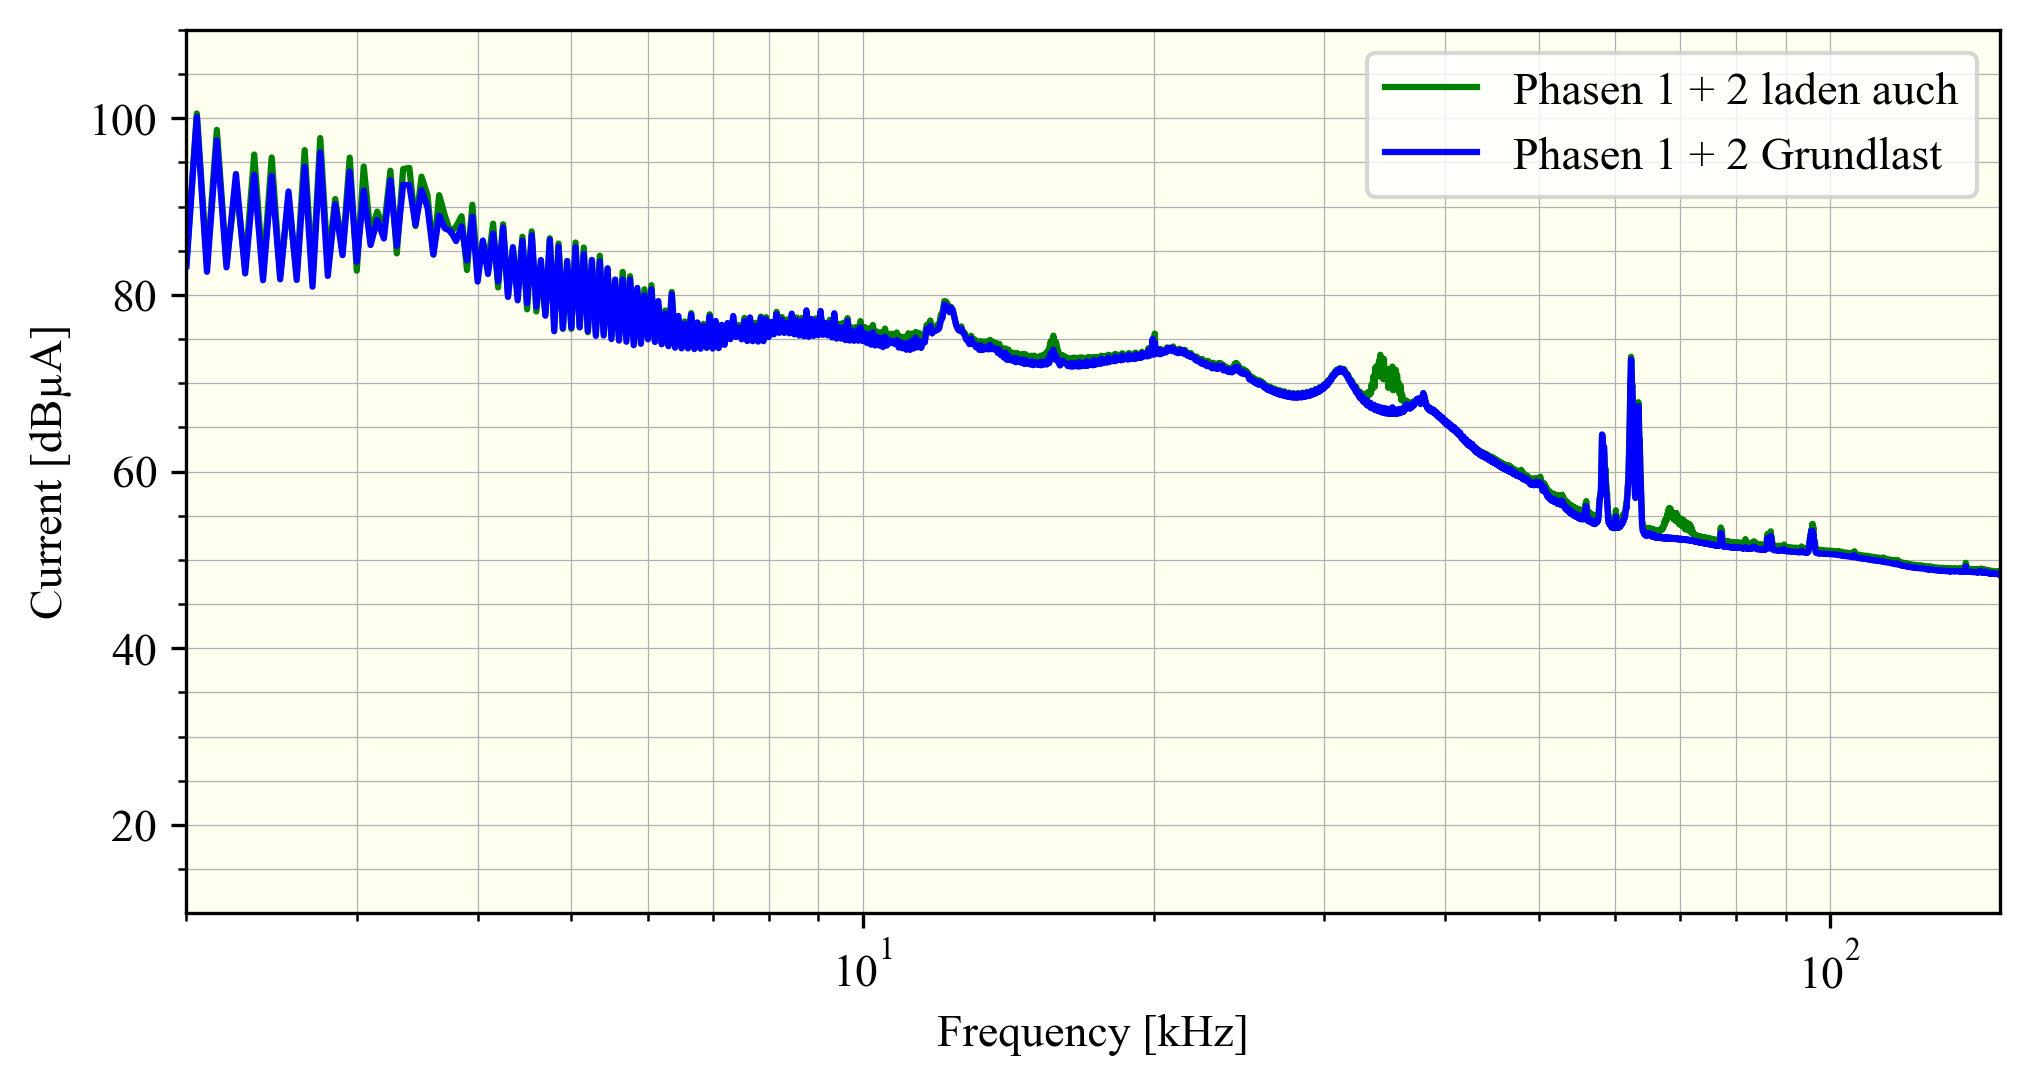

In [61]:
p3_cm1_1 = shi_all_p3[(labels3 == -1) & (labels1 != 1) & (labels2 != 1)]
p3_cm1_2 = shi_all_p3[(labels3 == -1) & (labels1 == 1) & (labels2 == 1)]

p3_cm1_1_mean = np.mean(p3_cm1_1, axis=0)
p3_cm1_2_mean = np.mean(p3_cm1_2, axis=0)
p3_cm1_1_mean_db = levels_dbmyA(p3_cm1_1_mean.to_numpy(dtype=np.float32))
p3_cm1_2_mean_db = levels_dbmyA(p3_cm1_2_mean.to_numpy(dtype=np.float32))

x = generateXAxisData()/1000

fig, ax = plt.subplots()
ax.plot(x, p3_cm1_1_mean_db, label ="Phasen 1 + 2 laden auch", c='green')
ax.plot(x, p3_cm1_2_mean_db, label ="Phasen 1 + 2 Grundlast", c='blue')
ax.set_xlim(min(x), max(x))
ax.set_ylim((10,110))

ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Current [dBµA]')
ax.set_xscale('log')
ax.legend()
ax.set_facecolor('ivory')

In [168]:
x = generateXAxisData()/1000
d = {'laden':p3_cm1_1_mean_db,'grundlast': p3_cm1_2_mean_db}
df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-46.xlsx")

### Histogram der Cluster

### Cluster 1:

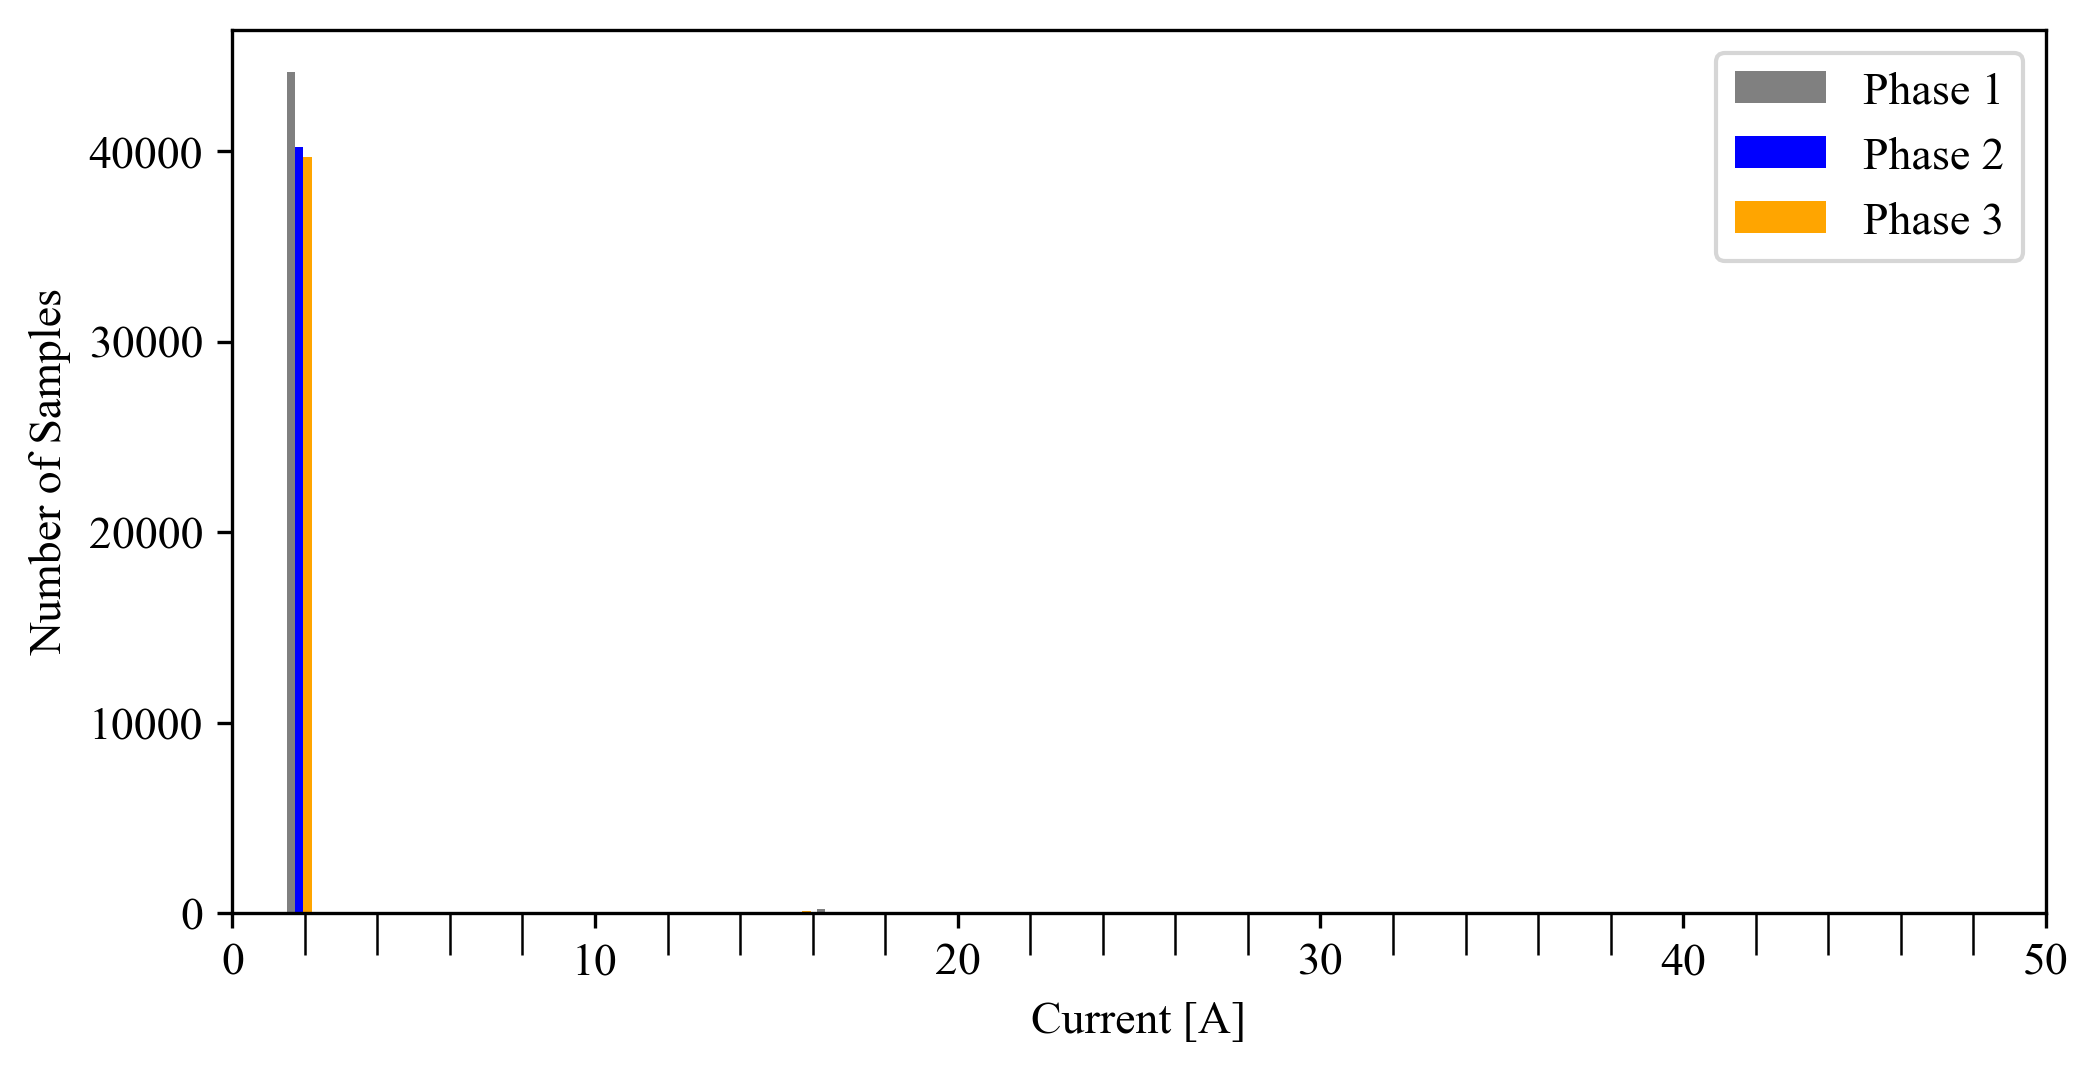

In [123]:
rmsi_p1_c1 = rmsi_all_p1[labels1 == 1]
rmsi_p2_c1 = rmsi_all_p2[labels2 == 1]
rmsi_p3_c1 = rmsi_all_p3[labels3 == 1]

fig, ax = plt.subplots()
colors = ['grey', 'blue', 'orange']
hist_data = ax.hist((rmsi_p1_c1.values,rmsi_p2_c1.values,rmsi_p3_c1.values), 25, color=colors,density=False, histtype='bar', label=['Phase 1', 'Phase 2','Phase 3'])
ax.legend()
ax.set_xlabel("Current [A]")
ax.set_ylabel('Number of Samples')
ax.set_xlim(0,50)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=10)

In [144]:
hist_data[1]

array([ 1.4135693,  2.273301 ,  3.1330323,  3.9927638,  4.852495 ,
        5.712227 ,  6.571958 ,  7.4316897,  8.291421 ,  9.151153 ,
       10.010884 , 10.870616 , 11.730348 , 12.590078 , 13.44981  ,
       14.309542 , 15.169273 , 16.029005 , 16.888737 , 17.748468 ,
       18.608198 , 19.46793  , 20.327662 , 21.187393 , 22.047125 ,
       22.906857 ], dtype=float32)

In [145]:
d = {'Phase1':hist_data[0][0],'Phase2':hist_data[0][1],'Phase3':hist_data[0][2]}
df = pd.DataFrame(data=d)
df.index = hist_data[1][0:25]
df.to_excel("4-25.xlsx")

### Cluster 0

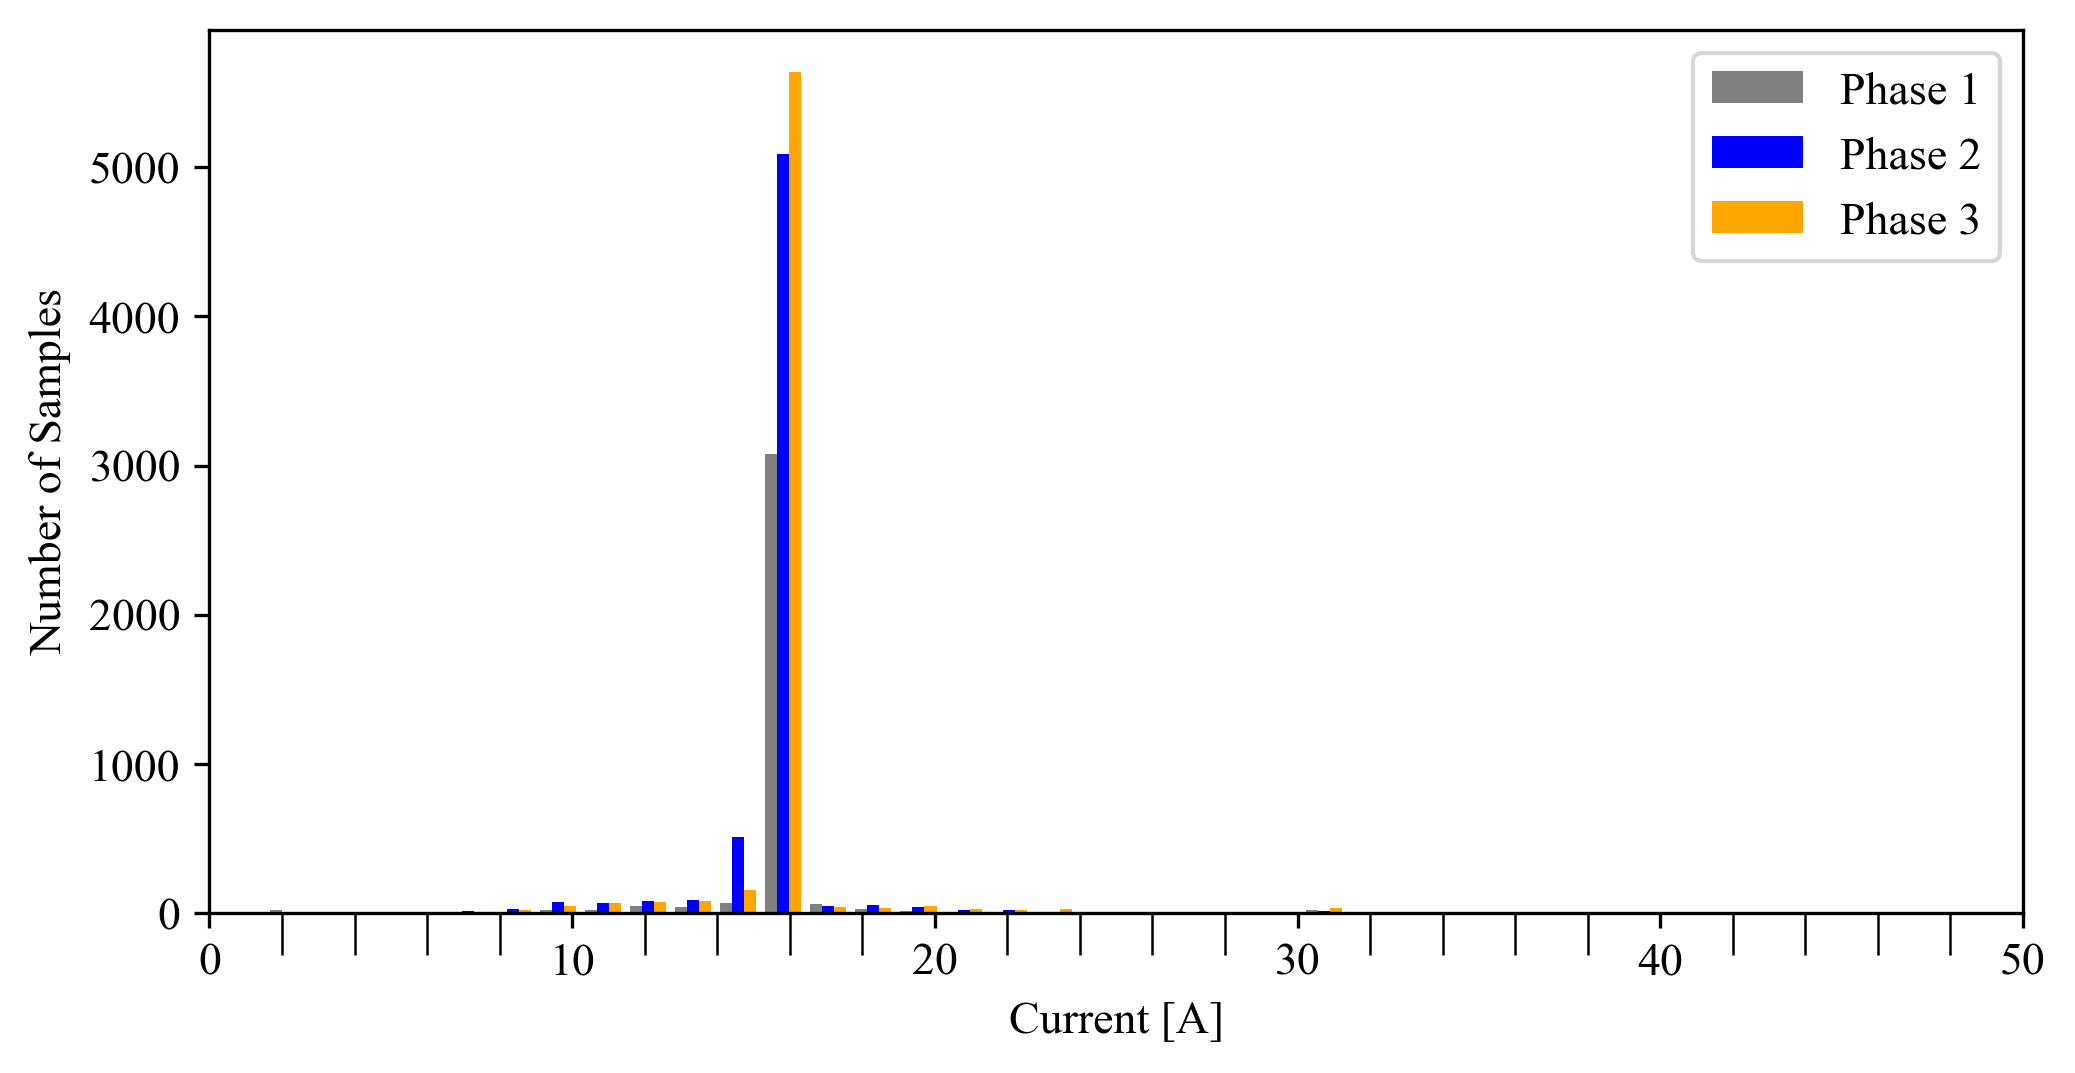

In [146]:
rmsi_p1_c1 = rmsi_all_p1[labels1 == 0]
rmsi_p2_c1 = rmsi_all_p2[labels2 == 0]
rmsi_p3_c1 = rmsi_all_p3[labels3 == 0]

fig, ax = plt.subplots()
colors = ['grey', 'blue', 'orange']
hist_data = ax.hist((rmsi_p1_c1.values,rmsi_p2_c1.values,rmsi_p3_c1.values), 25, color=colors,density=False, histtype='bar', label=['Phase 1', 'Phase 2','Phase 3'])
ax.legend()
ax.set_xlabel("Current [A]")
ax.set_ylabel('Number of Samples')
ax.set_xlim(0,50)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=10)

In [147]:
d = {'Phase1':hist_data[0][0],'Phase2':hist_data[0][1],'Phase3':hist_data[0][2]}
df = pd.DataFrame(data=d)
df.index = hist_data[1][0:25]
df.to_excel("4-26.xlsx")

### Cluster 2

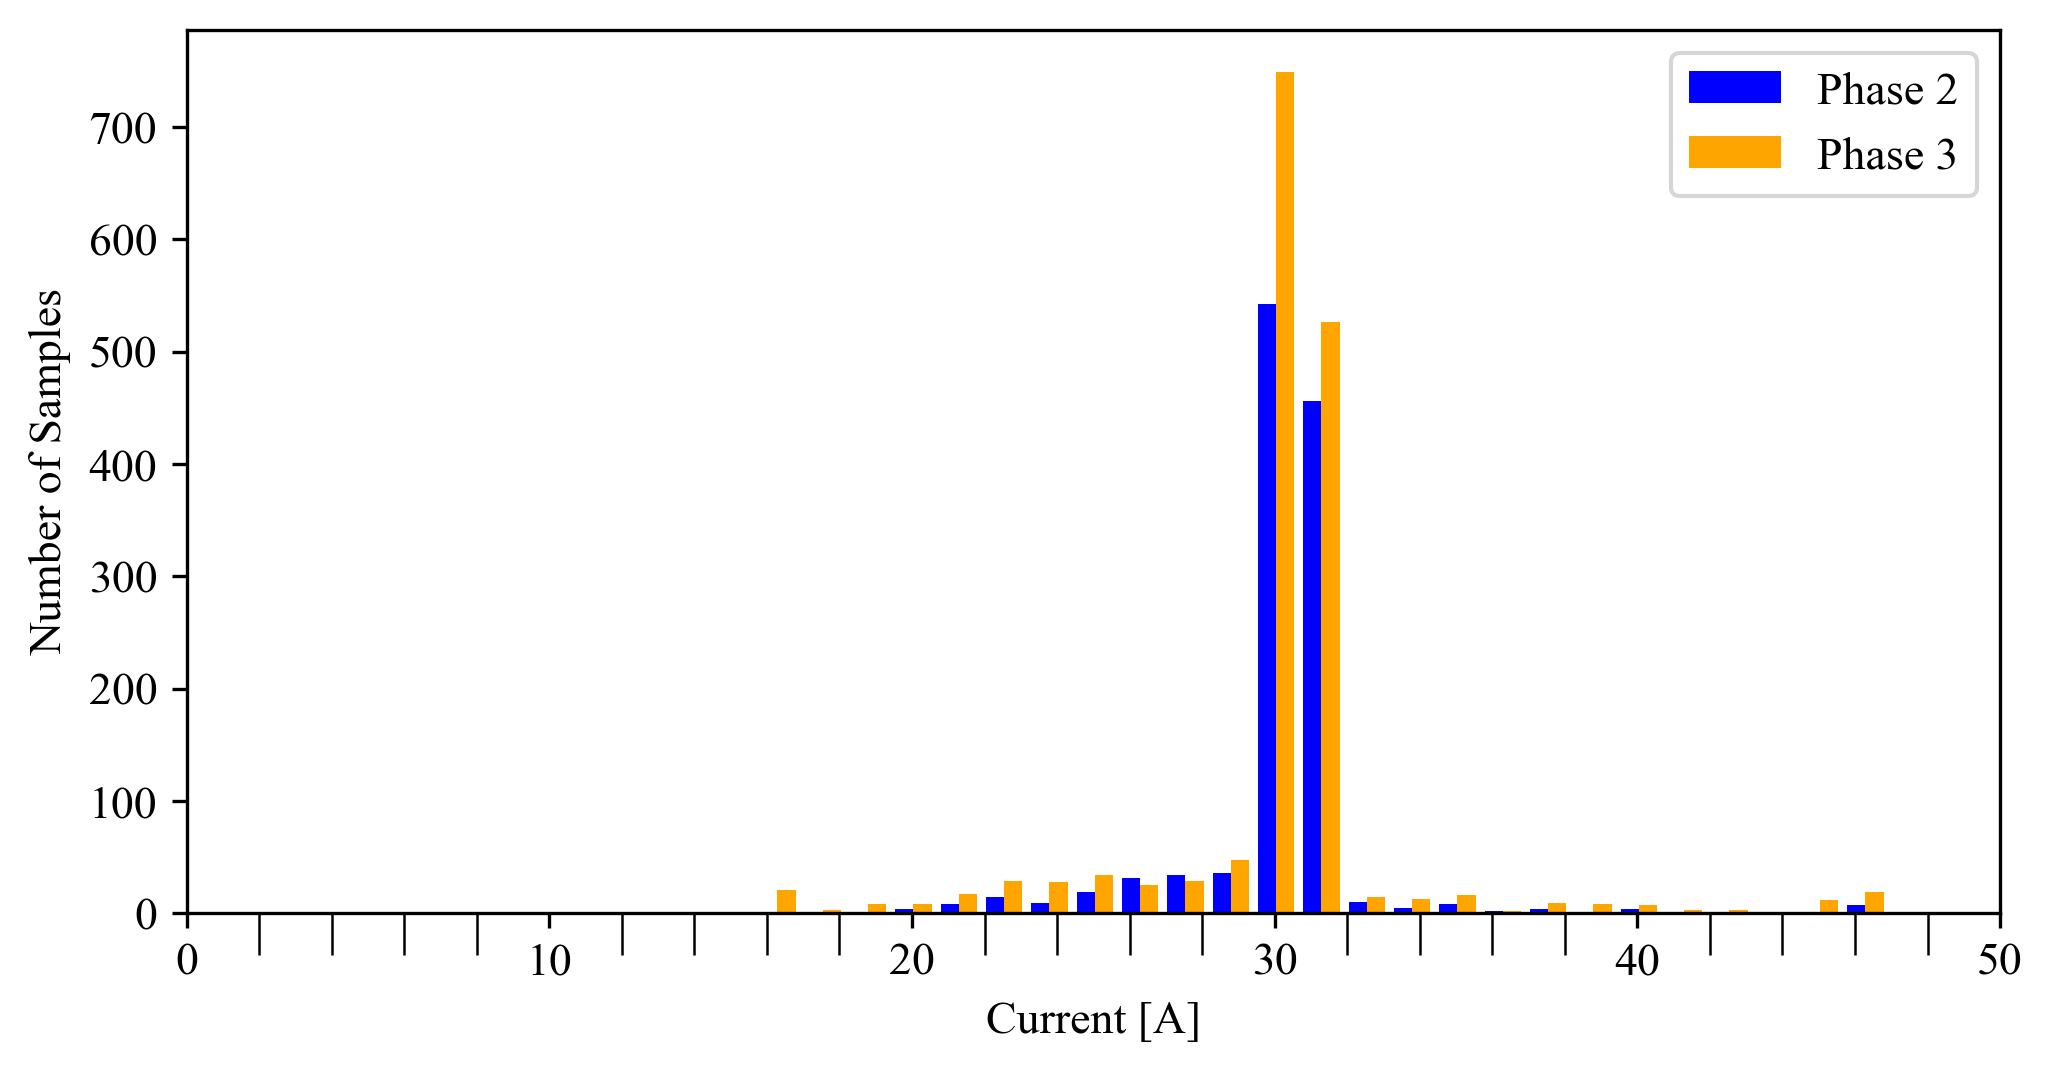

In [148]:
rmsi_p1_c1 = rmsi_all_p1[labels1 == 2]
rmsi_p2_c1 = rmsi_all_p2[labels2 == 2]
rmsi_p3_c1 = rmsi_all_p3[labels3 == 2]

fig, ax = plt.subplots()
colors = ['blue', 'orange']
hist_data = ax.hist((rmsi_p2_c1.values,rmsi_p3_c1.values), 25, color=colors,density=False, histtype='bar', label=['Phase 2','Phase 3'])
ax.legend()
ax.set_xlabel("Current [A]")
ax.set_ylabel('Number of Samples')
ax.set_xlim(0,50)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=10)

In [150]:
d = {'Phase1':hist_data[0][0],'Phase2':hist_data[0][1]}
df = pd.DataFrame(data=d)
df.index = hist_data[1][0:25]
df.to_excel("4-27.xlsx")

### Cluster -1

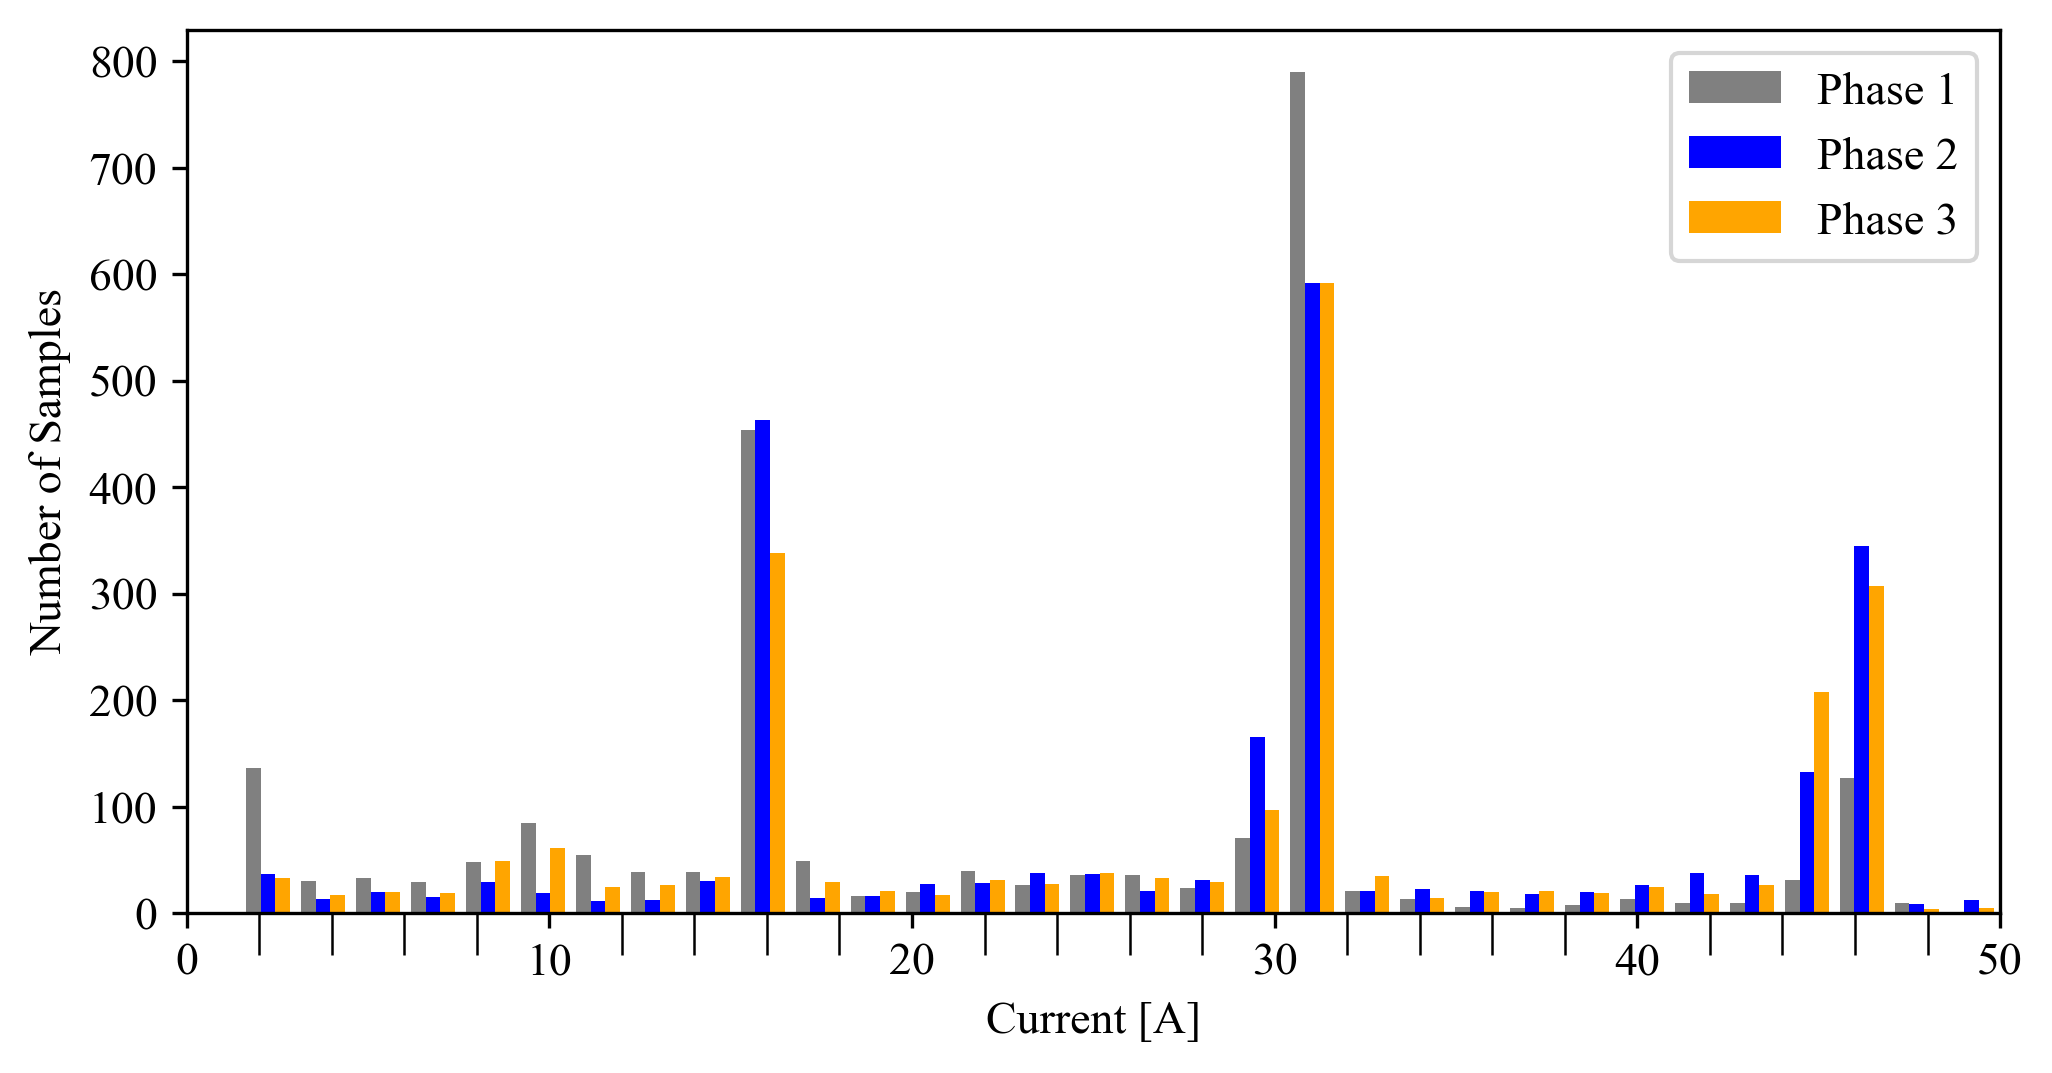

In [151]:
rmsi_p1_c1 = rmsi_all_p1[labels1 == -1]
rmsi_p2_c1 = rmsi_all_p2[labels2 == -1]
rmsi_p3_c1 = rmsi_all_p3[labels3 == -1]

fig, ax = plt.subplots()
colors = ['grey', 'blue', 'orange']
hist_data = ax.hist((rmsi_p1_c1.values,rmsi_p2_c1.values,rmsi_p3_c1.values), 50, color=colors,density=False, histtype='bar', label=['Phase 1', 'Phase 2','Phase 3'])
ax.legend()
ax.set_xlabel("Current [A]")
ax.set_ylabel('Number of Samples')
ax.set_xlim(0,50)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=10)

In [153]:
d = {'Phase1':hist_data[0][0],'Phase2':hist_data[0][1],'Phase3':hist_data[0][2]}
df = pd.DataFrame(data=d)
df.index = hist_data[1][0:50]
df.to_excel("4-28.xlsx")

### Spannungsanalyse der Cluster

In [62]:
shu_all_p1 = pd.DataFrame()
shu_all_p2 = pd.DataFrame()
shu_all_p3 = pd.DataFrame()

for date in datelist:
    shu_all_p1 = shu_all_p1.append(pd.read_pickle("E:\\resampled_phasevise\\u\\" + date + "_harmonics10min_u_mean_p1.p"), ignore_index=True)
    shu_all_p2 = shu_all_p2.append(pd.read_pickle("E:\\resampled_phasevise\\u\\" + date + "_harmonics10min_u_mean_p2.p"), ignore_index=True)
    shu_all_p3 = shu_all_p3.append(pd.read_pickle("E:\\resampled_phasevise\\u\\" + date + "_harmonics10min_u_mean_p3.p"), ignore_index=True)
    

In [63]:
shu_all_p1 = shu_all_p1.fillna(0)
shu_all_p2 = shu_all_p2.fillna(0)
shu_all_p3 = shu_all_p3.fillna(0)

### Phase 1

In [64]:
shu_p1_c1 = shu_all_p1[labels1 == 1]
shu_p1_c0 = shu_all_p1[labels1 == 0]
shu_p1_cm1 = shu_all_p1[labels1 == -1]

In [65]:
shu_p1_c1 = np.mean(shu_p1_c1, axis=0)
shu_p1_c0 = np.mean(shu_p1_c0, axis=0)
shu_p1_cm1 = np.mean(shu_p1_cm1, axis=0)
shu_db_p1_c1 = levels_dbmyV(shu_p1_c1.to_numpy(dtype=np.float32))
shu_db_p1_c0 = levels_dbmyV(shu_p1_c0.to_numpy(dtype=np.float32))
shu_db_p1_cm1 = levels_dbmyV(shu_p1_cm1.to_numpy(dtype=np.float32))

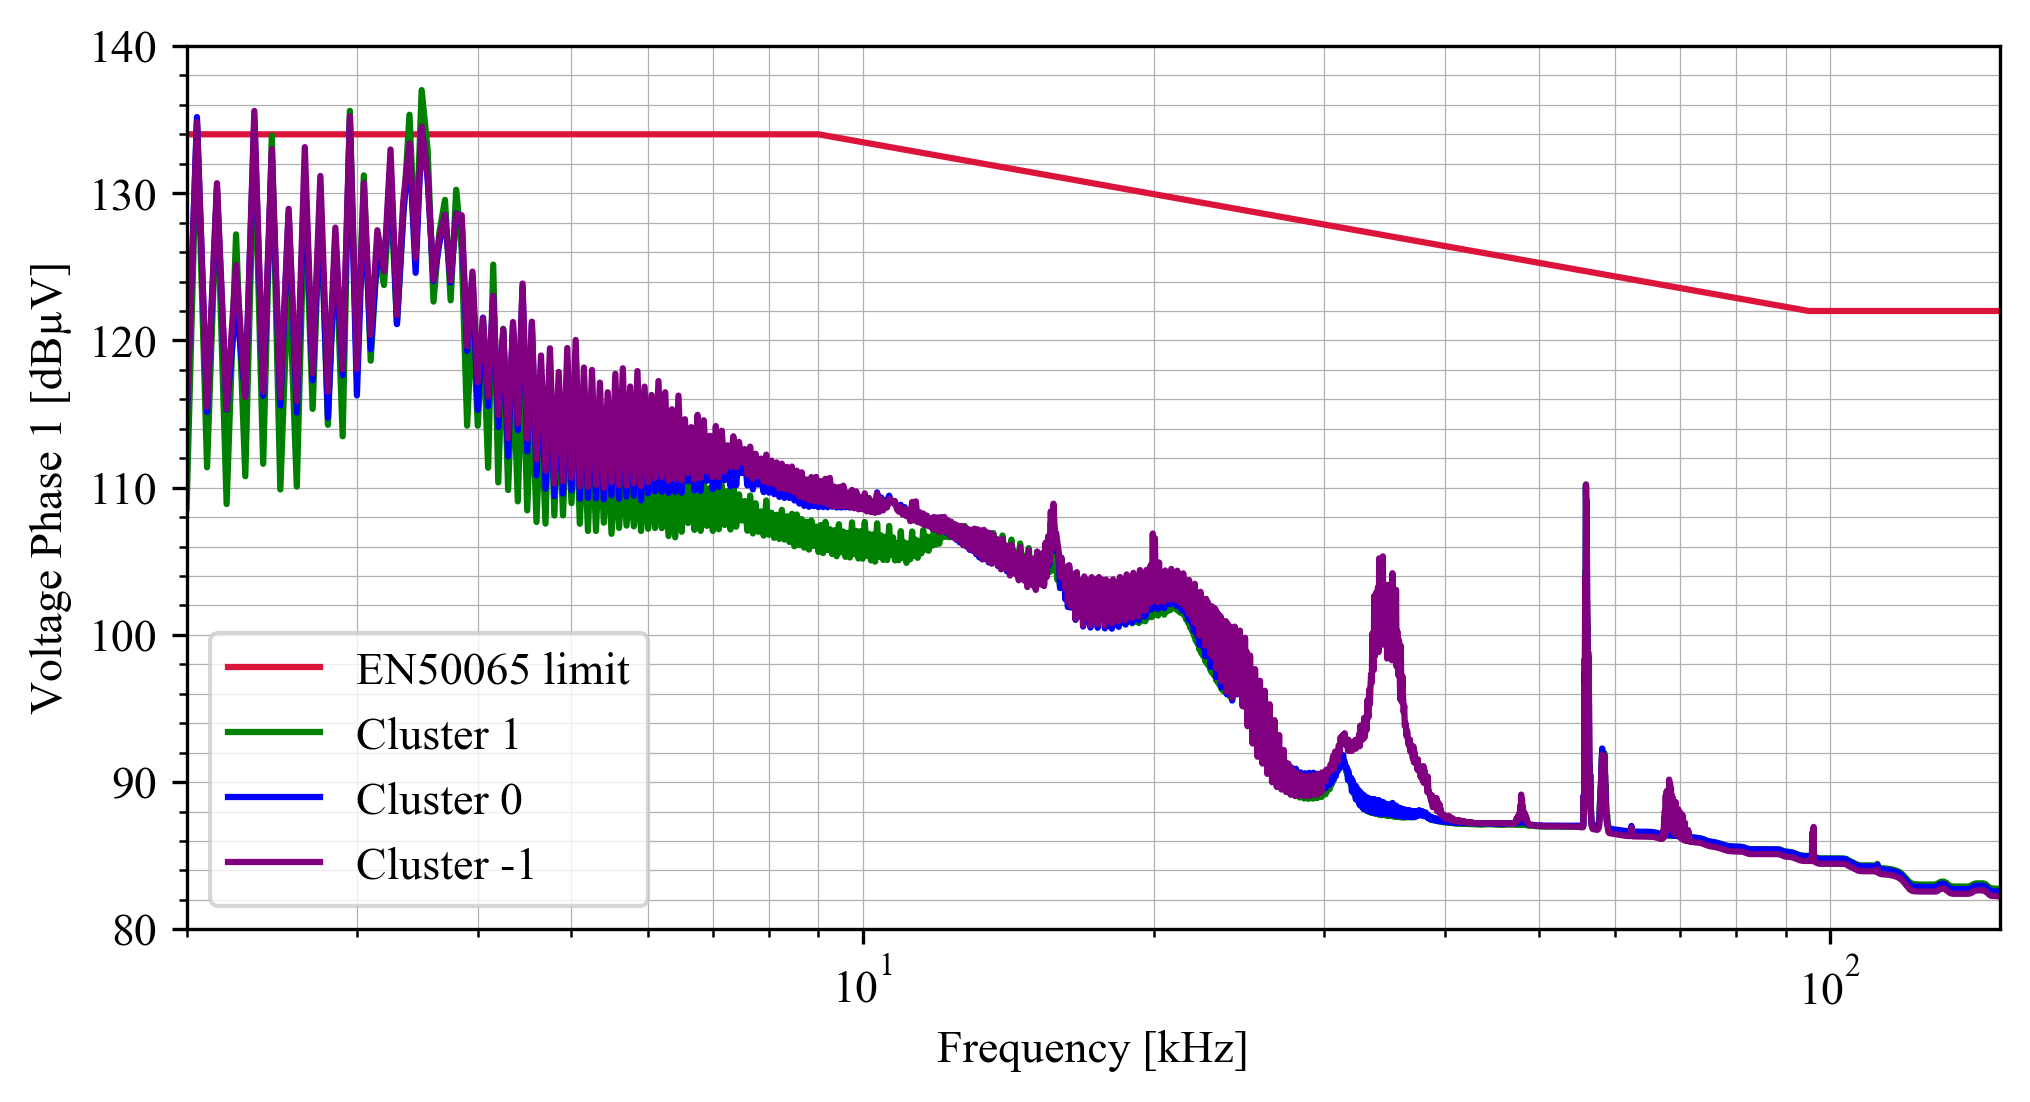

In [66]:
x = generateXAxisData()/1000

fig, ax = plt.subplots()
#ax.plot(x, limits, label="EN50065 limit", color="r")
ax.plot(x, limits, color="crimson", label="EN50065 limit")
ax.plot(x, shu_db_p1_c1, label="Cluster 1", color="green")
ax.plot(x, shu_db_p1_c0, label="Cluster 0", color="blue")
ax.plot(x, shu_db_p1_cm1, label="Cluster -1", color="purple")
ax.set_xlim(min(x), max(x))
ax.set_ylim((80,140))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Voltage Phase 1 [dBµV]')
ax.set_xscale('log')
ax.legend(loc=3)

In [169]:
d = {"limits": limits, 'Cluster1':shu_db_p1_c1, 'Cluster0':shu_db_p1_c0,'cluster-1':shu_db_p1_cm1}

df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-47.xlsx")

### Phase 2

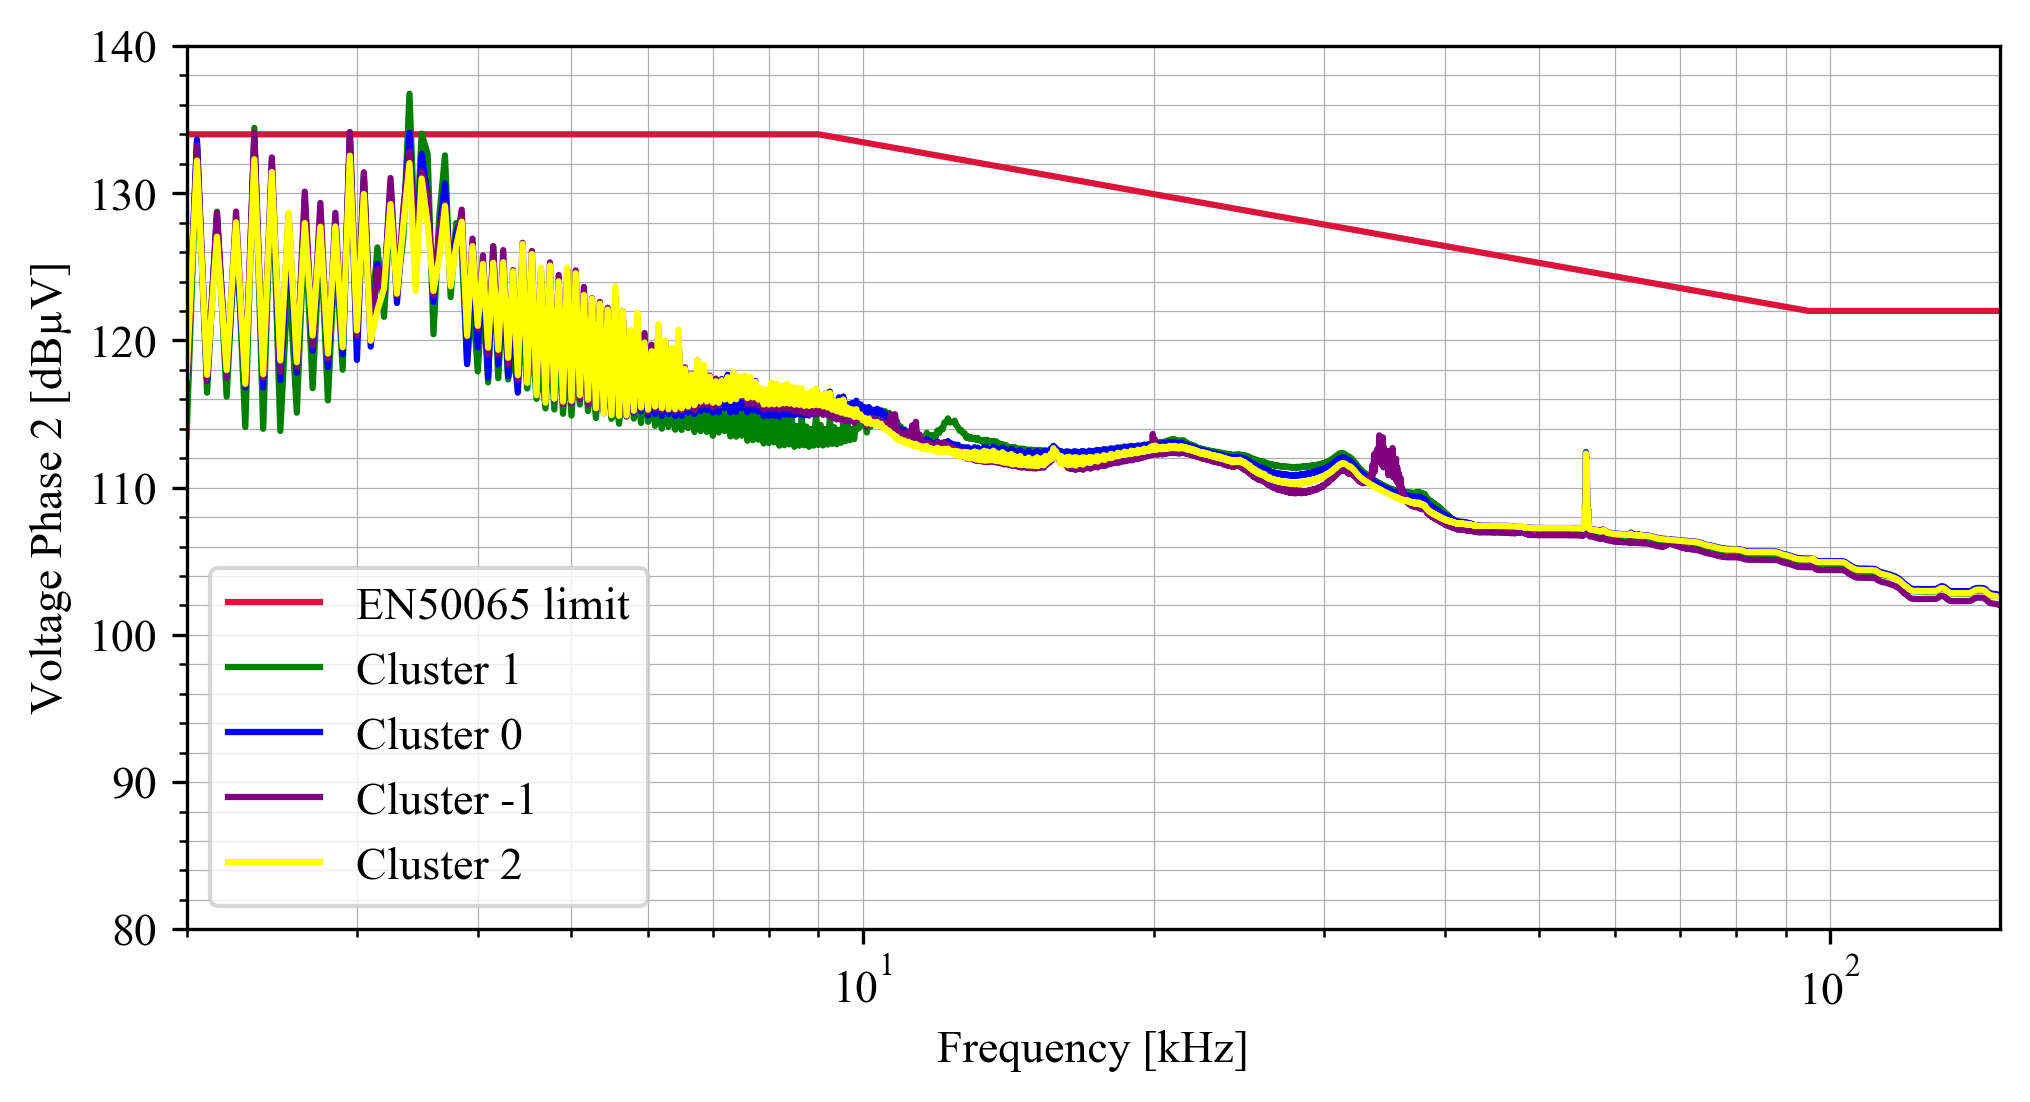

In [67]:
shu_p2_c1 = shu_all_p2[labels2 == 1]
shu_p2_c0 = shu_all_p2[labels2 == 0]
shu_p2_cm1 = shu_all_p2[labels2 == -1]
shu_p2_c2 = shu_all_p2[labels2 == 2]


shu_p2_c1 = np.mean(shu_p2_c1, axis=0)
shu_p2_c0 = np.mean(shu_p2_c0, axis=0)
shu_p2_cm1 = np.mean(shu_p2_cm1, axis=0)
shu_p2_c2 = np.mean(shu_p2_c2, axis=0)


shu_db_p2_c1 = levels_dbmyV(shu_p2_c1.to_numpy(dtype=np.float32))
shu_db_p2_c0 = levels_dbmyV(shu_p2_c0.to_numpy(dtype=np.float32))
shu_db_p2_cm1 = levels_dbmyV(shu_p2_cm1.to_numpy(dtype=np.float32))
shu_db_p2_c2 = levels_dbmyV(shu_p2_c2.to_numpy(dtype=np.float32))


x = generateXAxisData()/1000

fig, ax = plt.subplots()
#ax.plot(x, limits, label="EN50065 limit", color="r")
ax.plot(x, limits, color="crimson", label="EN50065 limit")
ax.plot(x, shu_db_p2_c1, label="Cluster 1", color="green")
ax.plot(x, shu_db_p2_c0, label="Cluster 0", color="blue")
ax.plot(x, shu_db_p2_cm1, label="Cluster -1", color="purple")
ax.plot(x, shu_db_p2_c2, label="Cluster 2", color="yellow")

ax.set_xlim(min(x), max(x))
ax.set_ylim((80,140))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Voltage Phase 2 [dBµV]')
ax.set_xscale('log')
ax.legend(loc=3)

In [170]:
d = {"limits": limits, 'Cluster1':shu_db_p2_c1, 'Cluster0':shu_db_p2_c0,'cluster-1':shu_db_p2_cm1,'Cluster2':shu_db_p2_c2}

df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-48.xlsx")

### Phase 3

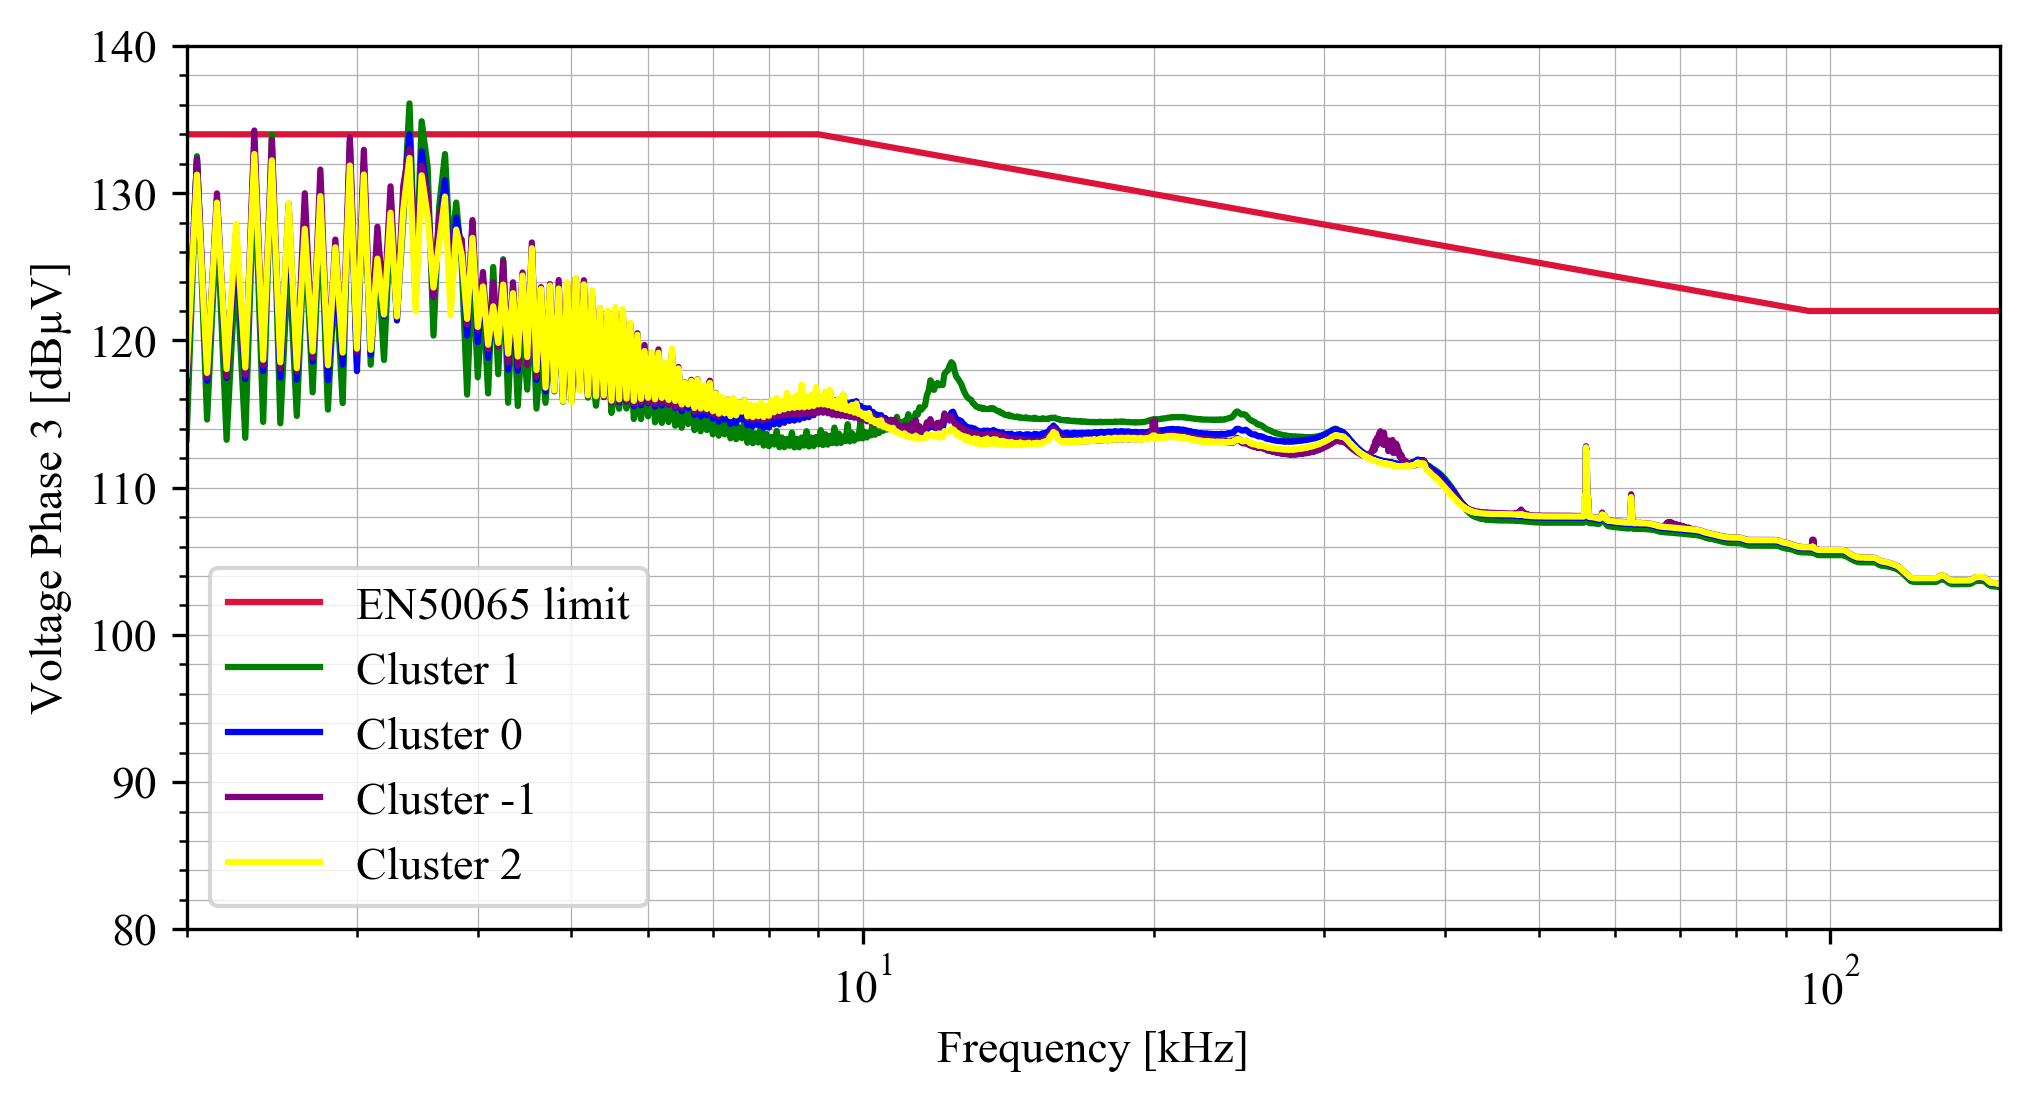

In [68]:
shu_p3_c1 = shu_all_p3[labels3 == 1]
shu_p3_c0 = shu_all_p3[labels3 == 0]
shu_p3_cm1 = shu_all_p3[labels3 == -1]
shu_p3_c2 = shu_all_p3[labels3 == 2]


shu_p3_c1 = np.mean(shu_p3_c1, axis=0)
shu_p3_c0 = np.mean(shu_p3_c0, axis=0)
shu_p3_cm1 = np.mean(shu_p3_cm1, axis=0)
shu_p3_c2 = np.mean(shu_p3_c2, axis=0)


shu_db_p3_c1 = levels_dbmyV(shu_p3_c1.to_numpy(dtype=np.float32))
shu_db_p3_c0 = levels_dbmyV(shu_p3_c0.to_numpy(dtype=np.float32))
shu_db_p3_cm1 = levels_dbmyV(shu_p3_cm1.to_numpy(dtype=np.float32))
shu_db_p3_c2 = levels_dbmyV(shu_p3_c2.to_numpy(dtype=np.float32))


x = generateXAxisData()/1000

fig, ax = plt.subplots()
#ax.plot(x, limits, label="EN50065 limit", color="r")
ax.plot(x, limits, color="crimson", label="EN50065 limit")
ax.plot(x, shu_db_p3_c1, label="Cluster 1", color="green")
ax.plot(x, shu_db_p3_c0, label="Cluster 0", color="blue")
ax.plot(x, shu_db_p3_cm1, label="Cluster -1", color="purple")
ax.plot(x, shu_db_p3_c2, label="Cluster 2", color="yellow")

ax.set_xlim(min(x), max(x))
ax.set_ylim((80,140))
ax.minorticks_on()
ax.grid(linewidth=0.3, which='both')
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel('Voltage Phase 3 [dBµV]')
ax.set_xscale('log')
ax.legend()

In [171]:
d = {"limits": limits, 'Cluster1':shu_db_p3_c1, 'Cluster0':shu_db_p3_c0,'cluster-1':shu_db_p3_cm1,'Cluster2':shu_db_p3_c2}

df = pd.DataFrame(data=d)
df.index = x
df.to_excel("4-49.xlsx")